In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/PATOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=228.2, y1=121.6
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 736
Page 1, Q1, A: Yellow percentage: 0.0%


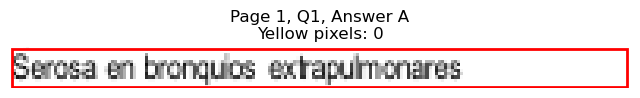

Page 1, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=244.7, y1=133.6
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 857
Page 1, Q1, B: Yellow percentage: 0.0%


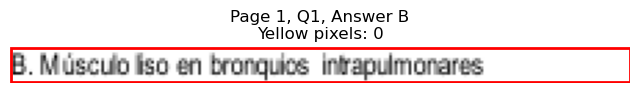

Page 1, Q1 - C: Detected box: x0=113.3, y0=133.5, x1=217.7, y1=145.6
Page 1, Q1, C: Yellow pixels: 818
Page 1, Q1, C: Total non-white pixels: 1339
Page 1, Q1, C: Yellow percentage: 61.1%


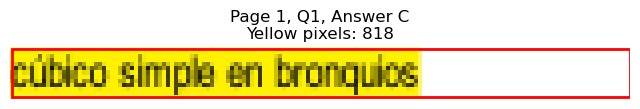

Page 1, Q1 - D: Detected box: x0=444.4, y0=109.5, x1=494.8, y1=121.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 245
Page 1, Q1, D: Yellow percentage: 0.0%


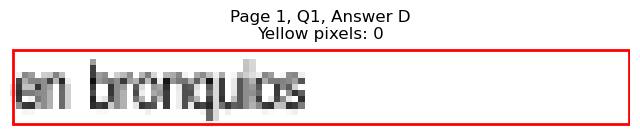

Page 1, Q1 - E: Detected box: x0=370.9, y0=133.5, x1=440.8, y1=145.6
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 592
Page 1, Q1, E: Yellow percentage: 0.0%


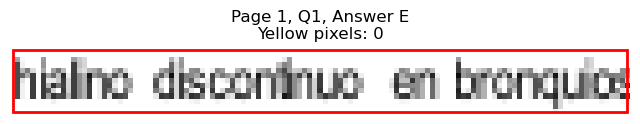


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=132.3, y1=193.6
Page 1, Q2, A: Yellow pixels: 364
Page 1, Q2, A: Total non-white pixels: 626
Page 1, Q2, A: Yellow percentage: 58.1%


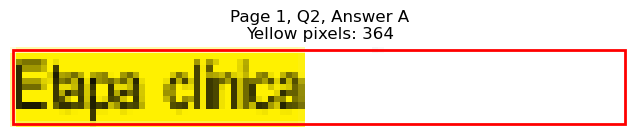

Page 1, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=141.2, y1=205.6
Page 1, Q2, B: Yellow pixels: 47
Page 1, Q2, B: Total non-white pixels: 404
Page 1, Q2, B: Yellow percentage: 11.6%


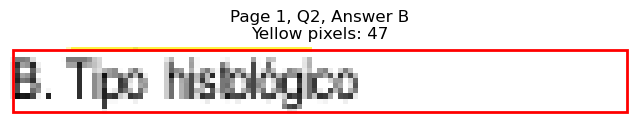

Page 1, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=181.7, y1=217.7
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 794
Page 1, Q2, C: Yellow percentage: 0.0%


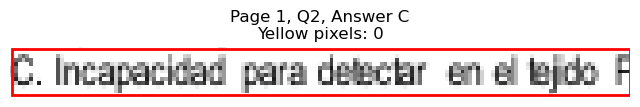

Page 1, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=493.3, y1=193.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 834
Page 1, Q2, D: Yellow percentage: 0.0%


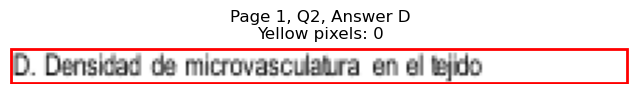

Page 1, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=399.5, y1=217.7
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 392
Page 1, Q2, E: Yellow percentage: 0.0%


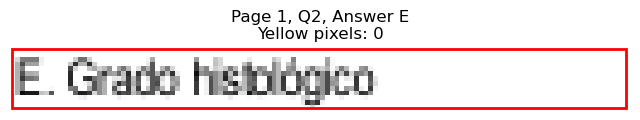


Page 1, Q2 - Selected Answer: A (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=155.5, y1=253.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 371
Page 1, Q3, A: Yellow percentage: 0.0%


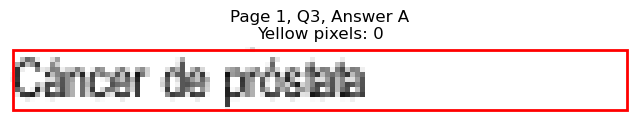

Page 1, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=150.2, y1=265.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 369
Page 1, Q3, B: Yellow percentage: 0.0%


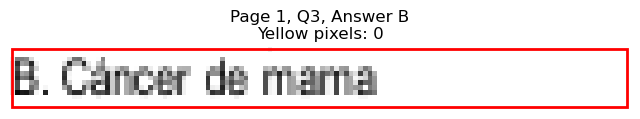

Page 1, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=154.0, y1=277.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 373
Page 1, Q3, C: Yellow percentage: 0.0%


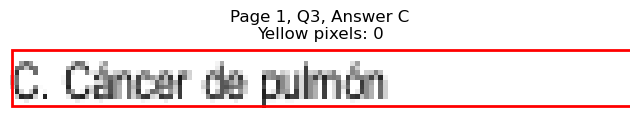

Page 1, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=401.1, y1=253.7
Page 1, Q3, D: Yellow pixels: 596
Page 1, Q3, D: Total non-white pixels: 1001
Page 1, Q3, D: Yellow percentage: 59.5%


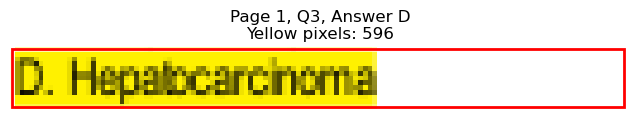

Page 1, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=419.8, y1=265.7
Page 1, Q3, E: Yellow pixels: 76
Page 1, Q3, E: Total non-white pixels: 561
Page 1, Q3, E: Yellow percentage: 13.5%


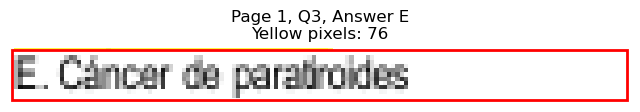


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=102.2, y1=326.5
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 91
Page 1, Q4, A: Yellow percentage: 0.0%


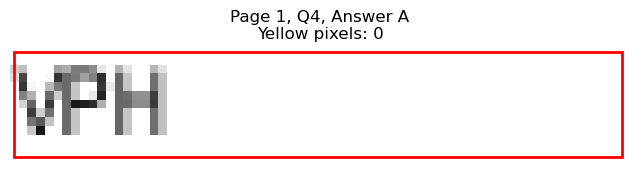

Page 1, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=196.8, y1=338.5
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 654
Page 1, Q4, B: Yellow percentage: 0.0%


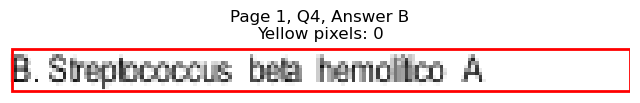

Page 1, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=151.7, y1=350.5
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 396
Page 1, Q4, C: Yellow percentage: 0.0%


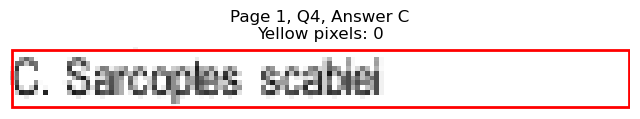

Page 1, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=419.8, y1=326.5
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 482
Page 1, Q4, D: Yellow percentage: 0.0%


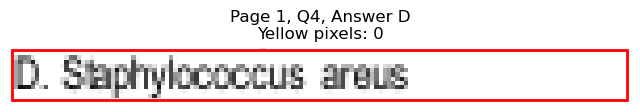

Page 1, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=383.0, y1=338.5
Page 1, Q4, E: Yellow pixels: 801
Page 1, Q4, E: Total non-white pixels: 1157
Page 1, Q4, E: Yellow percentage: 69.2%


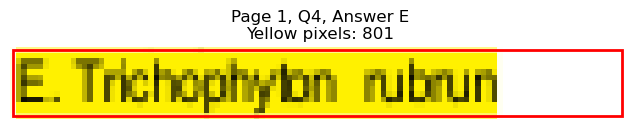


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=132.2, y1=386.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 240
Page 1, Q5, A: Yellow percentage: 0.0%


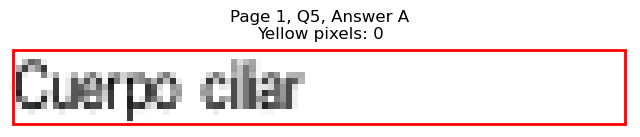

Page 1, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=112.7, y1=398.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 200
Page 1, Q5, B: Yellow percentage: 0.0%


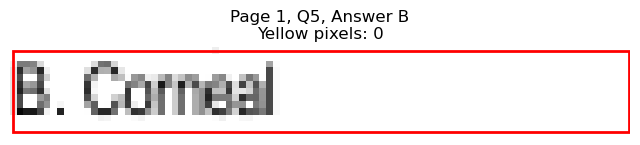

Page 1, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=135.9, y1=410.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 290
Page 1, Q5, C: Yellow percentage: 0.0%


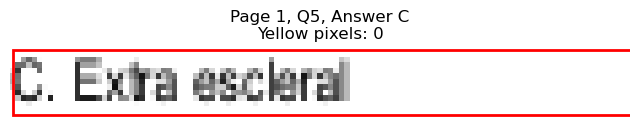

Page 1, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=347.8, y1=386.6
Page 1, Q5, D: Yellow pixels: 215
Page 1, Q5, D: Total non-white pixels: 315
Page 1, Q5, D: Yellow percentage: 68.3%


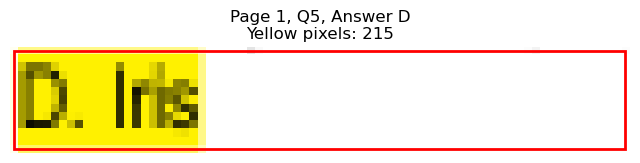

Page 1, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=368.8, y1=398.6
Page 1, Q5, E: Yellow pixels: 22
Page 1, Q5, E: Total non-white pixels: 239
Page 1, Q5, E: Yellow percentage: 9.2%


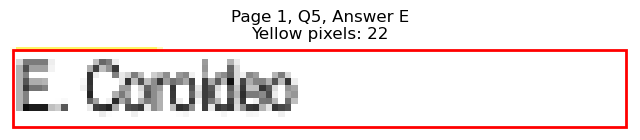


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.6, y0=458.6, x1=164.6, y1=470.6
Page 1, Q6, A: Yellow pixels: 610
Page 1, Q6, A: Total non-white pixels: 1053
Page 1, Q6, A: Yellow percentage: 57.9%


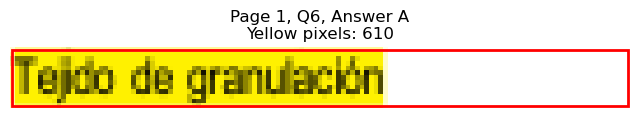

Page 1, Q6 - B: Detected box: x0=71.3, y0=470.6, x1=173.5, y1=482.6
Page 1, Q6, B: Yellow pixels: 79
Page 1, Q6, B: Total non-white pixels: 584
Page 1, Q6, B: Yellow percentage: 13.5%


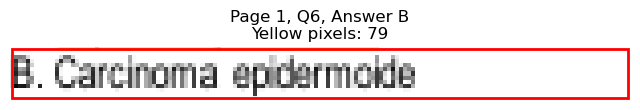

Page 1, Q6 - C: Detected box: x0=71.3, y0=483.4, x1=169.7, y1=495.4
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 490
Page 1, Q6, C: Yellow percentage: 0.0%


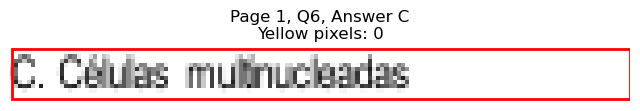

Page 1, Q6 - D: Detected box: x0=369.4, y0=458.6, x1=456.5, y1=470.6
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 460
Page 1, Q6, D: Yellow percentage: 0.0%


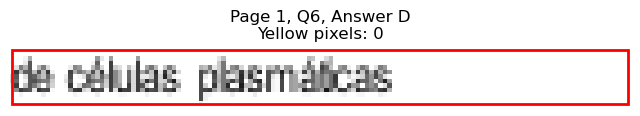

Page 1, Q6 - E: Detected box: x0=322.9, y0=470.6, x1=406.3, y1=482.6
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 421
Page 1, Q6, E: Yellow percentage: 0.0%


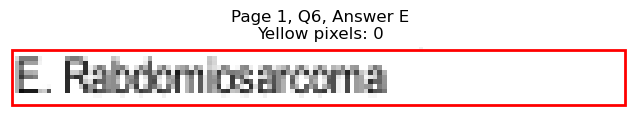


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=115.8, y1=531.4
Page 1, Q7, A: Yellow pixels: 267
Page 1, Q7, A: Total non-white pixels: 416
Page 1, Q7, A: Yellow percentage: 64.2%


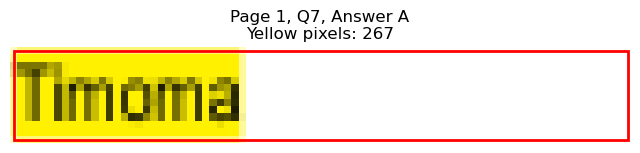

Page 1, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=160.7, y1=543.5
Page 1, Q7, B: Yellow pixels: 30
Page 1, Q7, B: Total non-white pixels: 456
Page 1, Q7, B: Yellow percentage: 6.6%


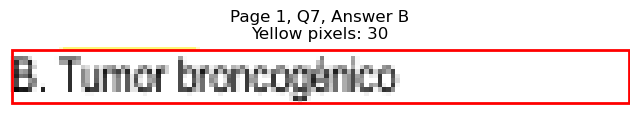

Page 1, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=120.2, y1=555.5
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 227
Page 1, Q7, C: Yellow percentage: 0.0%


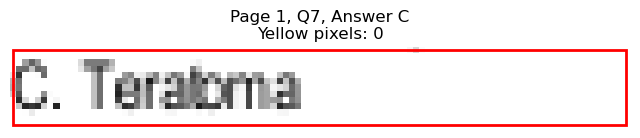

Page 1, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=398.0, y1=531.4
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 387
Page 1, Q7, D: Yellow percentage: 0.0%


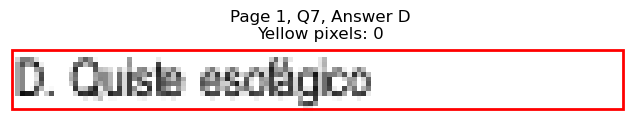

Page 1, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=412.3, y1=543.5
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 447
Page 1, Q7, E: Yellow percentage: 0.0%


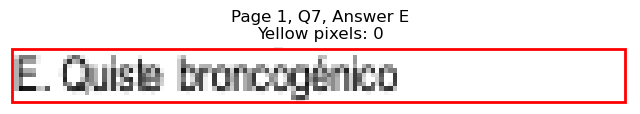


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=128.5, y1=591.5
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 236
Page 1, Q8, A: Yellow percentage: 0.0%


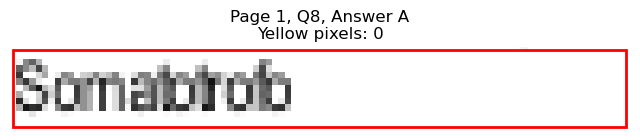

Page 1, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=128.5, y1=603.5
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 284
Page 1, Q8, B: Yellow percentage: 0.0%


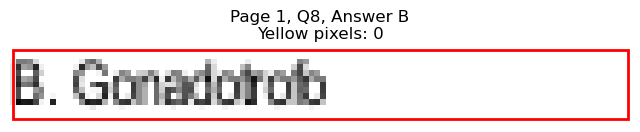

Page 1, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=117.2, y1=615.5
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 206
Page 1, Q8, C: Yellow percentage: 0.0%


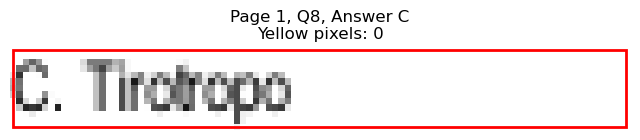

Page 1, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=377.9, y1=591.5
Page 1, Q8, D: Yellow pixels: 457
Page 1, Q8, D: Total non-white pixels: 702
Page 1, Q8, D: Yellow percentage: 65.1%


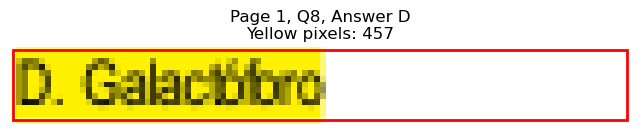

Page 1, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=379.3, y1=603.5
Page 1, Q8, E: Yellow pixels: 52
Page 1, Q8, E: Total non-white pixels: 326
Page 1, Q8, E: Yellow percentage: 16.0%


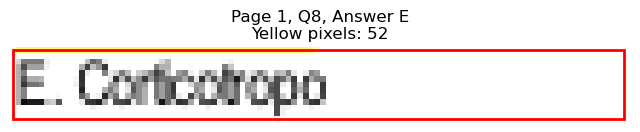


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=82.6, y0=639.5, x1=193.9, y1=651.6
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 482
Page 1, Q9, A: Yellow percentage: 0.0%


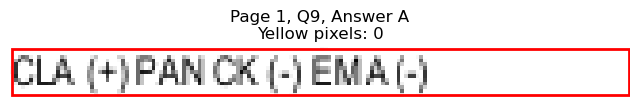

Page 1, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=189.1, y1=663.6
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 557
Page 1, Q9, B: Yellow percentage: 0.0%


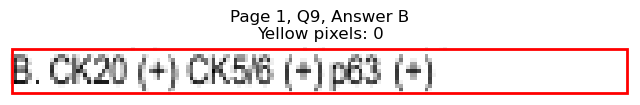

Page 1, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=202.9, y1=675.6
Page 1, Q9, C: Yellow pixels: 1144
Page 1, Q9, C: Total non-white pixels: 1690
Page 1, Q9, C: Yellow percentage: 67.7%


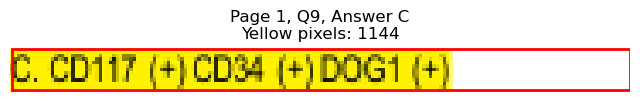

Page 1, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=442.1, y1=651.6
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 525
Page 1, Q9, D: Yellow percentage: 0.0%


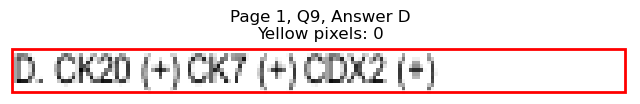

Page 1, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=463.1, y1=663.6
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 621
Page 1, Q9, E: Yellow percentage: 0.0%


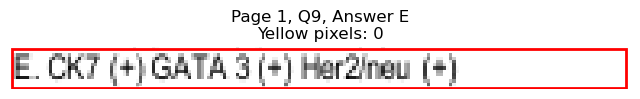


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=82.6, y0=700.3, x1=107.5, y1=712.3
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 99
Page 1, Q10, A: Yellow percentage: 0.0%


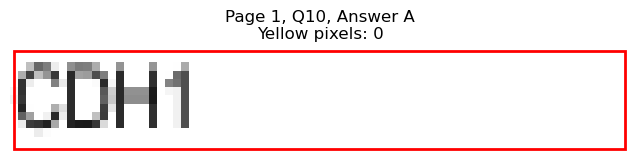

Page 1, Q10 - B: Detected box: x0=71.3, y0=712.3, x1=97.8, y1=724.4
Page 1, Q10, B: Yellow pixels: 200
Page 1, Q10, B: Total non-white pixels: 325
Page 1, Q10, B: Yellow percentage: 61.5%


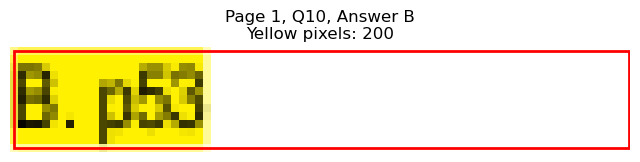

Page 1, Q10 - C: Detected box: x0=71.3, y0=724.3, x1=123.3, y1=736.4
Page 1, Q10, C: Yellow pixels: 1
Page 1, Q10, C: Total non-white pixels: 223
Page 1, Q10, C: Yellow percentage: 0.4%


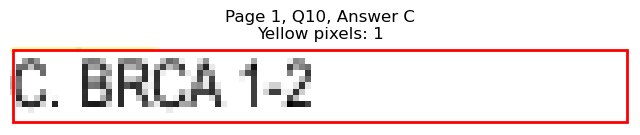

Page 1, Q10 - D: Detected box: x0=322.9, y0=700.3, x1=354.5, y1=712.3
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 136
Page 1, Q10, D: Yellow percentage: 0.0%


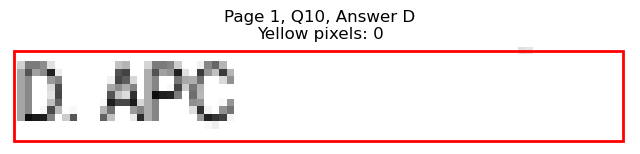

Page 1, Q10 - E: Detected box: x0=322.9, y0=712.3, x1=364.3, y1=724.4
Page 1, Q10, E: Yellow pixels: 0
Page 1, Q10, E: Total non-white pixels: 160
Page 1, Q10, E: Yellow percentage: 0.0%


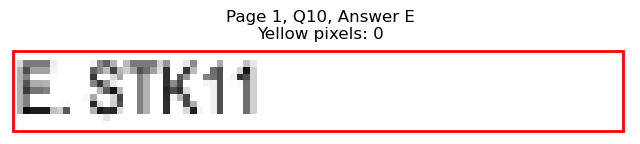


Page 1, Q10 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=111.2, y1=108.8
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 125
Page 2, Q1, A: Yellow percentage: 0.0%


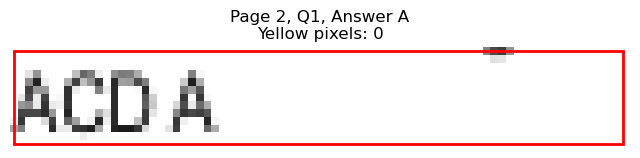

Page 2, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=110.4, y1=121.6
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 176
Page 2, Q1, B: Yellow percentage: 0.0%


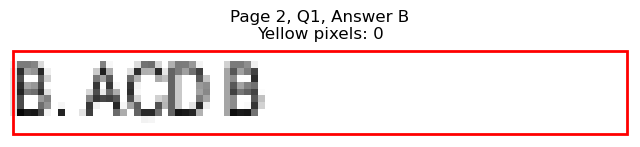

Page 2, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=107.5, y1=133.6
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 322
Page 2, Q1, C: Yellow percentage: 0.0%


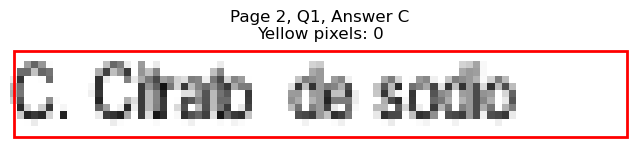

Page 2, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=359.8, y1=108.8
Page 2, Q1, D: Yellow pixels: 292
Page 2, Q1, D: Total non-white pixels: 470
Page 2, Q1, D: Yellow percentage: 62.1%


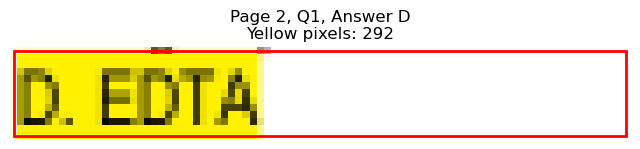

Page 2, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=368.8, y1=121.6
Page 2, Q1, E: Yellow pixels: 34
Page 2, Q1, E: Total non-white pixels: 257
Page 2, Q1, E: Yellow percentage: 13.2%


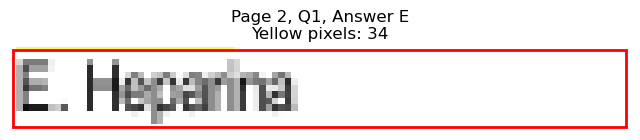


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=201.3, y1=169.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 590
Page 2, Q2, A: Yellow percentage: 0.0%


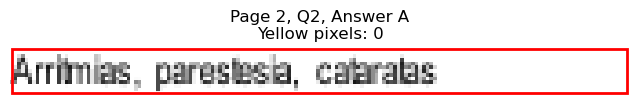

Page 2, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=128.5, y1=181.6
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 548
Page 2, Q2, B: Yellow percentage: 0.0%


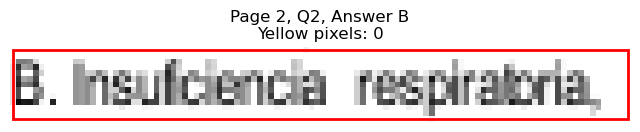

Page 2, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=141.2, y1=193.6
Page 2, Q2, C: Yellow pixels: 994
Page 2, Q2, C: Total non-white pixels: 1573
Page 2, Q2, C: Yellow percentage: 63.2%


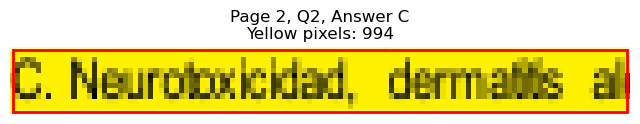

Page 2, Q2 - D: Detected box: x0=400.1, y0=157.6, x1=514.3, y1=169.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 569
Page 2, Q2, D: Yellow percentage: 0.0%


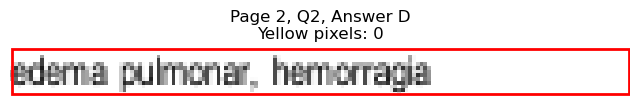

Page 2, Q2 - E: Detected box: x0=435.4, y0=169.6, x1=508.2, y1=181.6
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 356
Page 2, Q2, E: Yellow percentage: 0.0%


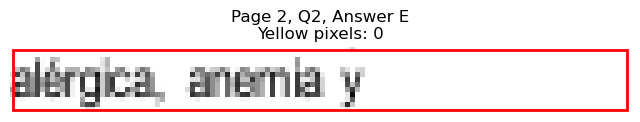


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.6, y0=217.6, x1=202.0, y1=229.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 573
Page 2, Q3, A: Yellow percentage: 0.0%


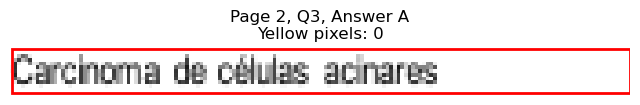

Page 2, Q3 - B: Detected box: x0=71.3, y0=229.6, x1=151.7, y1=241.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 607
Page 2, Q3, B: Yellow percentage: 0.0%


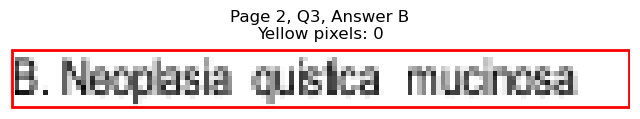

Page 2, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=155.6, y1=253.7
Page 2, Q3, C: Yellow pixels: 638
Page 2, Q3, C: Total non-white pixels: 1079
Page 2, Q3, C: Yellow percentage: 59.1%


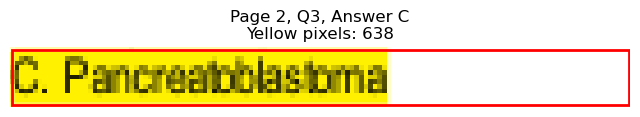

Page 2, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=399.5, y1=229.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 366
Page 2, Q3, D: Yellow percentage: 0.0%


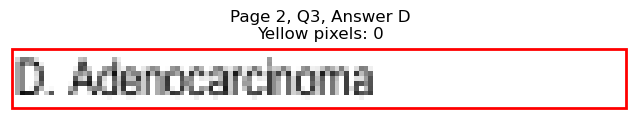

Page 2, Q3 - E: Detected box: x0=322.9, y0=229.6, x1=479.8, y1=241.7
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 795
Page 2, Q3, E: Yellow percentage: 0.0%


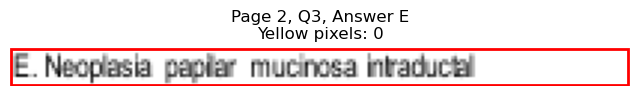


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=150.3, y1=326.5
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 582
Page 2, Q4, A: Yellow percentage: 0.0%


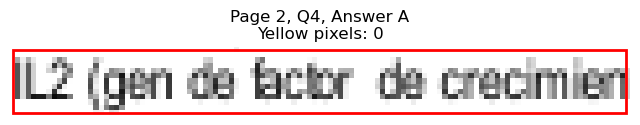

Page 2, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=177.2, y1=338.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 744
Page 2, Q4, B: Yellow percentage: 0.0%


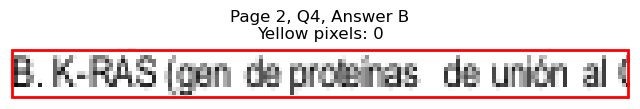

Page 2, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=205.7, y1=350.5
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 627
Page 2, Q4, C: Yellow percentage: 0.0%


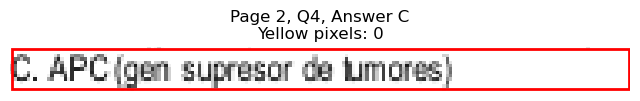

Page 2, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=434.9, y1=326.5
Page 2, Q4, D: Yellow pixels: 953
Page 2, Q4, D: Total non-white pixels: 1443
Page 2, Q4, D: Yellow percentage: 66.0%


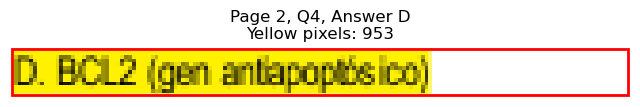

Page 2, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=474.4, y1=338.5
Page 2, Q4, E: Yellow pixels: 109
Page 2, Q4, E: Total non-white pixels: 850
Page 2, Q4, E: Yellow percentage: 12.8%


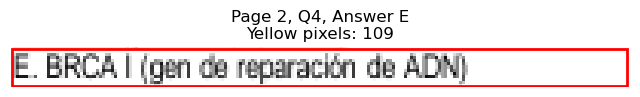


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=133.0, y1=386.6
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 231
Page 2, Q5, A: Yellow percentage: 0.0%


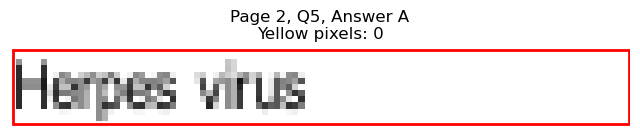

Page 2, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=148.7, y1=398.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 391
Page 2, Q5, B: Yellow percentage: 0.0%


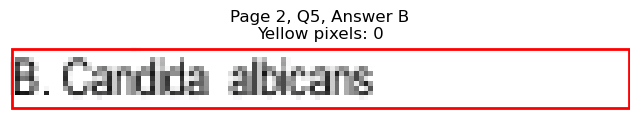

Page 2, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=102.2, y1=410.6
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 121
Page 2, Q5, C: Yellow percentage: 0.0%


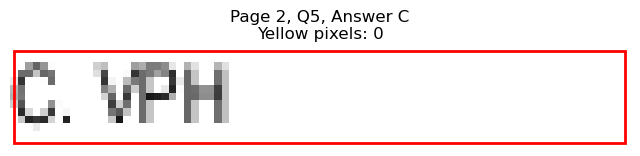

Page 2, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=350.0, y1=386.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 119
Page 2, Q5, D: Yellow percentage: 0.0%


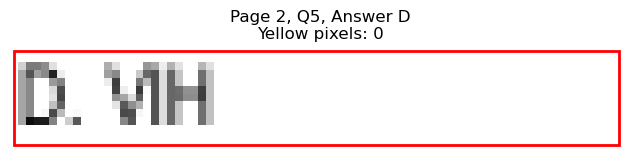

Page 2, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=353.1, y1=398.6
Page 2, Q5, E: Yellow pixels: 218
Page 2, Q5, E: Total non-white pixels: 377
Page 2, Q5, E: Yellow percentage: 57.8%


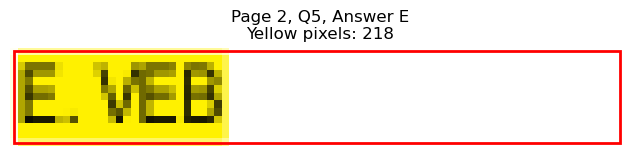


Page 2, Q5 - Selected Answer: E (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.6, y0=434.6, x1=148.0, y1=446.6
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 329
Page 2, Q6, A: Yellow percentage: 0.0%


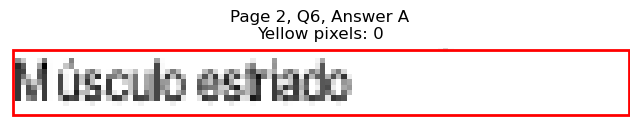

Page 2, Q6 - B: Detected box: x0=71.3, y0=446.6, x1=139.1, y1=458.6
Page 2, Q6, B: Yellow pixels: 526
Page 2, Q6, B: Total non-white pixels: 858
Page 2, Q6, B: Yellow percentage: 61.3%


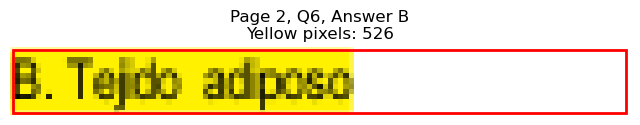

Page 2, Q6 - C: Detected box: x0=71.3, y0=458.6, x1=109.0, y1=470.6
Page 2, Q6, C: Yellow pixels: 66
Page 2, Q6, C: Total non-white pixels: 213
Page 2, Q6, C: Yellow percentage: 31.0%


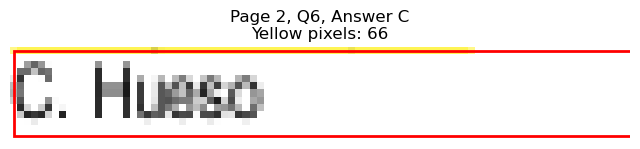

Page 2, Q6 - D: Detected box: x0=322.9, y0=434.6, x1=368.1, y1=446.6
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 232
Page 2, Q6, D: Yellow percentage: 0.0%


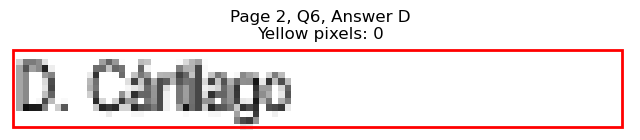

Page 2, Q6 - E: Detected box: x0=322.9, y0=446.6, x1=370.3, y1=458.6
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 241
Page 2, Q6, E: Yellow percentage: 0.0%


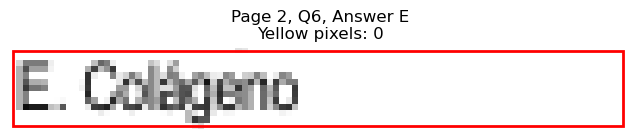


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=139.0, y1=531.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 296
Page 2, Q7, A: Yellow percentage: 0.0%


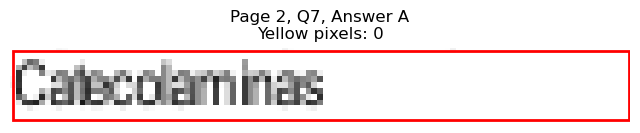

Page 2, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=144.2, y1=543.5
Page 2, Q7, B: Yellow pixels: 866
Page 2, Q7, B: Total non-white pixels: 1287
Page 2, Q7, B: Yellow percentage: 67.3%


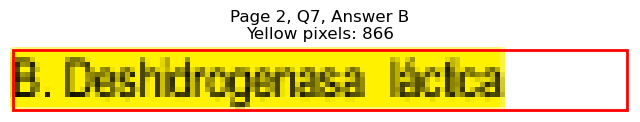

Page 2, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=128.5, y1=555.5
Page 2, Q7, C: Yellow pixels: 97
Page 2, Q7, C: Total non-white pixels: 363
Page 2, Q7, C: Yellow percentage: 26.7%


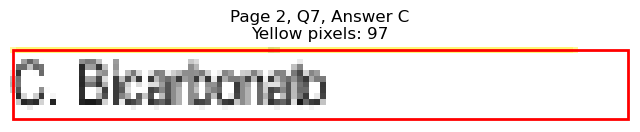

Page 2, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=416.8, y1=531.4
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 486
Page 2, Q7, D: Yellow percentage: 0.0%


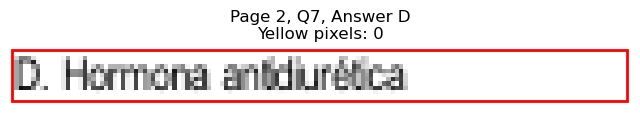

Page 2, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=380.8, y1=543.5
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 280
Page 2, Q7, E: Yellow percentage: 0.0%


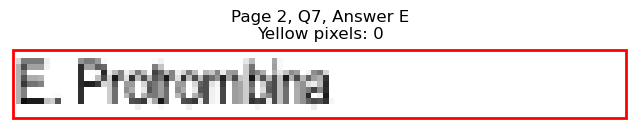


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=130.0, y1=591.5
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 257
Page 2, Q8, A: Yellow percentage: 0.0%


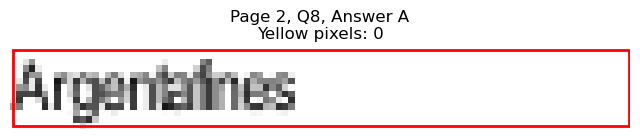

Page 2, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=108.2, y1=603.5
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 174
Page 2, Q8, B: Yellow percentage: 0.0%


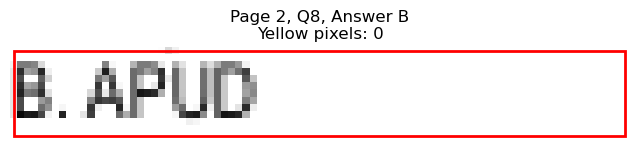

Page 2, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=110.5, y1=615.5
Page 2, Q8, C: Yellow pixels: 340
Page 2, Q8, C: Total non-white pixels: 494
Page 2, Q8, C: Yellow percentage: 68.8%


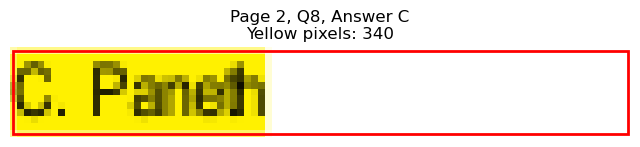

Page 2, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=381.5, y1=591.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 297
Page 2, Q8, D: Yellow percentage: 0.0%


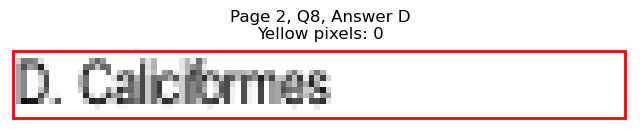

Page 2, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=382.3, y1=603.5
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 286
Page 2, Q8, E: Yellow percentage: 0.0%


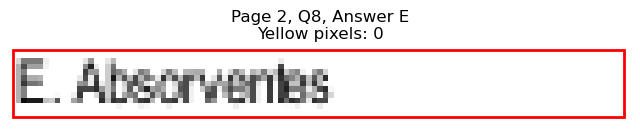


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.6, y0=639.5, x1=189.2, y1=651.6
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 553
Page 2, Q9, A: Yellow percentage: 0.0%


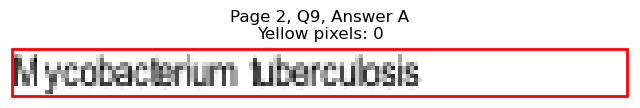

Page 2, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=169.1, y1=663.6
Page 2, Q9, B: Yellow pixels: 826
Page 2, Q9, B: Total non-white pixels: 1248
Page 2, Q9, B: Yellow percentage: 66.2%


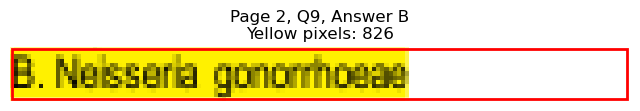

Page 2, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=172.7, y1=675.6
Page 2, Q9, C: Yellow pixels: 96
Page 2, Q9, C: Total non-white pixels: 580
Page 2, Q9, C: Yellow percentage: 16.6%


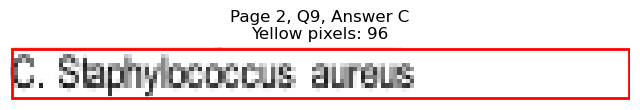

Page 2, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=421.3, y1=651.6
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 502
Page 2, Q9, D: Yellow percentage: 0.0%


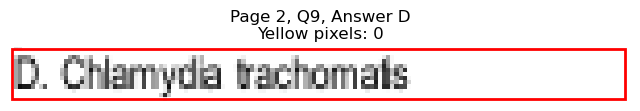

Page 2, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=429.5, y1=663.6
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 513
Page 2, Q9, E: Yellow percentage: 0.0%


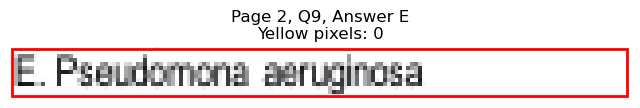


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=82.6, y0=712.3, x1=197.6, y1=724.4
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 570
Page 2, Q10, A: Yellow percentage: 0.0%


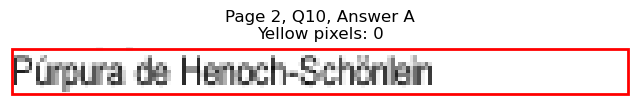

Page 2, Q10 - B: Detected box: x0=71.3, y0=724.3, x1=124.7, y1=736.4
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 424
Page 2, Q10, B: Yellow percentage: 0.0%


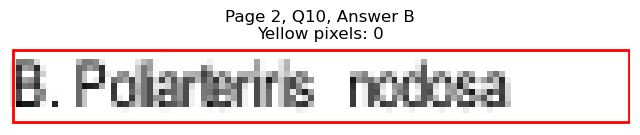

Page 2, Q10 - C: Detected box: x0=71.3, y0=736.4, x1=193.1, y1=748.4
Page 2, Q10, C: Yellow pixels: 1078
Page 2, Q10, C: Total non-white pixels: 1560
Page 2, Q10, C: Yellow percentage: 69.1%


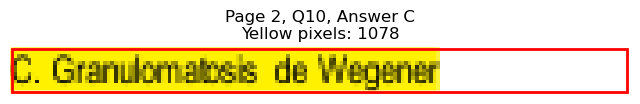

Page 2, Q10 - D: Detected box: x0=322.9, y0=712.3, x1=396.5, y1=724.4
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 388
Page 2, Q10, D: Yellow percentage: 0.0%


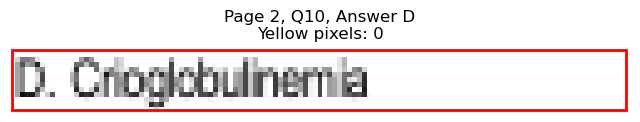

Page 2, Q10 - E: Detected box: x0=322.9, y0=724.3, x1=369.5, y1=736.4
Page 2, Q10, E: Yellow pixels: 0
Page 2, Q10, E: Total non-white pixels: 454
Page 2, Q10, E: Yellow percentage: 0.0%


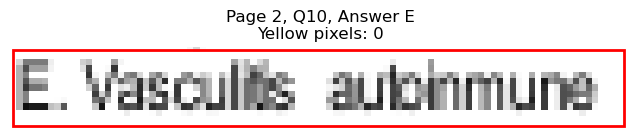


Page 2, Q10 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=173.5, y1=108.8
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 463
Page 3, Q1, A: Yellow percentage: 0.0%


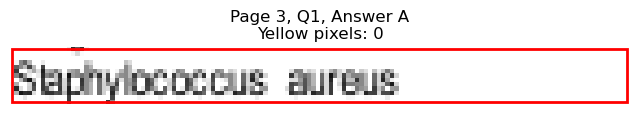

Page 3, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=180.2, y1=121.6
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 557
Page 3, Q1, B: Yellow percentage: 0.0%


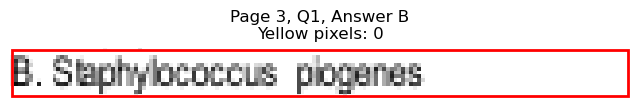

Page 3, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=157.0, y1=133.6
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 425
Page 3, Q1, C: Yellow percentage: 0.0%


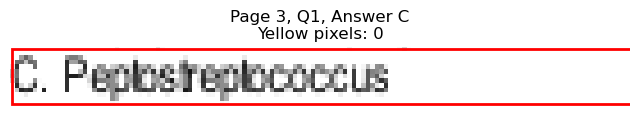

Page 3, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=372.6, y1=108.8
Page 3, Q1, D: Yellow pixels: 365
Page 3, Q1, D: Total non-white pixels: 637
Page 3, Q1, D: Yellow percentage: 57.3%


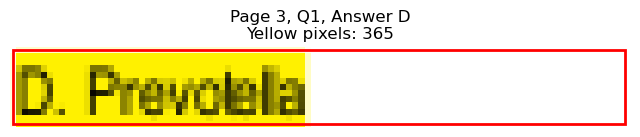

Page 3, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=395.0, y1=121.6
Page 3, Q1, E: Yellow pixels: 47
Page 3, Q1, E: Total non-white pixels: 398
Page 3, Q1, E: Yellow percentage: 11.8%


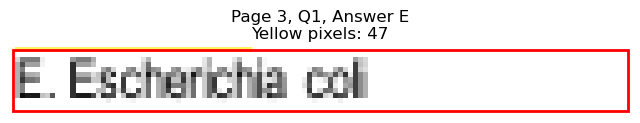


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=153.3, y1=181.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 389
Page 3, Q2, A: Yellow percentage: 0.0%


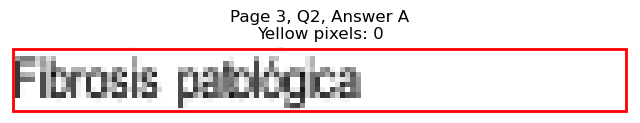

Page 3, Q2 - B: Detected box: x0=120.8, y0=181.6, x1=169.0, y1=193.6
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 225
Page 3, Q2, B: Yellow percentage: 0.0%


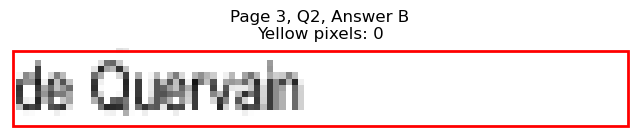

Page 3, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=143.5, y1=205.6
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 317
Page 3, Q2, C: Yellow percentage: 0.0%


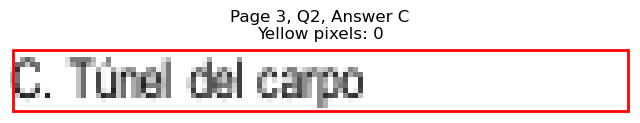

Page 3, Q2 - D: Detected box: x0=381.4, y0=169.6, x1=437.9, y1=181.6
Page 3, Q2, D: Yellow pixels: 413
Page 3, Q2, D: Total non-white pixels: 715
Page 3, Q2, D: Yellow percentage: 57.8%


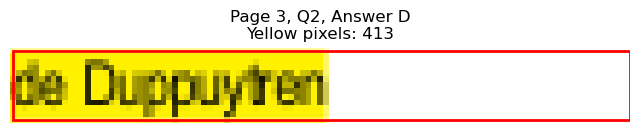

Page 3, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=377.8, y1=193.6
Page 3, Q2, E: Yellow pixels: 105
Page 3, Q2, E: Total non-white pixels: 597
Page 3, Q2, E: Yellow percentage: 17.6%


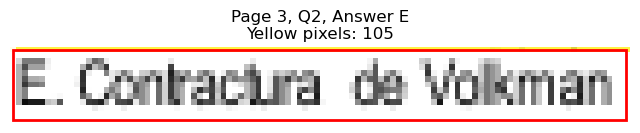


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=160.0, y1=253.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 405
Page 3, Q3, A: Yellow percentage: 0.0%


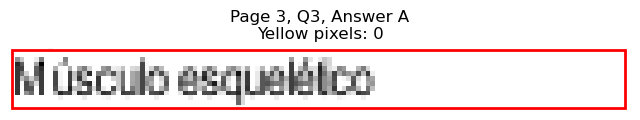

Page 3, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=105.2, y1=265.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 171
Page 3, Q3, B: Yellow percentage: 0.0%


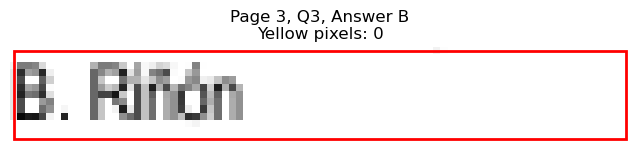

Page 3, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=116.5, y1=277.7
Page 3, Q3, C: Yellow pixels: 362
Page 3, Q3, C: Total non-white pixels: 572
Page 3, Q3, C: Yellow percentage: 63.3%


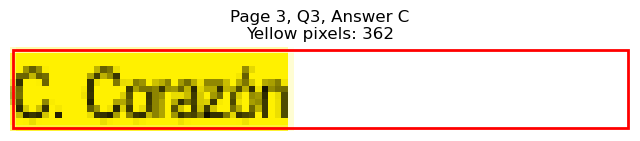

Page 3, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=362.0, y1=253.7
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 191
Page 3, Q3, D: Yellow percentage: 0.0%


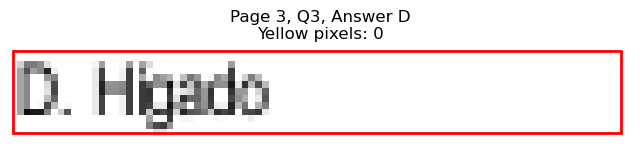

Page 3, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=365.8, y1=265.7
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 195
Page 3, Q3, E: Yellow percentage: 0.0%


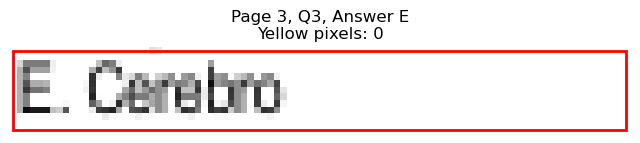


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=71.3, y0=314.5, x1=79.7, y1=326.5
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 67
Page 3, Q4, A: Yellow percentage: 0.0%


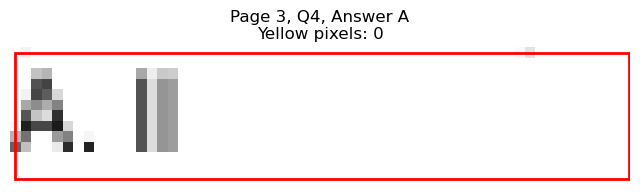

Page 3, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=95.5, y1=338.5
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 109
Page 3, Q4, B: Yellow percentage: 0.0%


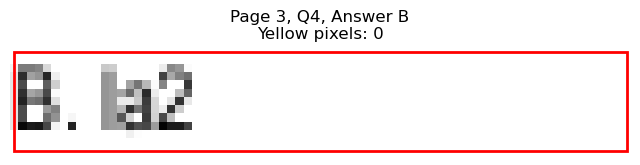

Page 3, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=91.7, y1=350.5
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 74
Page 3, Q4, C: Yellow percentage: 0.0%


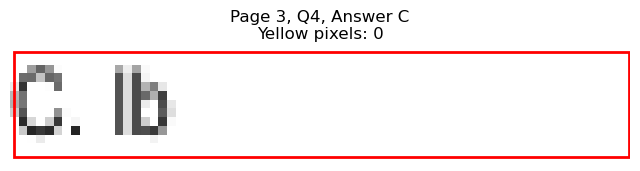

Page 3, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=343.3, y1=326.5
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 74
Page 3, Q4, D: Yellow percentage: 0.0%


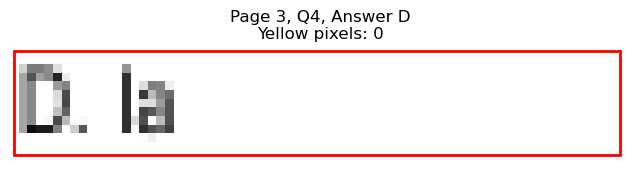

Page 3, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=347.1, y1=338.5
Page 3, Q4, E: Yellow pixels: 210
Page 3, Q4, E: Total non-white pixels: 299
Page 3, Q4, E: Yellow percentage: 70.2%


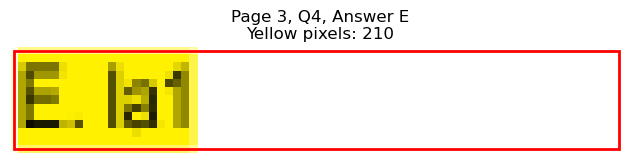


Page 3, Q4 - Selected Answer: E (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=232.9, y1=386.6
Page 3, Q5, A: Yellow pixels: 1375
Page 3, Q5, A: Total non-white pixels: 1939
Page 3, Q5, A: Yellow percentage: 70.9%


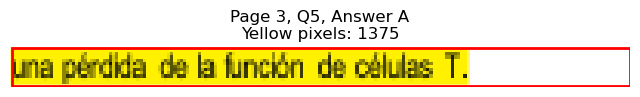

Page 3, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=223.0, y1=398.6
Page 3, Q5, B: Yellow pixels: 147
Page 3, Q5, B: Total non-white pixels: 893
Page 3, Q5, B: Yellow percentage: 16.5%


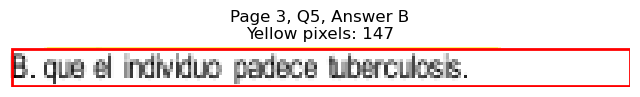

Page 3, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=185.5, y1=410.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 818
Page 3, Q5, C: Yellow percentage: 0.0%


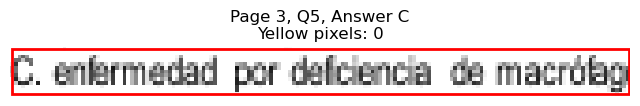

Page 3, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=491.0, y1=386.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 796
Page 3, Q5, D: Yellow percentage: 0.0%


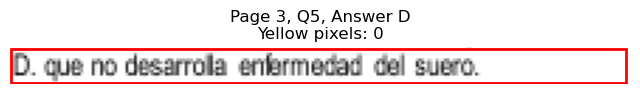

Page 3, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=443.8, y1=398.6
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 828
Page 3, Q5, E: Yellow percentage: 0.0%


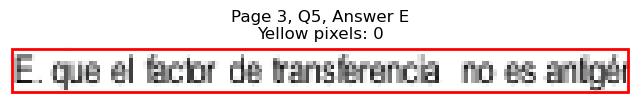


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=119.5, y1=458.6
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 206
Page 3, Q6, A: Yellow percentage: 0.0%


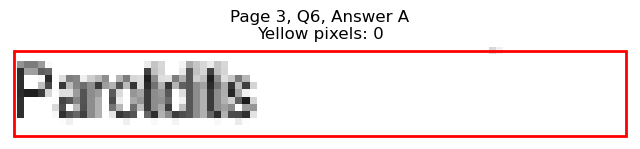

Page 3, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=180.2, y1=470.6
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 558
Page 3, Q6, B: Yellow percentage: 0.0%


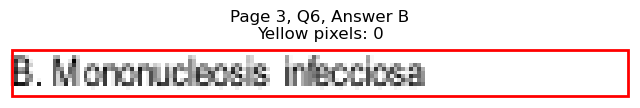

Page 3, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=115.0, y1=482.6
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 201
Page 3, Q6, C: Yellow percentage: 0.0%


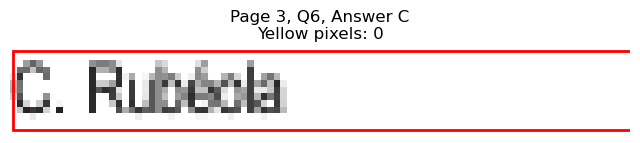

Page 3, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=377.1, y1=458.6
Page 3, Q6, D: Yellow pixels: 407
Page 3, Q6, D: Total non-white pixels: 689
Page 3, Q6, D: Yellow percentage: 59.1%


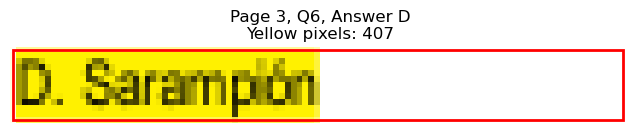

Page 3, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=365.0, y1=470.6
Page 3, Q6, E: Yellow pixels: 52
Page 3, Q6, E: Total non-white pixels: 257
Page 3, Q6, E: Yellow percentage: 20.2%


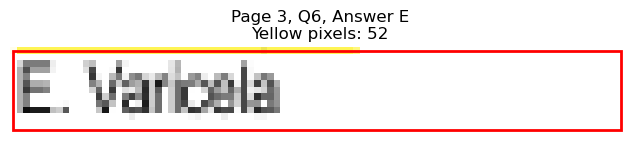


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.6, y0=531.4, x1=170.5, y1=543.5
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 430
Page 3, Q7, A: Yellow percentage: 0.0%


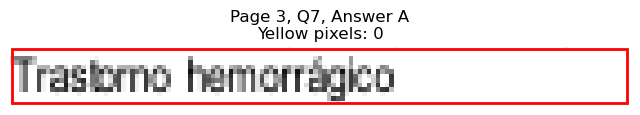

Page 3, Q7 - B: Detected box: x0=71.3, y0=543.4, x1=183.2, y1=555.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 577
Page 3, Q7, B: Yellow percentage: 0.0%


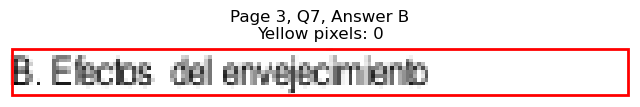

Page 3, Q7 - C: Detected box: x0=71.3, y0=555.4, x1=129.2, y1=567.5
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 463
Page 3, Q7, C: Yellow percentage: 0.0%


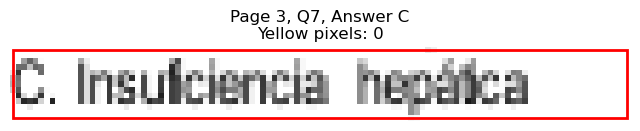

Page 3, Q7 - D: Detected box: x0=322.9, y0=531.4, x1=411.5, y1=543.5
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 464
Page 3, Q7, D: Yellow percentage: 0.0%


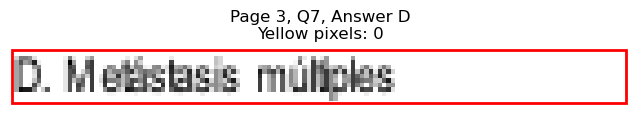

Page 3, Q7 - E: Detected box: x0=322.9, y0=543.4, x1=381.6, y1=555.5
Page 3, Q7, E: Yellow pixels: 491
Page 3, Q7, E: Total non-white pixels: 756
Page 3, Q7, E: Yellow percentage: 64.9%


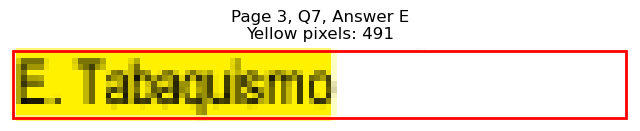


Page 3, Q7 - Selected Answer: E (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.6, y0=591.5, x1=119.5, y1=603.5
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 187
Page 3, Q8, A: Yellow percentage: 0.0%


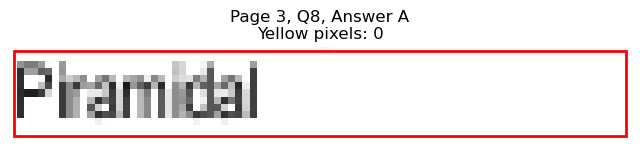

Page 3, Q8 - B: Detected box: x0=71.3, y0=603.5, x1=122.5, y1=615.5
Page 3, Q8, B: Yellow pixels: 444
Page 3, Q8, B: Total non-white pixels: 650
Page 3, Q8, B: Yellow percentage: 68.3%


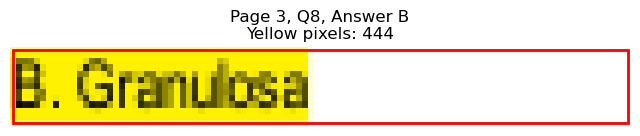

Page 3, Q8 - C: Detected box: x0=71.3, y0=615.5, x1=118.0, y1=627.5
Page 3, Q8, C: Yellow pixels: 49
Page 3, Q8, C: Total non-white pixels: 258
Page 3, Q8, C: Yellow percentage: 19.0%


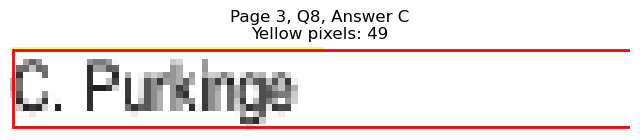

Page 3, Q8 - D: Detected box: x0=322.9, y0=591.5, x1=374.8, y1=603.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 252
Page 3, Q8, D: Yellow percentage: 0.0%


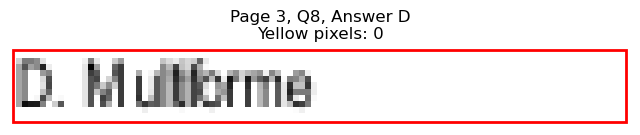

Page 3, Q8 - E: Detected box: x0=322.9, y0=603.5, x1=372.5, y1=615.5
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 234
Page 3, Q8, E: Yellow percentage: 0.0%


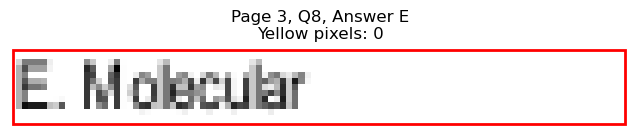


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.6, y0=651.5, x1=255.3, y1=663.6
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 833
Page 3, Q9, A: Yellow percentage: 0.0%


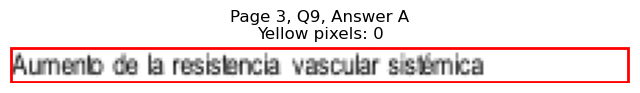

Page 3, Q9 - B: Detected box: x0=71.3, y0=663.5, x1=158.5, y1=675.6
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 410
Page 3, Q9, B: Yellow percentage: 0.0%


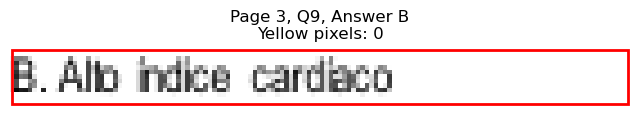

Page 3, Q9 - C: Detected box: x0=71.3, y0=676.3, x1=133.0, y1=688.3
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 281
Page 3, Q9, C: Yellow percentage: 0.0%


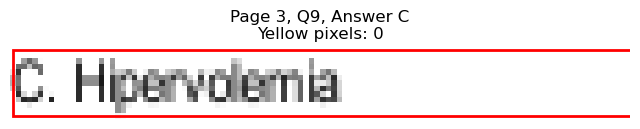

Page 3, Q9 - D: Detected box: x0=322.9, y0=651.5, x1=490.5, y1=663.6
Page 3, Q9, D: Yellow pixels: 1506
Page 3, Q9, D: Total non-white pixels: 2171
Page 3, Q9, D: Yellow percentage: 69.4%


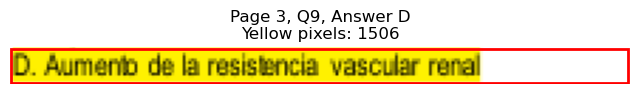

Page 3, Q9 - E: Detected box: x0=322.9, y0=663.5, x1=407.8, y1=675.6
Page 3, Q9, E: Yellow pixels: 135
Page 3, Q9, E: Total non-white pixels: 538
Page 3, Q9, E: Yellow percentage: 25.1%


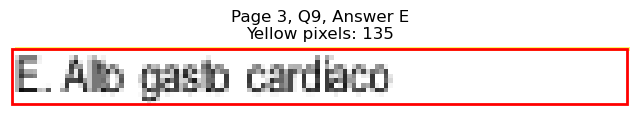


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=82.6, y0=712.3, x1=118.8, y1=724.4
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 196
Page 3, Q10, A: Yellow percentage: 0.0%


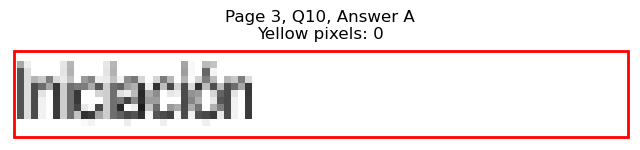

Page 3, Q10 - B: Detected box: x0=71.3, y0=724.3, x1=124.8, y1=736.4
Page 3, Q10, B: Yellow pixels: 407
Page 3, Q10, B: Total non-white pixels: 676
Page 3, Q10, B: Yellow percentage: 60.2%


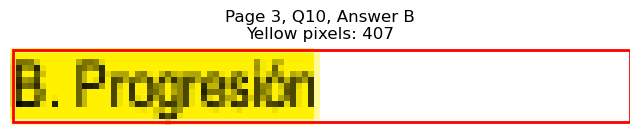

Page 3, Q10 - C: Detected box: x0=71.3, y0=736.4, x1=122.5, y1=748.4
Page 3, Q10, C: Yellow pixels: 2
Page 3, Q10, C: Total non-white pixels: 281
Page 3, Q10, C: Yellow percentage: 0.7%


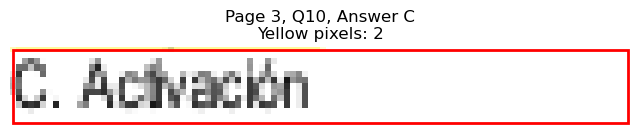

Page 3, Q10 - D: Detected box: x0=322.9, y0=712.3, x1=387.5, y1=724.4
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 343
Page 3, Q10, D: Yellow percentage: 0.0%


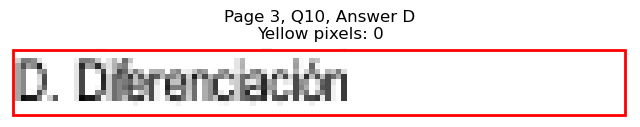

Page 3, Q10 - E: Detected box: x0=322.9, y0=724.3, x1=374.1, y1=736.4
Page 3, Q10, E: Yellow pixels: 0
Page 3, Q10, E: Total non-white pixels: 245
Page 3, Q10, E: Yellow percentage: 0.0%


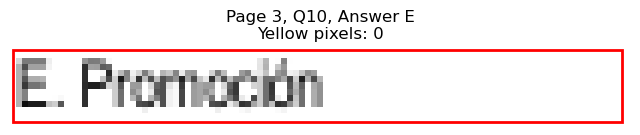


Page 3, Q10 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=175.7, y1=133.6
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 428
Page 4, Q1, A: Yellow percentage: 0.0%


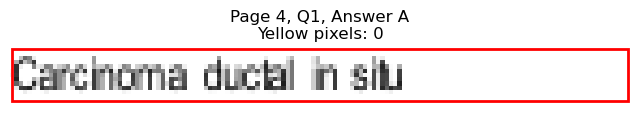

Page 4, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=141.2, y1=145.6
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 346
Page 4, Q1, B: Yellow percentage: 0.0%


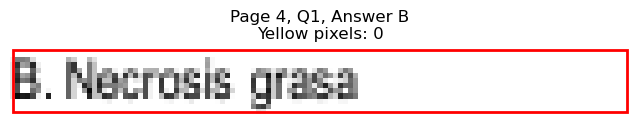

Page 4, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=160.1, y1=157.6
Page 4, Q1, C: Yellow pixels: 692
Page 4, Q1, C: Total non-white pixels: 1131
Page 4, Q1, C: Yellow percentage: 61.2%


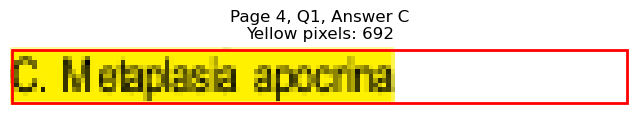

Page 4, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=371.0, y1=133.6
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 230
Page 4, Q1, D: Yellow percentage: 0.0%


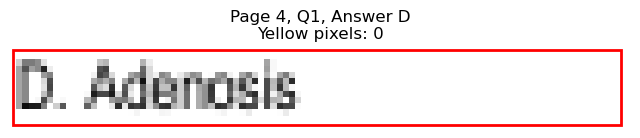

Page 4, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=386.8, y1=145.6
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 329
Page 4, Q1, E: Yellow percentage: 0.0%


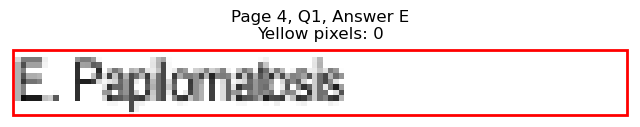


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=123.2, y1=193.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 202
Page 4, Q2, A: Yellow percentage: 0.0%


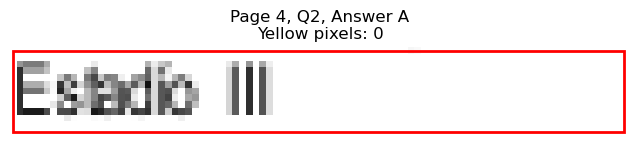

Page 4, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=159.3, y1=205.6
Page 4, Q2, B: Yellow pixels: 700
Page 4, Q2, B: Total non-white pixels: 1118
Page 4, Q2, B: Yellow percentage: 62.6%


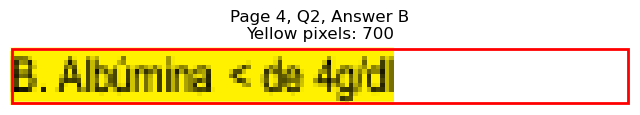

Page 4, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=144.2, y1=217.7
Page 4, Q2, C: Yellow pixels: 86
Page 4, Q2, C: Total non-white pixels: 415
Page 4, Q2, C: Yellow percentage: 20.7%


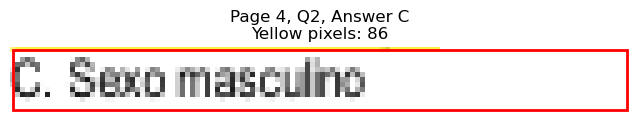

Page 4, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=371.8, y1=193.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 235
Page 4, Q2, D: Yellow percentage: 0.0%


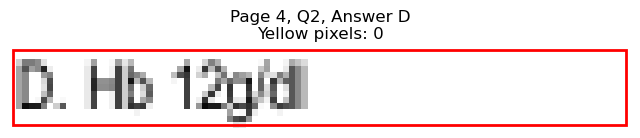

Page 4, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=432.5, y1=205.6
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 519
Page 4, Q2, E: Yellow percentage: 0.0%


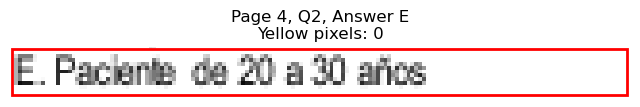


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=187.7, y1=253.7
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 503
Page 4, Q3, A: Yellow percentage: 0.0%


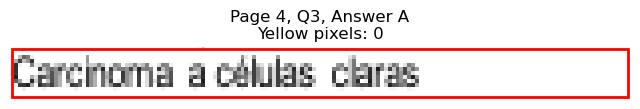

Page 4, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=128.5, y1=265.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 263
Page 4, Q3, B: Yellow percentage: 0.0%


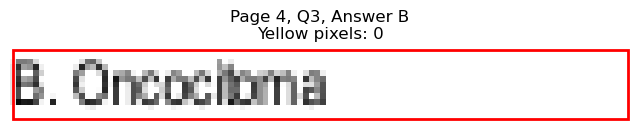

Page 4, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=143.6, y1=277.7
Page 4, Q3, C: Yellow pixels: 551
Page 4, Q3, C: Total non-white pixels: 923
Page 4, Q3, C: Yellow percentage: 59.7%


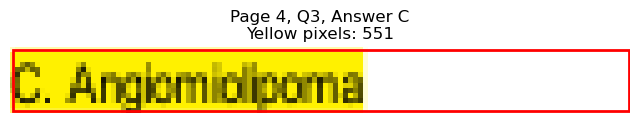

Page 4, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=389.0, y1=253.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 352
Page 4, Q3, D: Yellow percentage: 0.0%


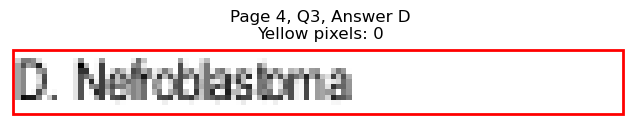

Page 4, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=419.0, y1=265.7
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 463
Page 4, Q3, E: Yellow percentage: 0.0%


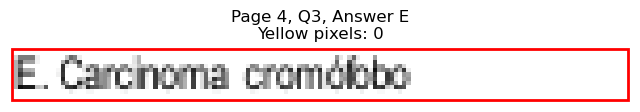


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=187.7, y1=314.5
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 517
Page 4, Q4, A: Yellow percentage: 0.0%


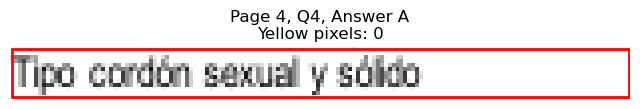

Page 4, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=118.7, y1=326.5
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 390
Page 4, Q4, B: Yellow percentage: 0.0%


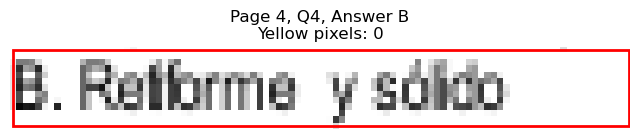

Page 4, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=142.0, y1=338.5
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 324
Page 4, Q4, C: Yellow percentage: 0.0%


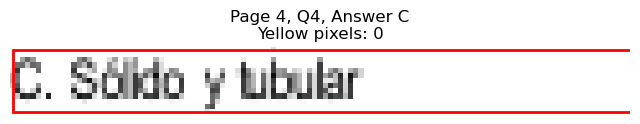

Page 4, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=401.0, y1=314.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 376
Page 4, Q4, D: Yellow percentage: 0.0%


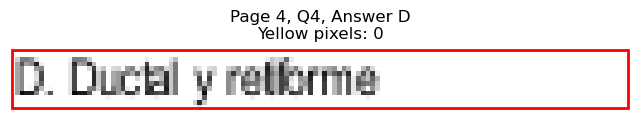

Page 4, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=393.6, y1=326.5
Page 4, Q4, E: Yellow pixels: 620
Page 4, Q4, E: Total non-white pixels: 910
Page 4, Q4, E: Yellow percentage: 68.1%


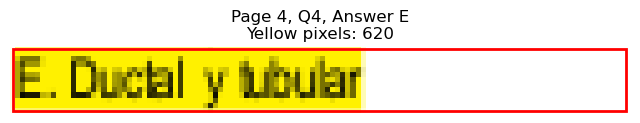


Page 4, Q4 - Selected Answer: E (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=132.2, y1=398.6
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 257
Page 4, Q5, A: Yellow percentage: 0.0%


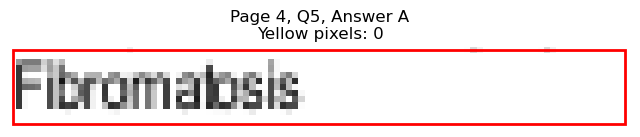

Page 4, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=196.7, y1=410.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 602
Page 4, Q5, B: Yellow percentage: 0.0%


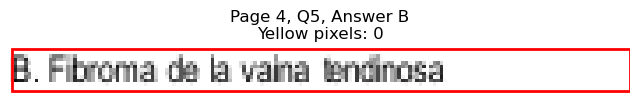

Page 4, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=167.5, y1=422.6
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 437
Page 4, Q5, C: Yellow percentage: 0.0%


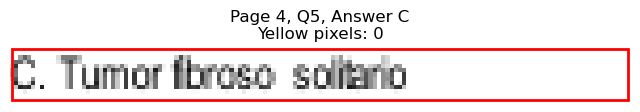

Page 4, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=419.8, y1=398.6
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 716
Page 4, Q5, D: Yellow percentage: 0.0%


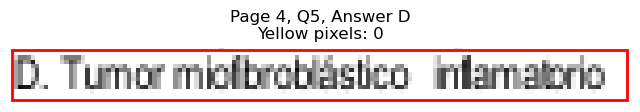

Page 4, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=430.4, y1=410.6
Page 4, Q5, E: Yellow pixels: 943
Page 4, Q5, E: Total non-white pixels: 1391
Page 4, Q5, E: Yellow percentage: 67.8%


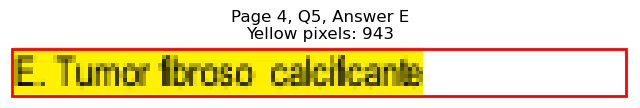


Page 4, Q5 - Selected Answer: E (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.6, y0=458.6, x1=116.5, y1=470.6
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 170
Page 4, Q6, A: Yellow percentage: 0.0%


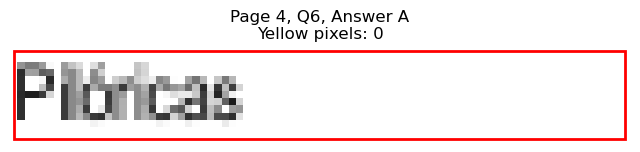

Page 4, Q6 - B: Detected box: x0=71.3, y0=470.6, x1=118.7, y1=482.6
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 244
Page 4, Q6, B: Yellow percentage: 0.0%


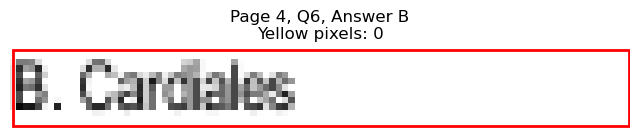

Page 4, Q6 - C: Detected box: x0=71.3, y0=483.4, x1=121.0, y1=495.4
Page 4, Q6, C: Yellow pixels: 422
Page 4, Q6, C: Total non-white pixels: 624
Page 4, Q6, C: Yellow percentage: 67.6%


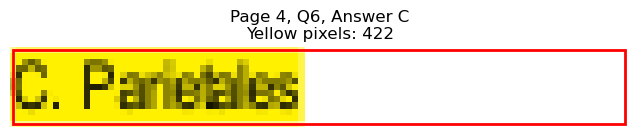

Page 4, Q6 - D: Detected box: x0=322.9, y0=458.6, x1=381.6, y1=470.6
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 305
Page 4, Q6, D: Yellow percentage: 0.0%


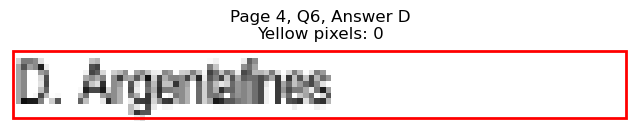

Page 4, Q6 - E: Detected box: x0=322.9, y0=470.6, x1=371.0, y1=482.6
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 211
Page 4, Q6, E: Yellow percentage: 0.0%


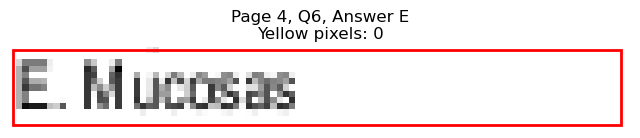


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=103.7, y1=531.4
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 100
Page 4, Q7, A: Yellow percentage: 0.0%


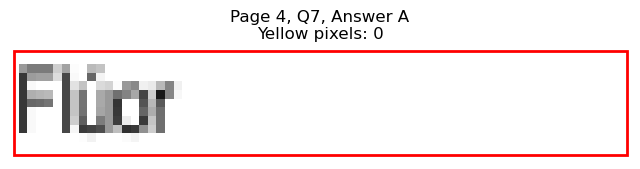

Page 4, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=128.5, y1=543.5
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 291
Page 4, Q7, B: Yellow percentage: 0.0%


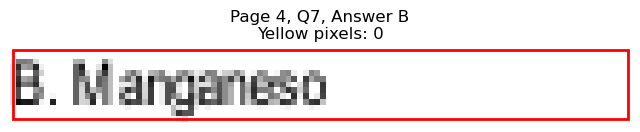

Page 4, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=121.7, y1=555.5
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 238
Page 4, Q7, C: Yellow percentage: 0.0%


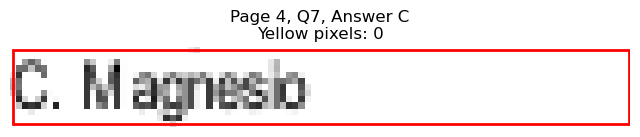

Page 4, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=364.3, y1=531.4
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 190
Page 4, Q7, D: Yellow percentage: 0.0%


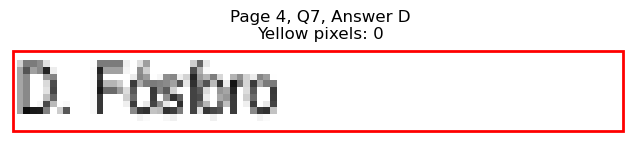

Page 4, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=350.8, y1=543.5
Page 4, Q7, E: Yellow pixels: 238
Page 4, Q7, E: Total non-white pixels: 351
Page 4, Q7, E: Yellow percentage: 67.8%


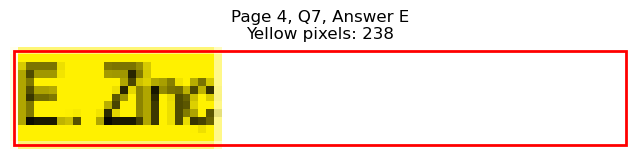


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=168.2, y1=591.5
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 409
Page 4, Q8, A: Yellow percentage: 0.0%


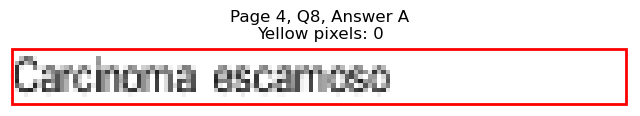

Page 4, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=153.3, y1=603.5
Page 4, Q8, B: Yellow pixels: 1113
Page 4, Q8, B: Total non-white pixels: 1638
Page 4, Q8, B: Yellow percentage: 67.9%


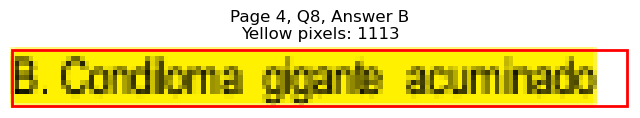

Page 4, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=165.9, y1=615.5
Page 4, Q8, C: Yellow pixels: 126
Page 4, Q8, C: Total non-white pixels: 551
Page 4, Q8, C: Yellow percentage: 22.9%


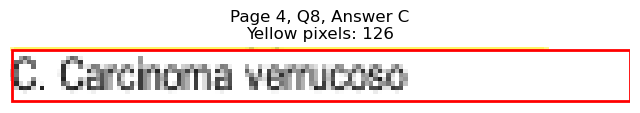

Page 4, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=407.8, y1=591.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 447
Page 4, Q8, D: Yellow percentage: 0.0%


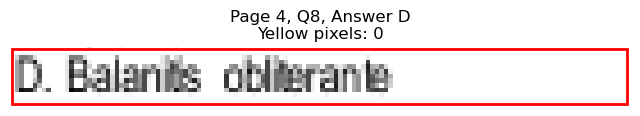

Page 4, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=379.3, y1=603.5
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 268
Page 4, Q8, E: Yellow percentage: 0.0%


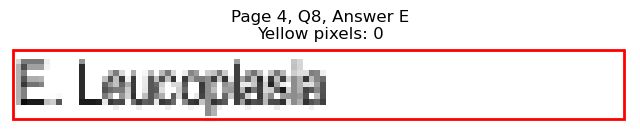


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=82.6, y0=651.5, x1=100.8, y1=663.6
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 82
Page 4, Q9, A: Yellow percentage: 0.0%


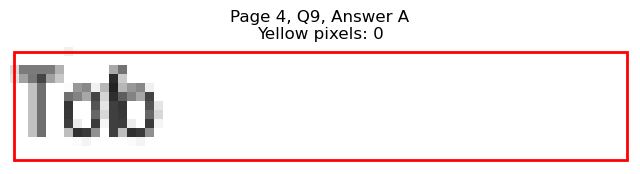

Page 4, Q9 - B: Detected box: x0=71.3, y0=663.5, x1=111.2, y1=675.6
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 193
Page 4, Q9, B: Yellow percentage: 0.0%


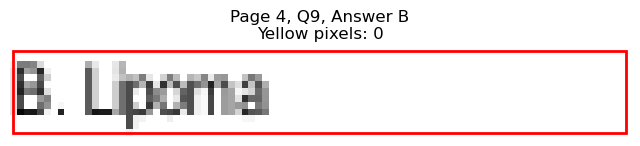

Page 4, Q9 - C: Detected box: x0=71.3, y0=676.3, x1=117.3, y1=688.3
Page 4, Q9, C: Yellow pixels: 344
Page 4, Q9, C: Total non-white pixels: 572
Page 4, Q9, C: Yellow percentage: 60.1%


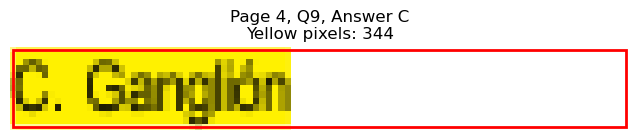

Page 4, Q9 - D: Detected box: x0=322.9, y0=651.5, x1=406.3, y1=663.6
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 416
Page 4, Q9, D: Yellow percentage: 0.0%


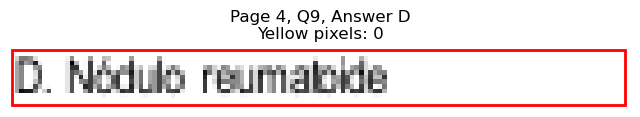

Page 4, Q9 - E: Detected box: x0=322.9, y0=663.5, x1=434.0, y1=675.6
Page 4, Q9, E: Yellow pixels: 0
Page 4, Q9, E: Total non-white pixels: 550
Page 4, Q9, E: Yellow percentage: 0.0%


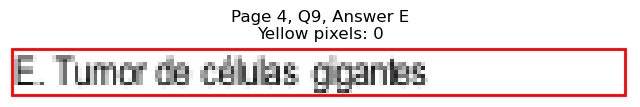


Page 4, Q9 - Selected Answer: C (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=82.6, y0=712.3, x1=266.5, y1=724.4
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 890
Page 4, Q10, A: Yellow percentage: 0.0%


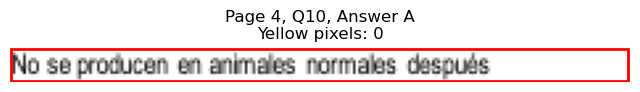

Page 4, Q10 - B: Detected box: x0=71.3, y0=736.4, x1=260.4, y1=748.4
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 884
Page 4, Q10, B: Yellow percentage: 0.0%


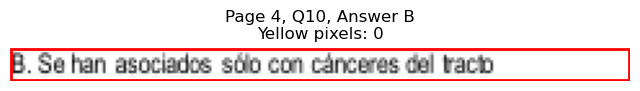

Page 4, Q10 - C: Detected box: x0=71.3, y0=760.4, x1=228.3, y1=772.4
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 832
Page 4, Q10, C: Yellow percentage: 0.0%


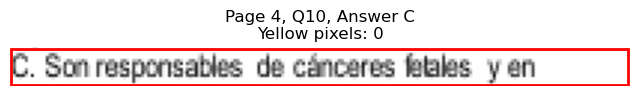

Page 4, Q10 - D: Detected box: x0=322.9, y0=712.3, x1=473.0, y1=724.4
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 1003
Page 4, Q10, D: Yellow percentage: 0.0%


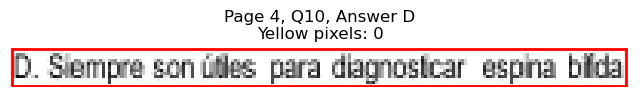

Page 4, Q10 - E: Detected box: x0=322.9, y0=724.3, x1=437.8, y1=736.4
Page 4, Q10, E: Yellow pixels: 1333
Page 4, Q10, E: Total non-white pixels: 2158
Page 4, Q10, E: Yellow percentage: 61.8%


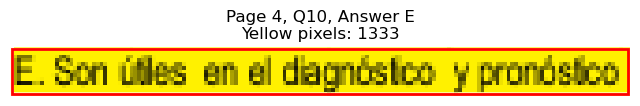


Page 4, Q10 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=147.2, y1=108.8
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 317
Page 5, Q1, A: Yellow percentage: 0.0%


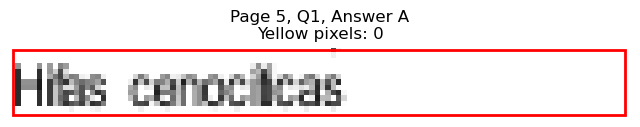

Page 5, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=219.2, y1=121.6
Page 5, Q1, B: Yellow pixels: 1584
Page 5, Q1, B: Total non-white pixels: 2262
Page 5, Q1, B: Yellow percentage: 70.0%


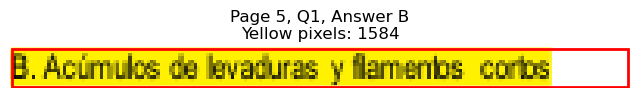

Page 5, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=133.0, y1=133.6
Page 5, Q1, C: Yellow pixels: 112
Page 5, Q1, C: Total non-white pixels: 394
Page 5, Q1, C: Yellow percentage: 28.4%


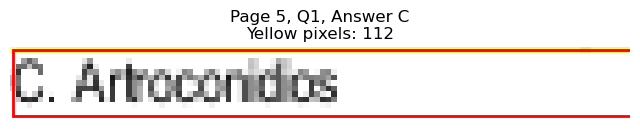

Page 5, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=425.8, y1=108.8
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 515
Page 5, Q1, D: Yellow percentage: 0.0%


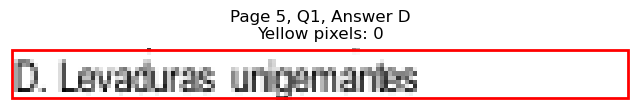

Page 5, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=431.0, y1=121.6
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 541
Page 5, Q1, E: Yellow percentage: 0.0%


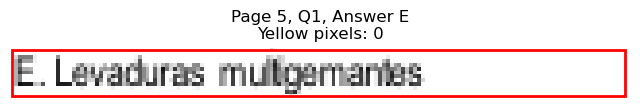


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=186.3, y1=169.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 527
Page 5, Q2, A: Yellow percentage: 0.0%


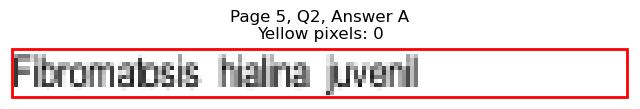

Page 5, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=149.6, y1=181.6
Page 5, Q2, B: Yellow pixels: 597
Page 5, Q2, B: Total non-white pixels: 1002
Page 5, Q2, B: Yellow percentage: 59.6%


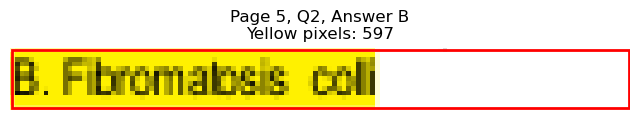

Page 5, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=145.7, y1=193.6
Page 5, Q2, C: Yellow pixels: 76
Page 5, Q2, C: Total non-white pixels: 425
Page 5, Q2, C: Yellow percentage: 17.9%


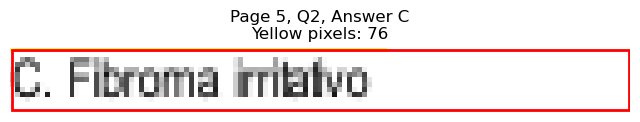

Page 5, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=426.5, y1=169.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 527
Page 5, Q2, D: Yellow percentage: 0.0%


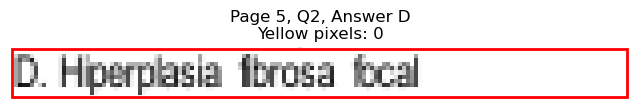

Page 5, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=394.3, y1=181.6
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 343
Page 5, Q2, E: Yellow percentage: 0.0%


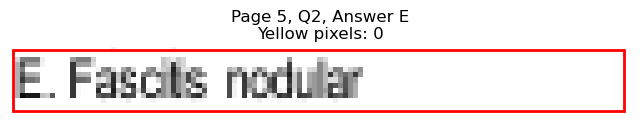


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.6, y0=217.6, x1=102.2, y1=229.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 89
Page 5, Q3, A: Yellow percentage: 0.0%


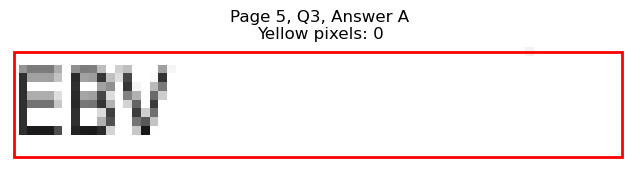

Page 5, Q3 - B: Detected box: x0=71.3, y0=229.6, x1=132.3, y1=241.7
Page 5, Q3, B: Yellow pixels: 471
Page 5, Q3, B: Total non-white pixels: 767
Page 5, Q3, B: Yellow percentage: 61.4%


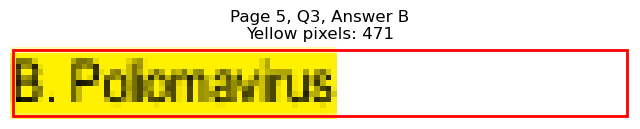

Page 5, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=102.2, y1=253.7
Page 5, Q3, C: Yellow pixels: 59
Page 5, Q3, C: Total non-white pixels: 175
Page 5, Q3, C: Yellow percentage: 33.7%


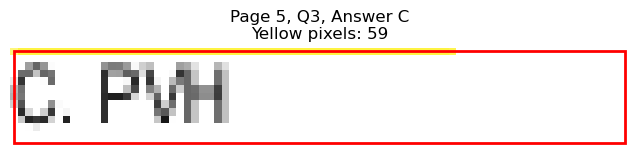

Page 5, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=364.3, y1=229.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 168
Page 5, Q3, D: Yellow percentage: 0.0%


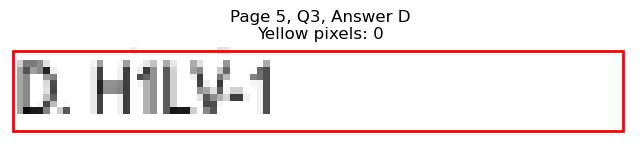

Page 5, Q3 - E: Detected box: x0=322.9, y0=229.6, x1=391.2, y1=241.7
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 301
Page 5, Q3, E: Yellow percentage: 0.0%


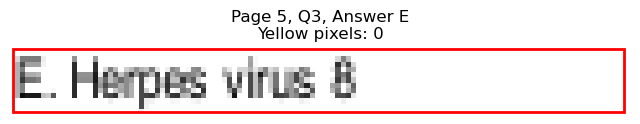


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.6, y0=277.7, x1=241.7, y1=289.7
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 790
Page 5, Q4, A: Yellow percentage: 0.0%


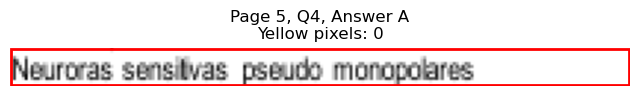

Page 5, Q4 - B: Detected box: x0=71.3, y0=289.7, x1=210.2, y1=301.8
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 704
Page 5, Q4, B: Yellow percentage: 0.0%


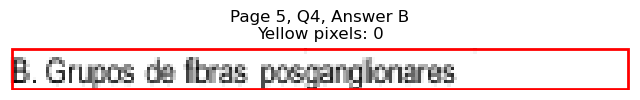

Page 5, Q4 - C: Detected box: x0=71.3, y0=302.5, x1=184.8, y1=314.5
Page 5, Q4, C: Yellow pixels: 1344
Page 5, Q4, C: Total non-white pixels: 1937
Page 5, Q4, C: Yellow percentage: 69.4%


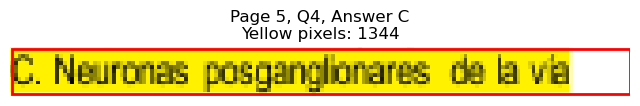

Page 5, Q4 - D: Detected box: x0=322.9, y0=277.7, x1=523.3, y1=289.7
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 956
Page 5, Q4, D: Yellow percentage: 0.0%


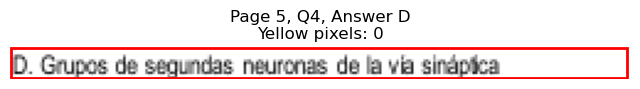

Page 5, Q4 - E: Detected box: x0=322.9, y0=289.7, x1=438.5, y1=301.8
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 848
Page 5, Q4, E: Yellow percentage: 0.0%


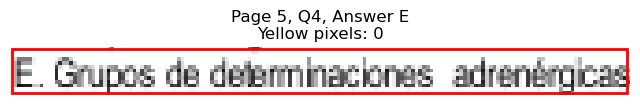


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=151.0, y1=374.6
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 338
Page 5, Q5, A: Yellow percentage: 0.0%


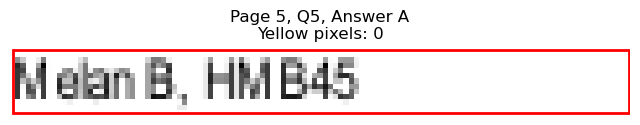

Page 5, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=144.2, y1=386.6
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 351
Page 5, Q5, B: Yellow percentage: 0.0%


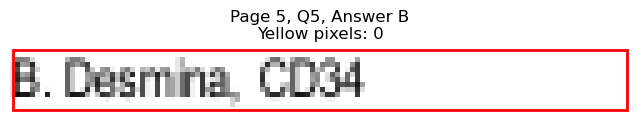

Page 5, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=127.7, y1=398.6
Page 5, Q5, C: Yellow pixels: 698
Page 5, Q5, C: Total non-white pixels: 1144
Page 5, Q5, C: Yellow percentage: 61.0%


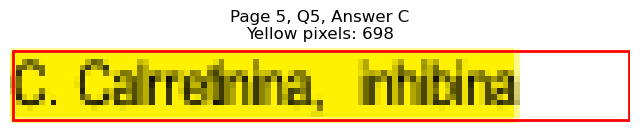

Page 5, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=374.0, y1=374.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 440
Page 5, Q5, D: Yellow percentage: 0.0%


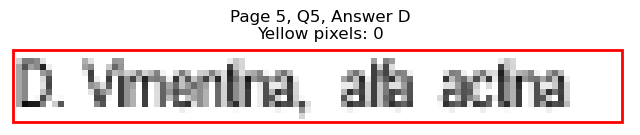

Page 5, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=383.7, y1=386.6
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 270
Page 5, Q5, E: Yellow percentage: 0.0%


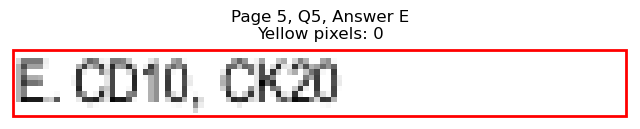


Page 5, Q5 - Selected Answer: C (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.6, y0=422.5, x1=133.8, y1=434.6
Page 5, Q6, A: Yellow pixels: 402
Page 5, Q6, A: Total non-white pixels: 650
Page 5, Q6, A: Yellow percentage: 61.8%


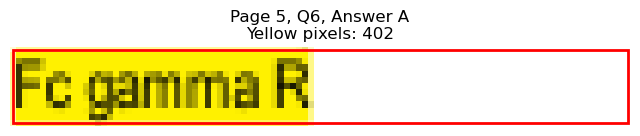

Page 5, Q6 - B: Detected box: x0=117.1, y0=434.6, x1=181.1, y1=446.6
Page 5, Q6, B: Yellow pixels: 14
Page 5, Q6, B: Total non-white pixels: 317
Page 5, Q6, B: Yellow percentage: 4.4%


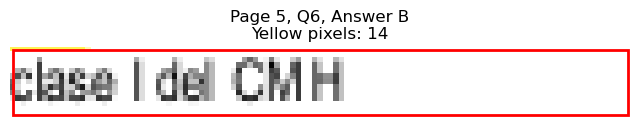

Page 5, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=145.7, y1=458.6
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 367
Page 5, Q6, C: Yellow percentage: 0.0%


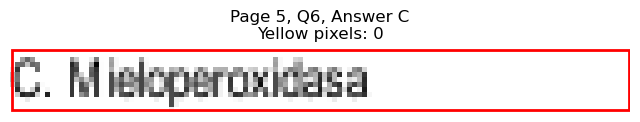

Page 5, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=434.7, y1=434.6
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 526
Page 5, Q6, D: Yellow percentage: 0.0%


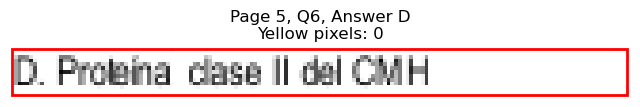

Page 5, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=409.4, y1=446.6
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 412
Page 5, Q6, E: Yellow percentage: 0.0%


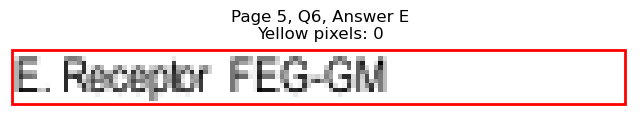


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.6, y0=483.4, x1=145.7, y1=495.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 289
Page 5, Q7, A: Yellow percentage: 0.0%


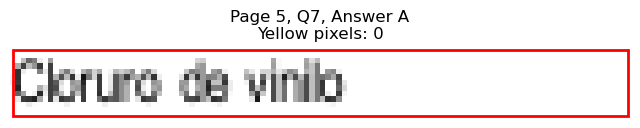

Page 5, Q7 - B: Detected box: x0=71.3, y0=495.4, x1=106.7, y1=507.4
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 176
Page 5, Q7, B: Yellow percentage: 0.0%


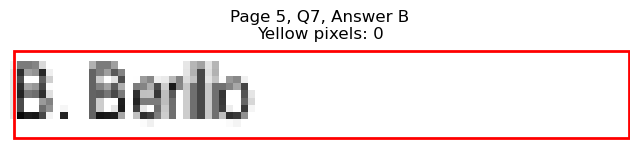

Page 5, Q7 - C: Detected box: x0=71.3, y0=507.4, x1=118.0, y1=519.4
Page 5, Q7, C: Yellow pixels: 420
Page 5, Q7, C: Total non-white pixels: 585
Page 5, Q7, C: Yellow percentage: 71.8%


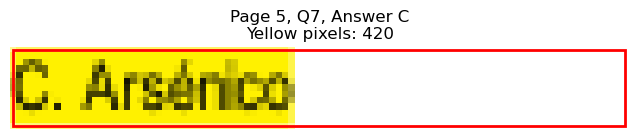

Page 5, Q7 - D: Detected box: x0=322.9, y0=483.4, x1=369.5, y1=495.4
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 223
Page 5, Q7, D: Yellow percentage: 0.0%


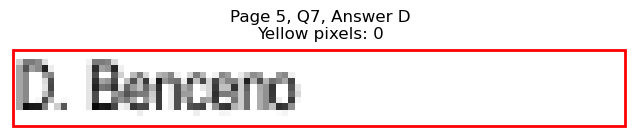

Page 5, Q7 - E: Detected box: x0=322.9, y0=495.4, x1=365.8, y1=507.4
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 197
Page 5, Q7, E: Yellow percentage: 0.0%


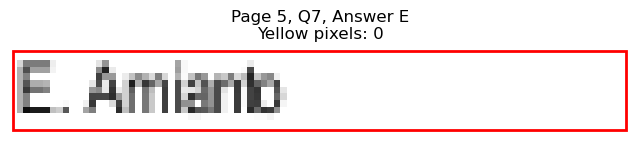


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.6, y0=543.4, x1=145.8, y1=555.5
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 333
Page 5, Q8, A: Yellow percentage: 0.0%


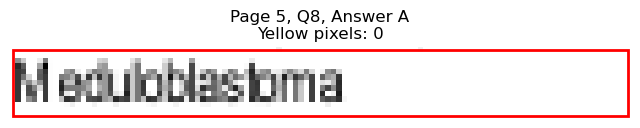

Page 5, Q8 - B: Detected box: x0=71.3, y0=555.4, x1=133.7, y1=567.5
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 299
Page 5, Q8, B: Yellow percentage: 0.0%


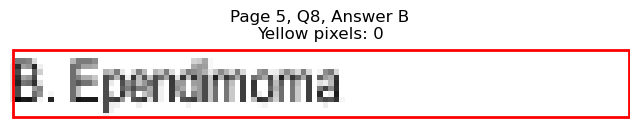

Page 5, Q8 - C: Detected box: x0=71.3, y0=567.5, x1=149.5, y1=579.5
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 383
Page 5, Q8, C: Yellow percentage: 0.0%


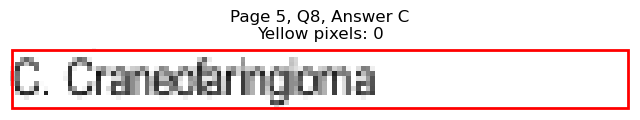

Page 5, Q8 - D: Detected box: x0=322.9, y0=543.4, x1=382.4, y1=555.5
Page 5, Q8, D: Yellow pixels: 492
Page 5, Q8, D: Total non-white pixels: 754
Page 5, Q8, D: Yellow percentage: 65.3%


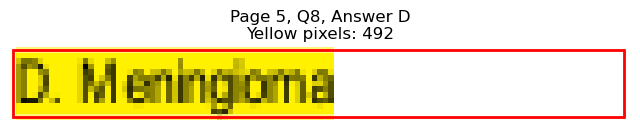

Page 5, Q8 - E: Detected box: x0=322.9, y0=555.4, x1=404.8, y1=567.5
Page 5, Q8, E: Yellow pixels: 57
Page 5, Q8, E: Total non-white pixels: 497
Page 5, Q8, E: Yellow percentage: 11.5%


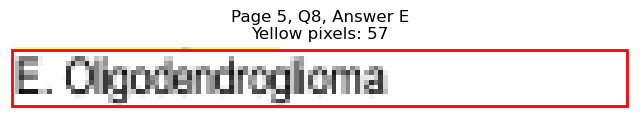


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=82.6, y0=603.5, x1=143.5, y1=615.5
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 295
Page 5, Q9, A: Yellow percentage: 0.0%


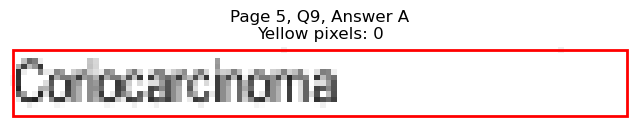

Page 5, Q9 - B: Detected box: x0=71.3, y0=615.5, x1=172.0, y1=627.5
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 474
Page 5, Q9, B: Yellow percentage: 0.0%


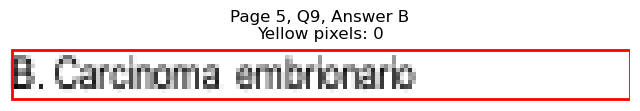

Page 5, Q9 - C: Detected box: x0=71.3, y0=627.5, x1=152.5, y1=639.6
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 371
Page 5, Q9, C: Yellow percentage: 0.0%


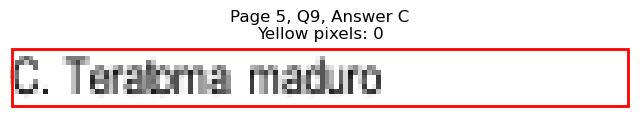

Page 5, Q9 - D: Detected box: x0=322.9, y0=603.5, x1=419.9, y1=615.5
Page 5, Q9, D: Yellow pixels: 874
Page 5, Q9, D: Total non-white pixels: 1248
Page 5, Q9, D: Yellow percentage: 70.0%


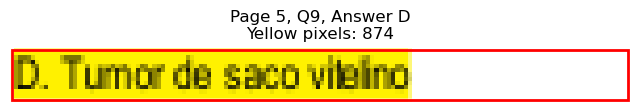

Page 5, Q9 - E: Detected box: x0=322.9, y0=615.5, x1=376.3, y1=627.5
Page 5, Q9, E: Yellow pixels: 94
Page 5, Q9, E: Total non-white pixels: 358
Page 5, Q9, E: Yellow percentage: 26.3%


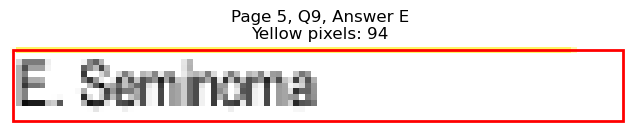


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=82.6, y0=663.5, x1=128.5, y1=675.6
Page 5, Q10, A: Yellow pixels: 311
Page 5, Q10, A: Total non-white pixels: 589
Page 5, Q10, A: Yellow percentage: 52.8%


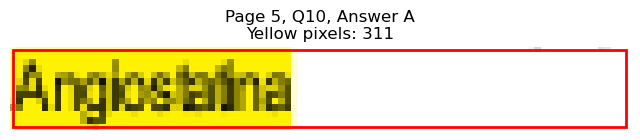

Page 5, Q10 - B: Detected box: x0=71.3, y0=676.3, x1=217.7, y1=688.3
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 764
Page 5, Q10, B: Yellow percentage: 0.0%


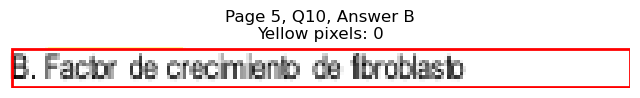

Page 5, Q10 - C: Detected box: x0=71.3, y0=688.3, x1=196.7, y1=700.3
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 587
Page 5, Q10, C: Yellow percentage: 0.0%


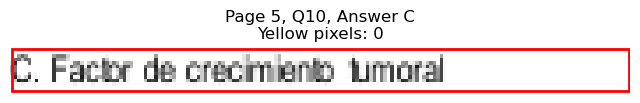

Page 5, Q10 - D: Detected box: x0=322.9, y0=663.5, x1=503.8, y1=675.6
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 877
Page 5, Q10, D: Yellow percentage: 0.0%


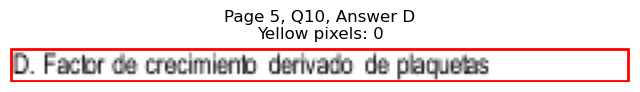

Page 5, Q10 - E: Detected box: x0=322.9, y0=676.3, x1=377.0, y1=688.3
Page 5, Q10, E: Yellow pixels: 0
Page 5, Q10, E: Total non-white pixels: 285
Page 5, Q10, E: Yellow percentage: 0.0%


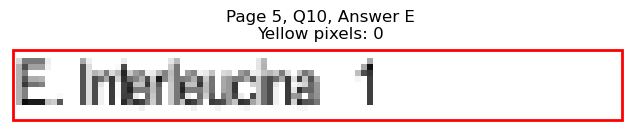


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=82.6, y0=724.3, x1=145.1, y1=736.4
Page 5, Q11, A: Yellow pixels: 485
Page 5, Q11, A: Total non-white pixels: 793
Page 5, Q11, A: Yellow percentage: 61.2%


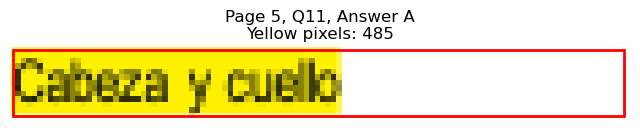

Page 5, Q11 - B: Detected box: x0=71.3, y0=736.4, x1=133.7, y1=748.4
Page 5, Q11, B: Yellow pixels: 1
Page 5, Q11, B: Total non-white pixels: 388
Page 5, Q11, B: Yellow percentage: 0.3%


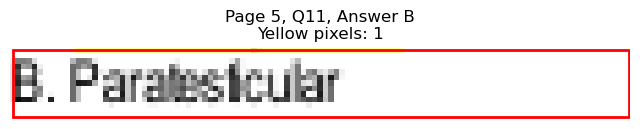

Page 5, Q11 - C: Detected box: x0=71.3, y0=748.4, x1=105.2, y1=760.4
Page 5, Q11, C: Yellow pixels: 0
Page 5, Q11, C: Total non-white pixels: 139
Page 5, Q11, C: Yellow percentage: 0.0%


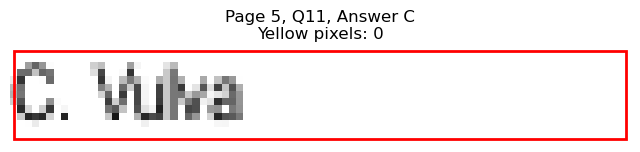

Page 5, Q11 - D: Detected box: x0=322.9, y0=724.3, x1=361.3, y1=736.4
Page 5, Q11, D: Yellow pixels: 0
Page 5, Q11, D: Total non-white pixels: 186
Page 5, Q11, D: Yellow percentage: 0.0%


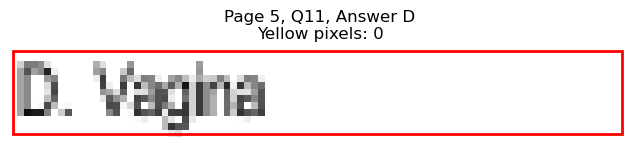

Page 5, Q11 - E: Detected box: x0=322.9, y0=736.4, x1=355.4, y1=748.4
Page 5, Q11, E: Yellow pixels: 0
Page 5, Q11, E: Total non-white pixels: 184
Page 5, Q11, E: Yellow percentage: 0.0%


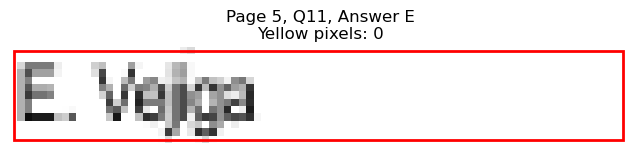


Page 5, Q11 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 11 questions
Page 6, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=166.0, y1=108.8
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 408
Page 6, Q1, A: Yellow percentage: 0.0%


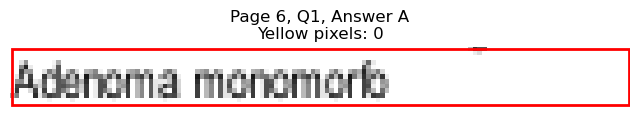

Page 6, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=193.0, y1=121.6
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 596
Page 6, Q1, B: Yellow percentage: 0.0%


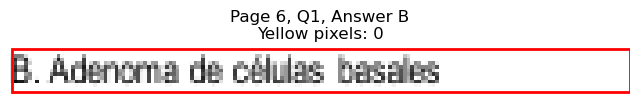

Page 6, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=129.2, y1=133.6
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 272
Page 6, Q1, C: Yellow percentage: 0.0%


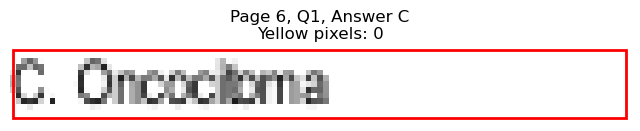

Page 6, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=390.6, y1=108.8
Page 6, Q1, D: Yellow pixels: 492
Page 6, Q1, D: Total non-white pixels: 871
Page 6, Q1, D: Yellow percentage: 56.5%


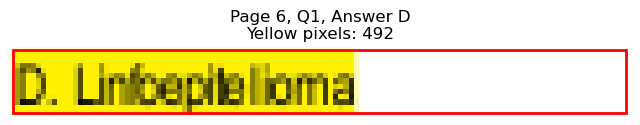

Page 6, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=402.5, y1=121.6
Page 6, Q1, E: Yellow pixels: 65
Page 6, Q1, E: Total non-white pixels: 434
Page 6, Q1, E: Yellow percentage: 15.0%


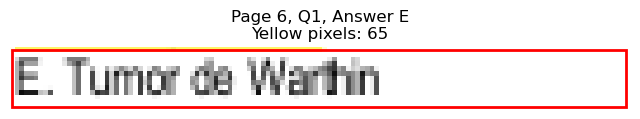


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=113.5, y1=169.6
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 151
Page 6, Q2, A: Yellow percentage: 0.0%


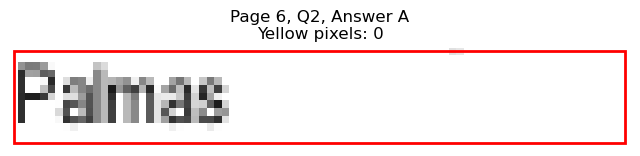

Page 6, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=115.7, y1=181.6
Page 6, Q2, B: Yellow pixels: 541
Page 6, Q2, B: Total non-white pixels: 884
Page 6, Q2, B: Yellow percentage: 61.2%


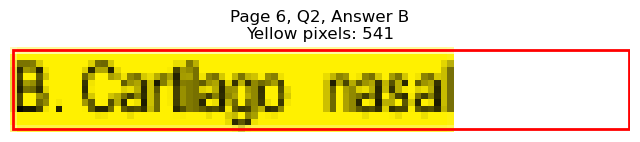

Page 6, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=112.0, y1=193.6
Page 6, Q2, C: Yellow pixels: 68
Page 6, Q2, C: Total non-white pixels: 241
Page 6, Q2, C: Yellow percentage: 28.2%


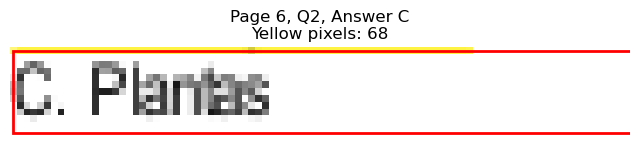

Page 6, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=366.5, y1=169.6
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 219
Page 6, Q2, D: Yellow percentage: 0.0%


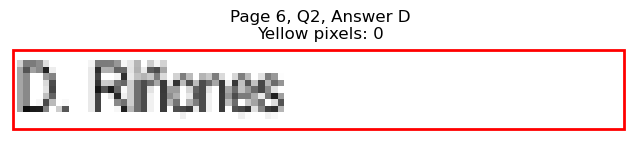

Page 6, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=372.5, y1=181.6
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 227
Page 6, Q2, E: Yellow percentage: 0.0%


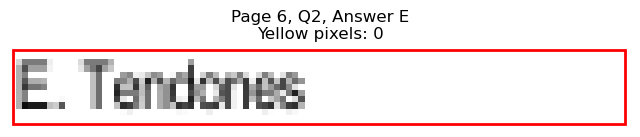


Page 6, Q2 - Selected Answer: B (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.6, y0=217.6, x1=94.7, y1=229.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 53
Page 6, Q3, A: Yellow percentage: 0.0%


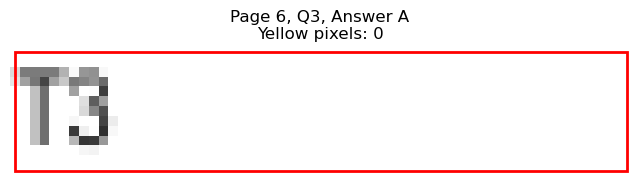

Page 6, Q3 - B: Detected box: x0=71.3, y0=229.6, x1=94.0, y1=241.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 78
Page 6, Q3, B: Yellow percentage: 0.0%


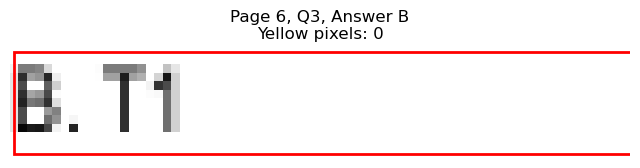

Page 6, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=94.8, y1=253.7
Page 6, Q3, C: Yellow pixels: 188
Page 6, Q3, C: Total non-white pixels: 286
Page 6, Q3, C: Yellow percentage: 65.7%


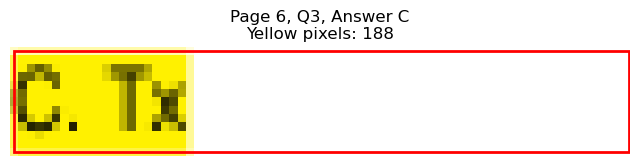

Page 6, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=346.3, y1=229.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 95
Page 6, Q3, D: Yellow percentage: 0.0%


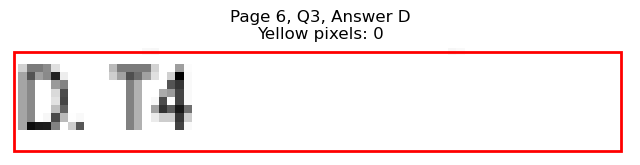

Page 6, Q3 - E: Detected box: x0=322.9, y0=229.6, x1=345.5, y1=241.7
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 88
Page 6, Q3, E: Yellow percentage: 0.0%


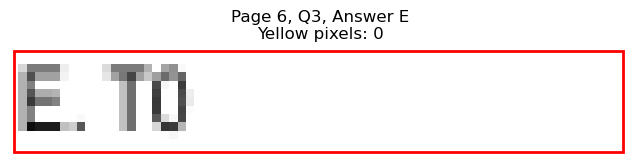


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.6, y0=277.7, x1=129.2, y1=289.7
Page 6, Q4, A: Yellow pixels: 538
Page 6, Q4, A: Total non-white pixels: 936
Page 6, Q4, A: Yellow percentage: 57.5%


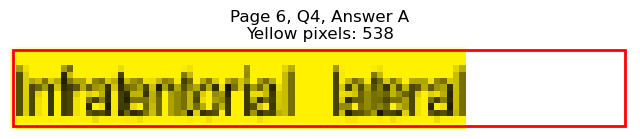

Page 6, Q4 - B: Detected box: x0=71.3, y0=289.7, x1=127.0, y1=301.8
Page 6, Q4, B: Yellow pixels: 71
Page 6, Q4, B: Total non-white pixels: 352
Page 6, Q4, B: Yellow percentage: 20.2%


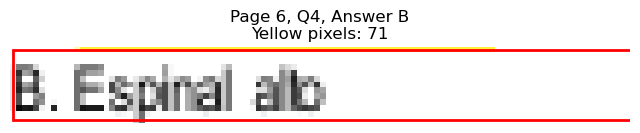

Page 6, Q4 - C: Detected box: x0=71.3, y0=302.5, x1=130.7, y1=314.5
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 288
Page 6, Q4, C: Yellow percentage: 0.0%


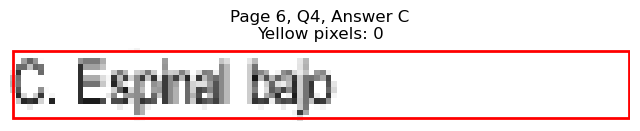

Page 6, Q4 - D: Detected box: x0=322.9, y0=277.7, x1=386.0, y1=289.7
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 340
Page 6, Q4, D: Yellow percentage: 0.0%


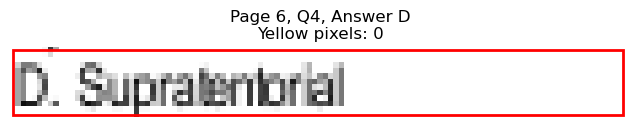

Page 6, Q4 - E: Detected box: x0=322.9, y0=289.7, x1=380.0, y1=301.8
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 437
Page 6, Q4, E: Yellow percentage: 0.0%


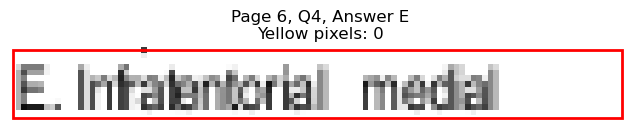


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=134.6, y1=374.6
Page 6, Q5, A: Yellow pixels: 426
Page 6, Q5, A: Total non-white pixels: 663
Page 6, Q5, A: Yellow percentage: 64.3%


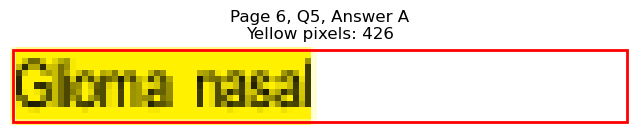

Page 6, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=133.7, y1=386.6
Page 6, Q5, B: Yellow pixels: 49
Page 6, Q5, B: Total non-white pixels: 357
Page 6, Q5, B: Yellow percentage: 13.7%


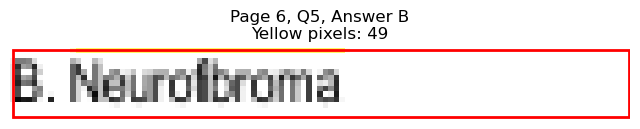

Page 6, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=163.7, y1=398.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 445
Page 6, Q5, C: Yellow percentage: 0.0%


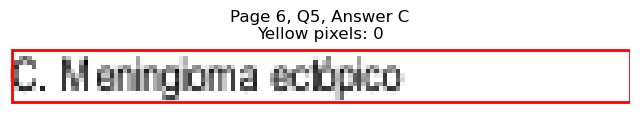

Page 6, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=383.0, y1=374.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 310
Page 6, Q5, D: Yellow percentage: 0.0%


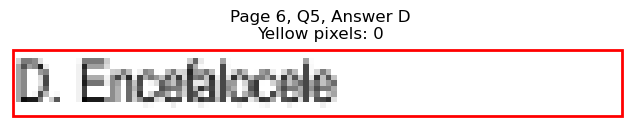

Page 6, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=413.8, y1=386.6
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 447
Page 6, Q5, E: Yellow percentage: 0.0%


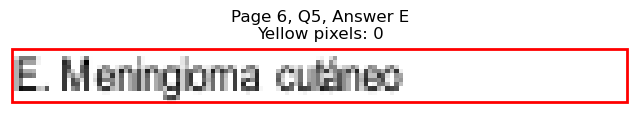


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.6, y0=422.5, x1=135.2, y1=434.6
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 279
Page 6, Q6, A: Yellow percentage: 0.0%


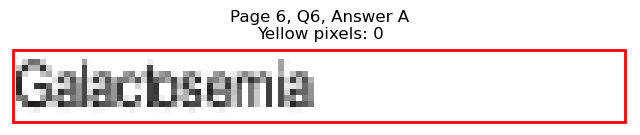

Page 6, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=156.2, y1=446.6
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 450
Page 6, Q6, B: Yellow percentage: 0.0%


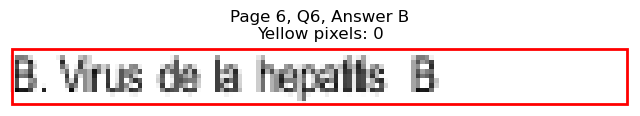

Page 6, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=162.2, y1=458.6
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 452
Page 6, Q6, C: Yellow percentage: 0.0%


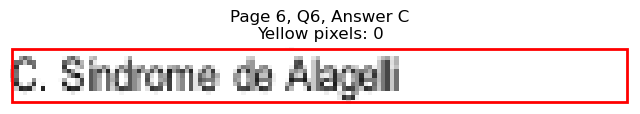

Page 6, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=420.7, y1=434.6
Page 6, Q6, D: Yellow pixels: 749
Page 6, Q6, D: Total non-white pixels: 1261
Page 6, Q6, D: Yellow percentage: 59.4%


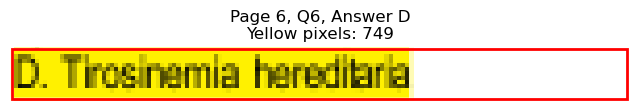

Page 6, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=398.7, y1=446.6
Page 6, Q6, E: Yellow pixels: 95
Page 6, Q6, E: Total non-white pixels: 467
Page 6, Q6, E: Yellow percentage: 20.3%


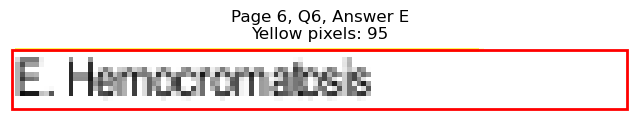


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.6, y0=483.4, x1=154.7, y1=495.4
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 349
Page 6, Q7, A: Yellow percentage: 0.0%


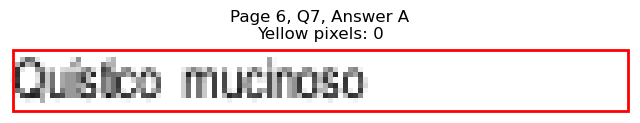

Page 6, Q7 - B: Detected box: x0=71.3, y0=495.4, x1=158.5, y1=507.4
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 421
Page 6, Q7, B: Yellow percentage: 0.0%


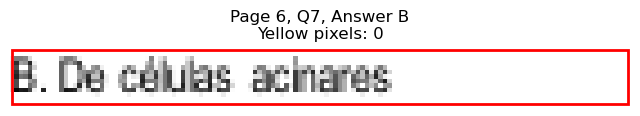

Page 6, Q7 - C: Detected box: x0=71.3, y0=507.4, x1=143.5, y1=519.4
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 325
Page 6, Q7, C: Yellow percentage: 0.0%


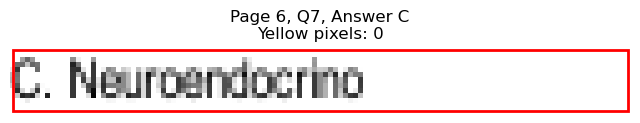

Page 6, Q7 - D: Detected box: x0=322.9, y0=483.4, x1=401.8, y1=495.4
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 415
Page 6, Q7, D: Yellow percentage: 0.0%


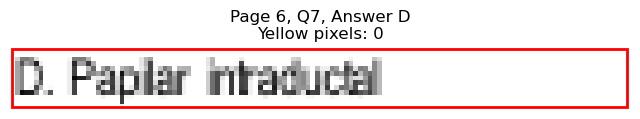

Page 6, Q7 - E: Detected box: x0=322.9, y0=495.4, x1=358.3, y1=507.4
Page 6, Q7, E: Yellow pixels: 299
Page 6, Q7, E: Total non-white pixels: 442
Page 6, Q7, E: Yellow percentage: 67.6%


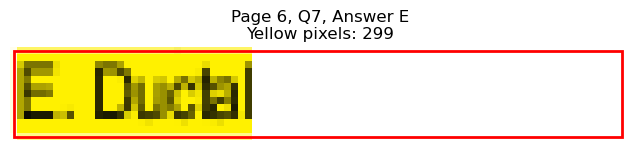


Page 6, Q7 - Selected Answer: E (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.6, y0=543.4, x1=123.2, y1=555.5
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 204
Page 6, Q8, A: Yellow percentage: 0.0%


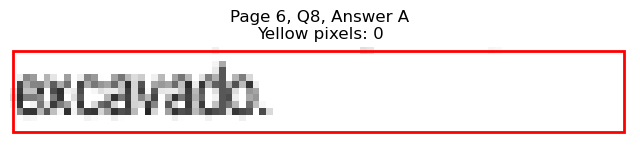

Page 6, Q8 - B: Detected box: x0=71.3, y0=555.4, x1=106.0, y1=567.5
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 157
Page 6, Q8, B: Yellow percentage: 0.0%


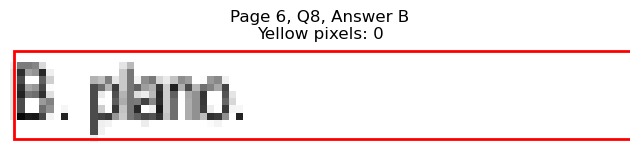

Page 6, Q8 - C: Detected box: x0=71.3, y0=567.5, x1=155.6, y1=579.5
Page 6, Q8, C: Yellow pixels: 732
Page 6, Q8, C: Total non-white pixels: 1079
Page 6, Q8, C: Yellow percentage: 67.8%


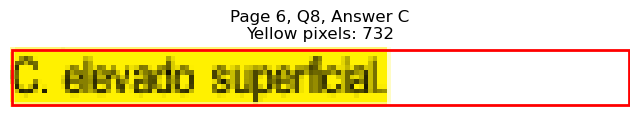

Page 6, Q8 - D: Detected box: x0=322.9, y0=543.4, x1=414.5, y1=555.5
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 455
Page 6, Q8, D: Yellow percentage: 0.0%


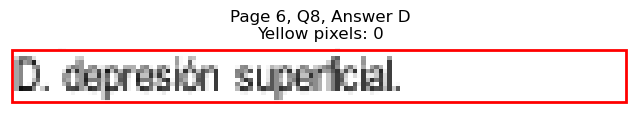

Page 6, Q8 - E: Detected box: x0=322.9, y0=555.4, x1=386.0, y1=567.5
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 314
Page 6, Q8, E: Yellow percentage: 0.0%


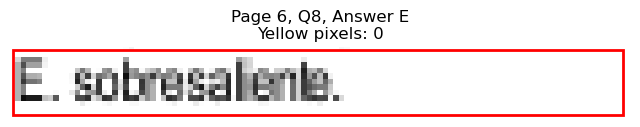


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.6, y0=627.5, x1=115.7, y1=639.6
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 197
Page 6, Q9, A: Yellow percentage: 0.0%


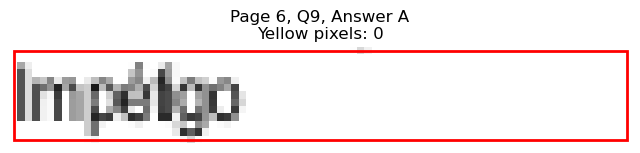

Page 6, Q9 - B: Detected box: x0=71.3, y0=639.5, x1=132.3, y1=651.6
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 293
Page 6, Q9, B: Yellow percentage: 0.0%


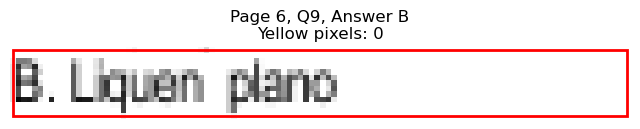

Page 6, Q9 - C: Detected box: x0=71.3, y0=651.5, x1=155.5, y1=663.6
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 543
Page 6, Q9, C: Yellow percentage: 0.0%


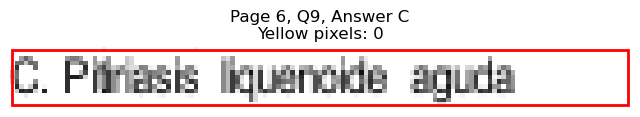

Page 6, Q9 - D: Detected box: x0=322.9, y0=627.5, x1=382.4, y1=639.6
Page 6, Q9, D: Yellow pixels: 515
Page 6, Q9, D: Total non-white pixels: 754
Page 6, Q9, D: Yellow percentage: 68.3%


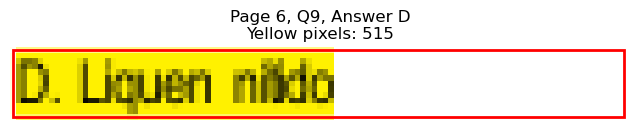

Page 6, Q9 - E: Detected box: x0=322.9, y0=639.5, x1=395.8, y1=651.6
Page 6, Q9, E: Yellow pixels: 57
Page 6, Q9, E: Total non-white pixels: 557
Page 6, Q9, E: Yellow percentage: 10.2%


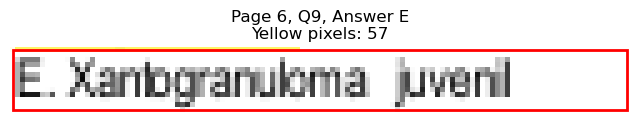


Page 6, Q9 - Selected Answer: D (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=82.6, y0=688.3, x1=193.0, y1=700.3
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 518
Page 6, Q10, A: Yellow percentage: 0.0%


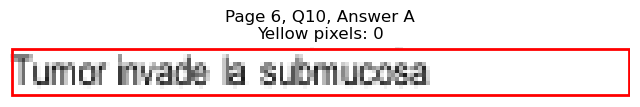

Page 6, Q10 - B: Detected box: x0=71.3, y0=700.3, x1=177.2, y1=712.3
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 502
Page 6, Q10, B: Yellow percentage: 0.0%


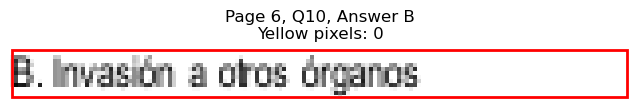

Page 6, Q10 - C: Detected box: x0=71.3, y0=712.3, x1=166.0, y1=724.4
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 609
Page 6, Q10, C: Yellow percentage: 0.0%


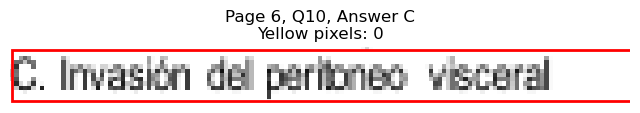

Page 6, Q10 - D: Detected box: x0=322.9, y0=688.3, x1=504.8, y1=700.3
Page 6, Q10, D: Yellow pixels: 1478
Page 6, Q10, D: Total non-white pixels: 2353
Page 6, Q10, D: Yellow percentage: 62.8%


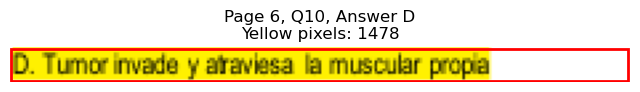

Page 6, Q10 - E: Detected box: x0=322.9, y0=700.3, x1=501.5, y1=712.3
Page 6, Q10, E: Yellow pixels: 3
Page 6, Q10, E: Total non-white pixels: 990
Page 6, Q10, E: Yellow percentage: 0.3%


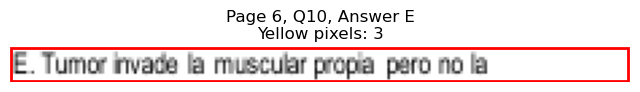


Page 6, Q10 - Selected Answer: D (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=82.6, y0=748.4, x1=112.0, y1=760.4
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 152
Page 6, Q11, A: Yellow percentage: 0.0%


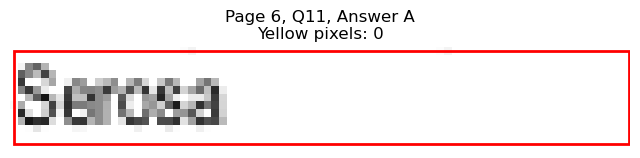

Page 6, Q11 - B: Detected box: x0=71.3, y0=760.4, x1=166.8, y1=772.4
Page 6, Q11, B: Yellow pixels: 857
Page 6, Q11, B: Total non-white pixels: 1222
Page 6, Q11, B: Yellow percentage: 70.1%


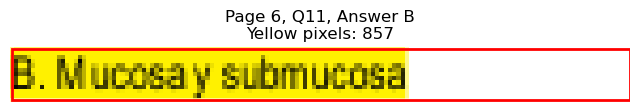

Page 6, Q11 - C: Detected box: x0=71.3, y0=772.4, x1=130.0, y1=784.4
Page 6, Q11, C: Yellow pixels: 92
Page 6, Q11, C: Total non-white pixels: 362
Page 6, Q11, C: Yellow percentage: 25.4%


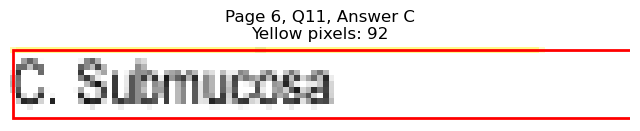

Page 6, Q11 - D: Detected box: x0=322.9, y0=748.4, x1=383.8, y1=760.4
Page 6, Q11, D: Yellow pixels: 0
Page 6, Q11, D: Total non-white pixels: 314
Page 6, Q11, D: Yellow percentage: 0.0%


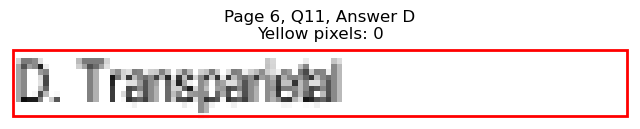

Page 6, Q11 - E: Detected box: x0=322.9, y0=760.4, x1=373.4, y1=772.4
Page 6, Q11, E: Yellow pixels: 0
Page 6, Q11, E: Total non-white pixels: 213
Page 6, Q11, E: Yellow percentage: 0.0%


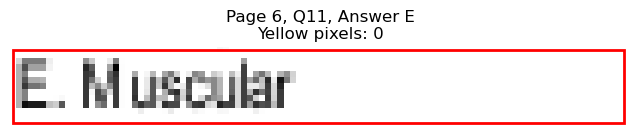


Page 6, Q11 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=94.0, y1=108.8
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 61
Page 7, Q1, A: Yellow percentage: 0.0%


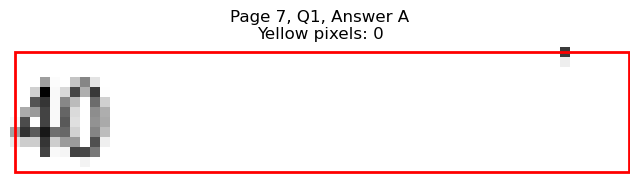

Page 7, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=93.2, y1=121.6
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 98
Page 7, Q1, B: Yellow percentage: 0.0%


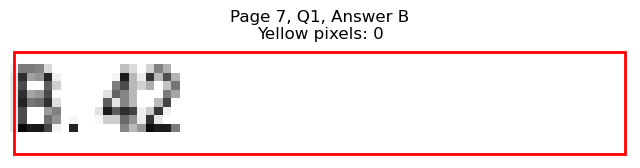

Page 7, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=89.5, y1=133.6
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 62
Page 7, Q1, C: Yellow percentage: 0.0%


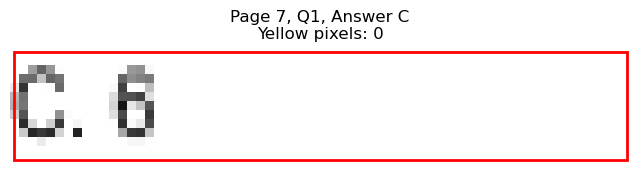

Page 7, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=345.6, y1=108.8
Page 7, Q1, D: Yellow pixels: 167
Page 7, Q1, D: Total non-white pixels: 286
Page 7, Q1, D: Yellow percentage: 58.4%


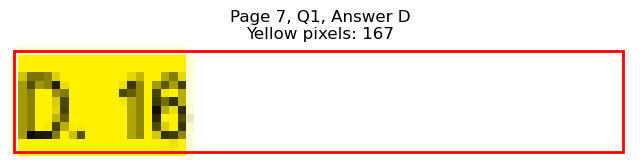

Page 7, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=344.8, y1=121.6
Page 7, Q1, E: Yellow pixels: 20
Page 7, Q1, E: Total non-white pixels: 96
Page 7, Q1, E: Yellow percentage: 20.8%


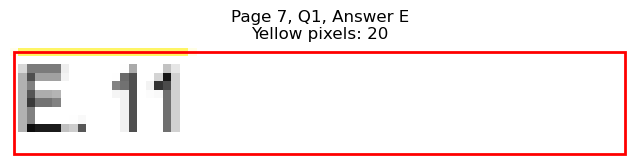


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=118.0, y1=193.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 175
Page 7, Q2, A: Yellow percentage: 0.0%


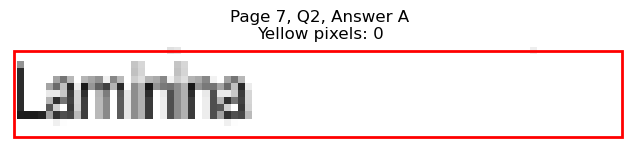

Page 7, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=128.5, y1=205.6
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 289
Page 7, Q2, B: Yellow percentage: 0.0%


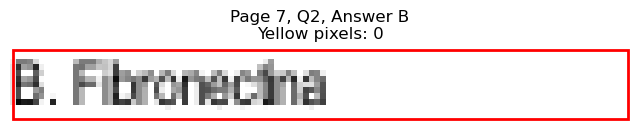

Page 7, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=115.7, y1=217.7
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 214
Page 7, Q2, C: Yellow percentage: 0.0%


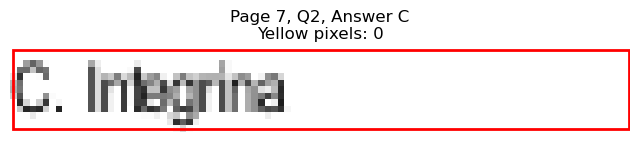

Page 7, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=371.1, y1=193.6
Page 7, Q2, D: Yellow pixels: 358
Page 7, Q2, D: Total non-white pixels: 611
Page 7, Q2, D: Yellow percentage: 58.6%


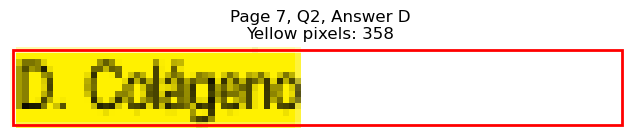

Page 7, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=364.3, y1=205.6
Page 7, Q2, E: Yellow pixels: 46
Page 7, Q2, E: Total non-white pixels: 250
Page 7, Q2, E: Yellow percentage: 18.4%


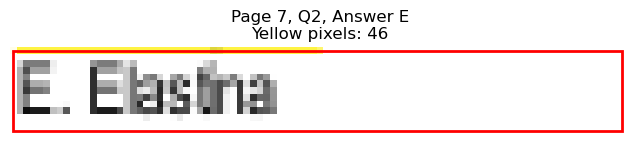


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=148.7, y1=253.7
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 340
Page 7, Q3, A: Yellow percentage: 0.0%


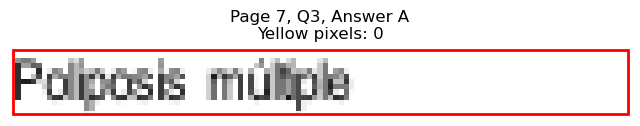

Page 7, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=138.3, y1=265.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 329
Page 7, Q3, B: Yellow percentage: 0.0%


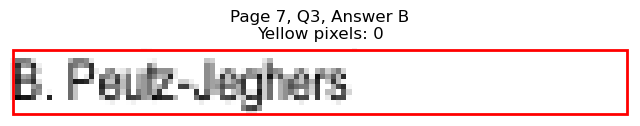

Page 7, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=107.5, y1=277.7
Page 7, Q3, C: Yellow pixels: 305
Page 7, Q3, C: Total non-white pixels: 457
Page 7, Q3, C: Yellow percentage: 66.7%


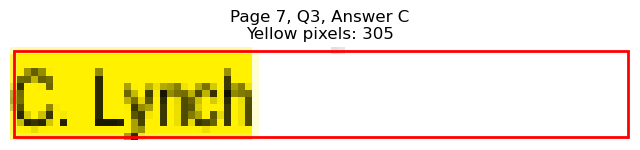

Page 7, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=379.3, y1=253.7
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 252
Page 7, Q3, D: Yellow percentage: 0.0%


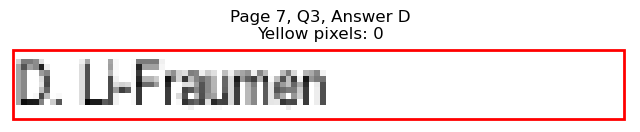

Page 7, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=392.8, y1=265.7
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 355
Page 7, Q3, E: Yellow percentage: 0.0%


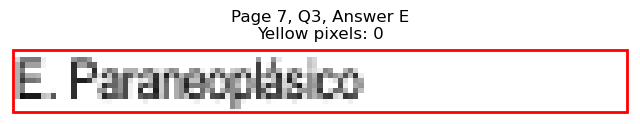


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=106.0, y1=314.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 102
Page 7, Q4, A: Yellow percentage: 0.0%


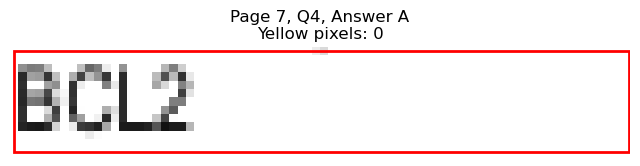

Page 7, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=106.7, y1=326.5
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 173
Page 7, Q4, B: Yellow percentage: 0.0%


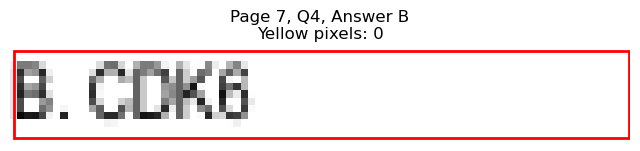

Page 7, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=106.0, y1=338.5
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 125
Page 7, Q4, C: Yellow percentage: 0.0%


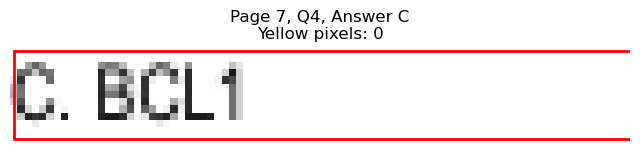

Page 7, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=356.8, y1=314.5
Page 7, Q4, D: Yellow pixels: 303
Page 7, Q4, D: Total non-white pixels: 429
Page 7, Q4, D: Yellow percentage: 70.6%


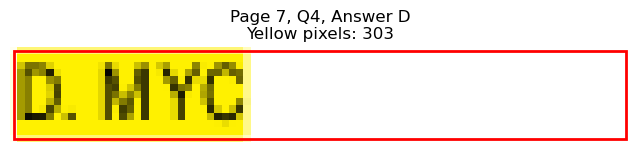

Page 7, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=356.7, y1=326.5
Page 7, Q4, E: Yellow pixels: 31
Page 7, Q4, E: Total non-white pixels: 179
Page 7, Q4, E: Yellow percentage: 17.3%


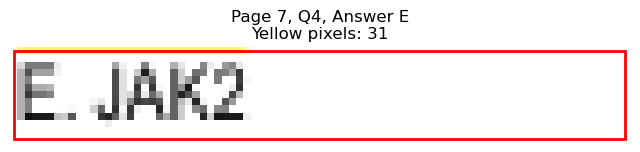


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=124.0, y1=374.6
Page 7, Q5, A: Yellow pixels: 333
Page 7, Q5, A: Total non-white pixels: 520
Page 7, Q5, A: Yellow percentage: 64.0%


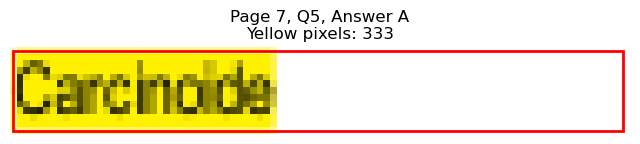

Page 7, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=172.7, y1=386.6
Page 7, Q5, B: Yellow pixels: 39
Page 7, Q5, B: Total non-white pixels: 570
Page 7, Q5, B: Yellow percentage: 6.8%


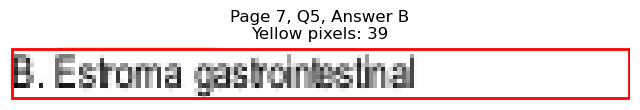

Page 7, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=113.5, y1=398.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 175
Page 7, Q5, C: Yellow percentage: 0.0%


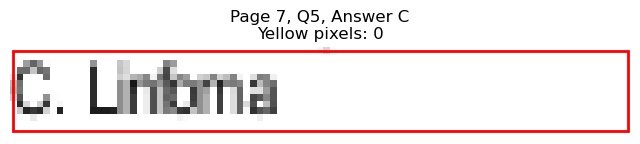

Page 7, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=399.5, y1=374.6
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 366
Page 7, Q5, D: Yellow percentage: 0.0%


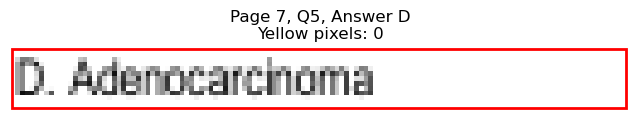

Page 7, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=397.3, y1=386.6
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 348
Page 7, Q5, E: Yellow percentage: 0.0%


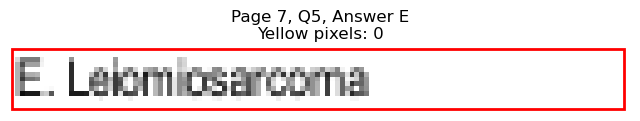


Page 7, Q5 - Selected Answer: A (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.6, y0=422.5, x1=134.6, y1=434.6
Page 7, Q6, A: Yellow pixels: 384
Page 7, Q6, A: Total non-white pixels: 663
Page 7, Q6, A: Yellow percentage: 57.9%


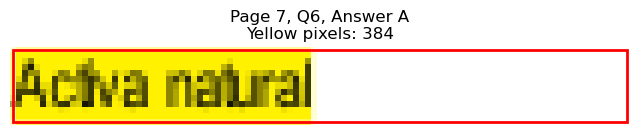

Page 7, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=136.1, y1=446.6
Page 7, Q6, B: Yellow pixels: 49
Page 7, Q6, B: Total non-white pixels: 374
Page 7, Q6, B: Yellow percentage: 13.1%


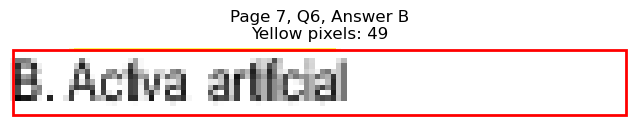

Page 7, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=110.5, y1=458.6
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 156
Page 7, Q6, C: Yellow percentage: 0.0%


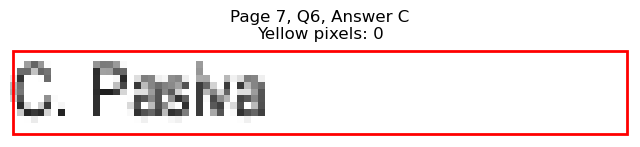

Page 7, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=388.3, y1=434.6
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 317
Page 7, Q6, D: Yellow percentage: 0.0%


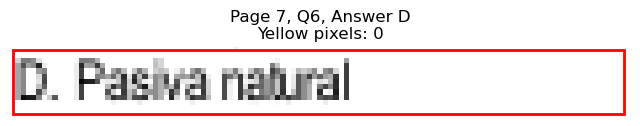

Page 7, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=361.3, y1=446.6
Page 7, Q6, E: Yellow pixels: 0
Page 7, Q6, E: Total non-white pixels: 180
Page 7, Q6, E: Yellow percentage: 0.0%


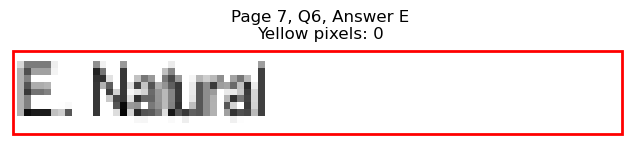


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.6, y0=507.4, x1=117.3, y1=519.4
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 182
Page 7, Q7, A: Yellow percentage: 0.0%


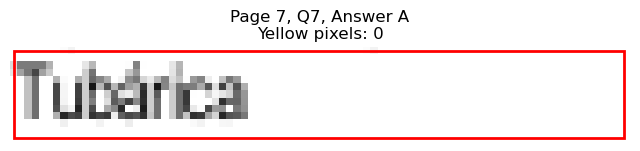

Page 7, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=155.4, y1=531.4
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 397
Page 7, Q7, B: Yellow percentage: 0.0%


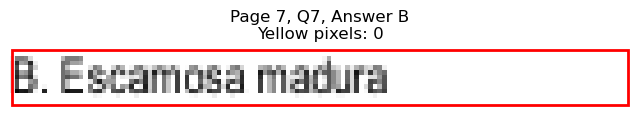

Page 7, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=161.5, y1=543.5
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 417
Page 7, Q7, C: Yellow percentage: 0.0%


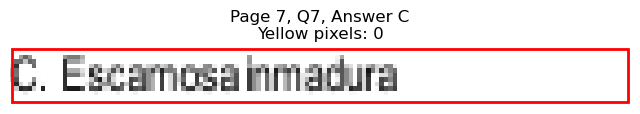

Page 7, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=416.9, y1=519.4
Page 7, Q7, D: Yellow pixels: 790
Page 7, Q7, D: Total non-white pixels: 1209
Page 7, Q7, D: Yellow percentage: 65.3%


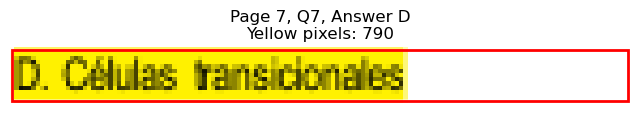

Page 7, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=379.3, y1=531.4
Page 7, Q7, E: Yellow pixels: 91
Page 7, Q7, E: Total non-white pixels: 368
Page 7, Q7, E: Yellow percentage: 24.7%


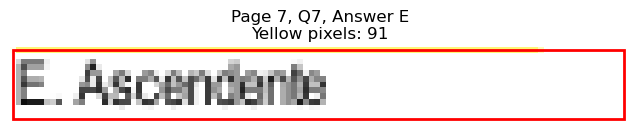


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.6, y0=567.5, x1=118.0, y1=579.5
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 190
Page 7, Q8, A: Yellow percentage: 0.0%


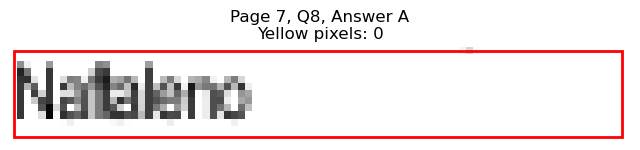

Page 7, Q8 - B: Detected box: x0=71.3, y0=579.4, x1=147.3, y1=591.5
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 372
Page 7, Q8, B: Yellow percentage: 0.0%


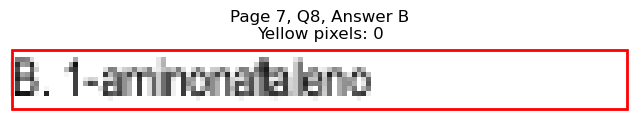

Page 7, Q8 - C: Detected box: x0=71.3, y0=591.5, x1=119.5, y1=603.5
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 204
Page 7, Q8, C: Yellow percentage: 0.0%


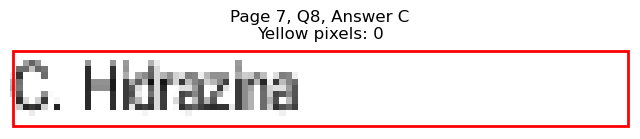

Page 7, Q8 - D: Detected box: x0=322.9, y0=567.5, x1=386.9, y1=579.5
Page 7, Q8, D: Yellow pixels: 531
Page 7, Q8, D: Total non-white pixels: 819
Page 7, Q8, D: Yellow percentage: 64.8%


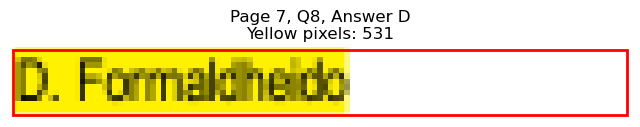

Page 7, Q8 - E: Detected box: x0=322.9, y0=579.4, x1=378.5, y1=591.5
Page 7, Q8, E: Yellow pixels: 61
Page 7, Q8, E: Total non-white pixels: 316
Page 7, Q8, E: Yellow percentage: 19.3%


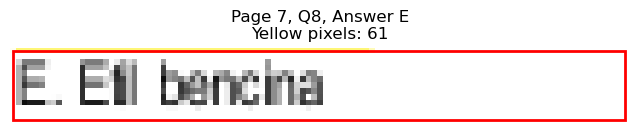


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.6, y0=627.5, x1=130.0, y1=639.6
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 363
Page 7, Q9, A: Yellow percentage: 0.0%


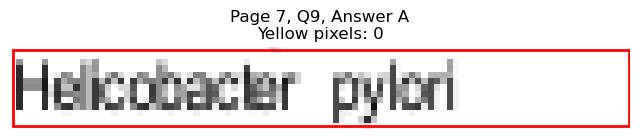

Page 7, Q9 - B: Detected box: x0=71.3, y0=639.5, x1=109.8, y1=651.6
Page 7, Q9, B: Yellow pixels: 335
Page 7, Q9, B: Total non-white pixels: 484
Page 7, Q9, B: Yellow percentage: 69.2%


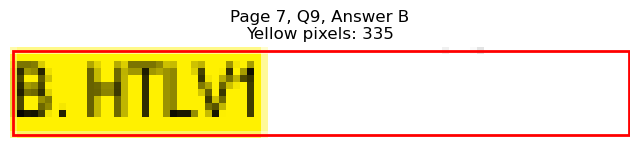

Page 7, Q9 - C: Detected box: x0=71.3, y0=651.5, x1=102.2, y1=663.6
Page 7, Q9, C: Yellow pixels: 36
Page 7, Q9, C: Total non-white pixels: 155
Page 7, Q9, C: Yellow percentage: 23.2%


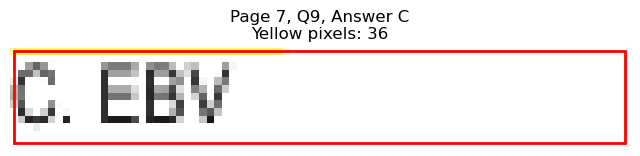

Page 7, Q9 - D: Detected box: x0=322.9, y0=627.5, x1=404.8, y1=639.6
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 380
Page 7, Q9, D: Yellow percentage: 0.0%


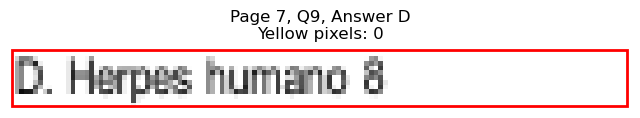

Page 7, Q9 - E: Detected box: x0=322.9, y0=639.5, x1=365.8, y1=651.6
Page 7, Q9, E: Yellow pixels: 0
Page 7, Q9, E: Total non-white pixels: 255
Page 7, Q9, E: Yellow percentage: 0.0%


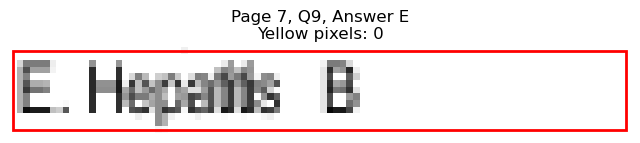


Page 7, Q9 - Selected Answer: B (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=82.6, y0=688.3, x1=112.7, y1=700.3
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 155
Page 7, Q10, A: Yellow percentage: 0.0%


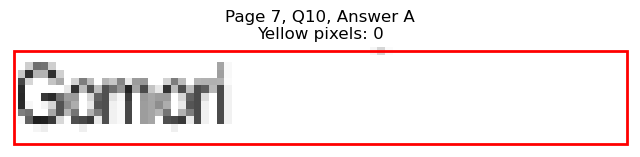

Page 7, Q10 - B: Detected box: x0=71.3, y0=700.3, x1=158.6, y1=712.3
Page 7, Q10, B: Yellow pixels: 676
Page 7, Q10, B: Total non-white pixels: 1118
Page 7, Q10, B: Yellow percentage: 60.5%


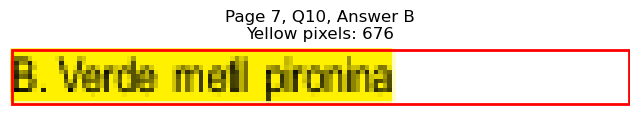

Page 7, Q10 - C: Detected box: x0=71.3, y0=712.3, x1=111.2, y1=724.4
Page 7, Q10, C: Yellow pixels: 1
Page 7, Q10, C: Total non-white pixels: 264
Page 7, Q10, C: Yellow percentage: 0.4%


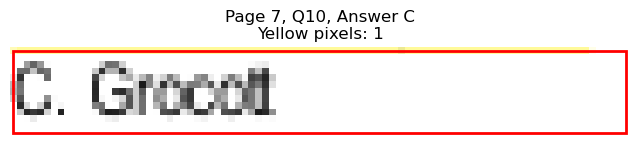

Page 7, Q10 - D: Detected box: x0=322.9, y0=688.3, x1=403.3, y1=700.3
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 402
Page 7, Q10, D: Yellow percentage: 0.0%


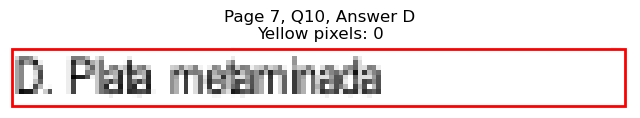

Page 7, Q10 - E: Detected box: x0=322.9, y0=700.3, x1=355.3, y1=712.3
Page 7, Q10, E: Yellow pixels: 0
Page 7, Q10, E: Total non-white pixels: 129
Page 7, Q10, E: Yellow percentage: 0.0%


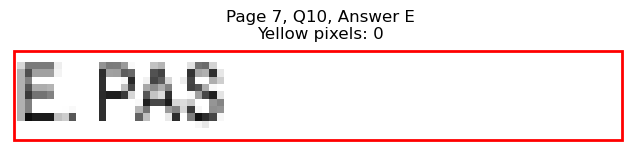


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=126.2, y1=133.6
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 234
Page 8, Q1, A: Yellow percentage: 0.0%


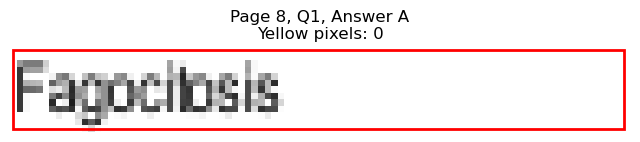

Page 8, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=121.0, y1=145.6
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 263
Page 8, Q1, B: Yellow percentage: 0.0%


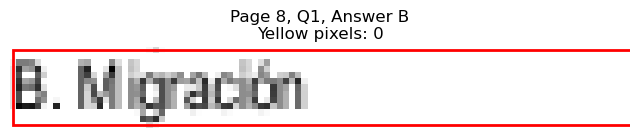

Page 8, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=136.8, y1=157.6
Page 8, Q1, C: Yellow pixels: 505
Page 8, Q1, C: Total non-white pixels: 832
Page 8, Q1, C: Yellow percentage: 60.7%


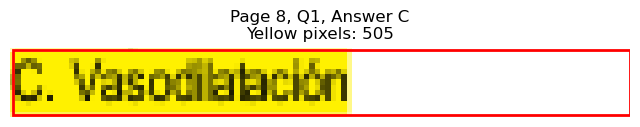

Page 8, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=379.3, y1=133.6
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 287
Page 8, Q1, D: Yellow percentage: 0.0%


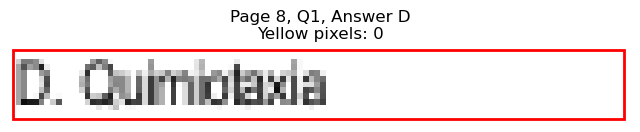

Page 8, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=380.8, y1=145.6
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 256
Page 8, Q1, E: Yellow percentage: 0.0%


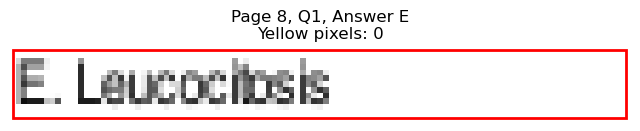


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=176.5, y1=193.6
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 488
Page 8, Q2, A: Yellow percentage: 0.0%


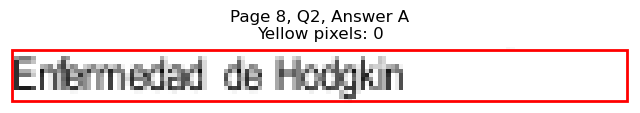

Page 8, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=145.7, y1=205.6
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 390
Page 8, Q2, B: Yellow percentage: 0.0%


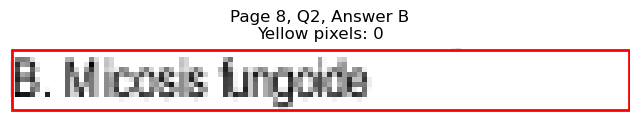

Page 8, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=159.2, y1=217.7
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 423
Page 8, Q2, C: Yellow percentage: 0.0%


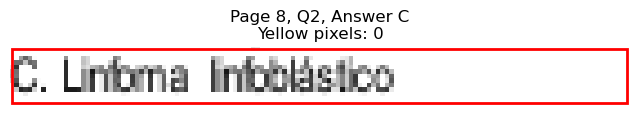

Page 8, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=402.6, y1=193.6
Page 8, Q2, D: Yellow pixels: 621
Page 8, Q2, D: Total non-white pixels: 1029
Page 8, Q2, D: Yellow percentage: 60.3%


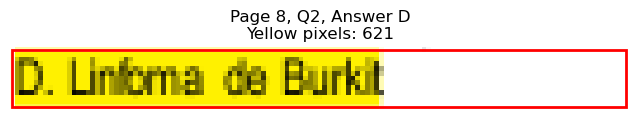

Page 8, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=452.8, y1=205.6
Page 8, Q2, E: Yellow pixels: 77
Page 8, Q2, E: Total non-white pixels: 680
Page 8, Q2, E: Yellow percentage: 11.3%


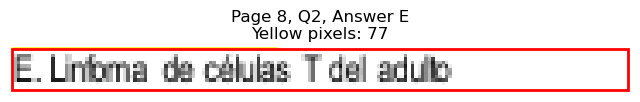


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=134.5, y1=253.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 269
Page 8, Q3, A: Yellow percentage: 0.0%


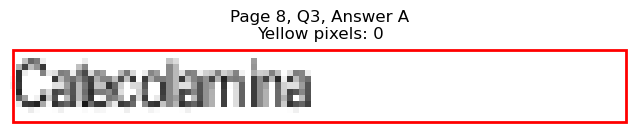

Page 8, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=106.7, y1=265.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 169
Page 8, Q3, B: Yellow percentage: 0.0%


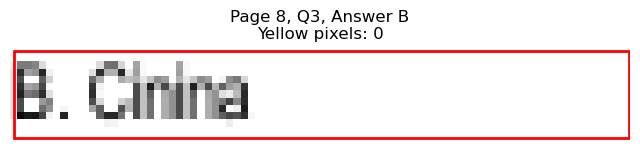

Page 8, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=139.1, y1=277.7
Page 8, Q3, C: Yellow pixels: 514
Page 8, Q3, C: Total non-white pixels: 858
Page 8, Q3, C: Yellow percentage: 59.9%


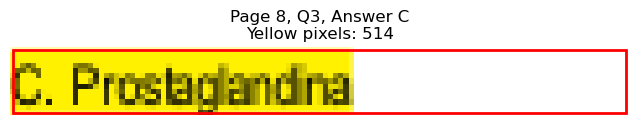

Page 8, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=439.3, y1=253.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 587
Page 8, Q3, D: Yellow percentage: 0.0%


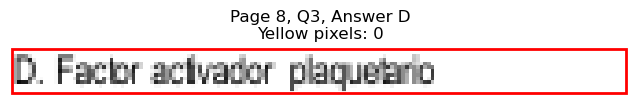

Page 8, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=374.8, y1=265.7
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 256
Page 8, Q3, E: Yellow percentage: 0.0%


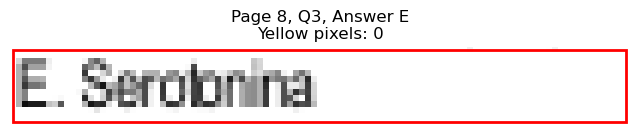


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=152.5, y1=314.5
Page 8, Q4, A: Yellow pixels: 977
Page 8, Q4, A: Total non-white pixels: 1417
Page 8, Q4, A: Yellow percentage: 68.9%


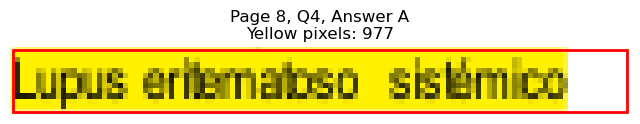

Page 8, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=147.2, y1=326.5
Page 8, Q4, B: Yellow pixels: 107
Page 8, Q4, B: Total non-white pixels: 491
Page 8, Q4, B: Yellow percentage: 21.8%


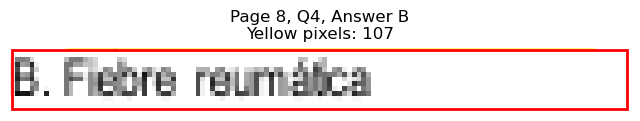

Page 8, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=151.7, y1=338.5
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 390
Page 8, Q4, C: Yellow percentage: 0.0%


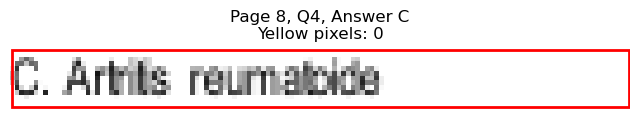

Page 8, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=392.8, y1=314.5
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 556
Page 8, Q4, D: Yellow percentage: 0.0%


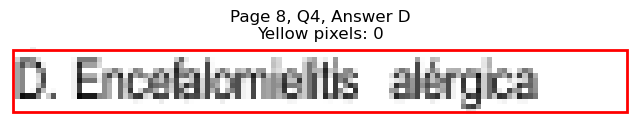

Page 8, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=397.3, y1=326.5
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 654
Page 8, Q4, E: Yellow percentage: 0.0%


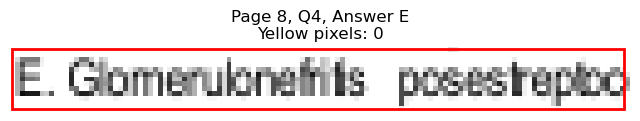


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=126.8, y0=362.5, x1=177.2, y1=374.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 254
Page 8, Q5, A: Yellow percentage: 0.0%


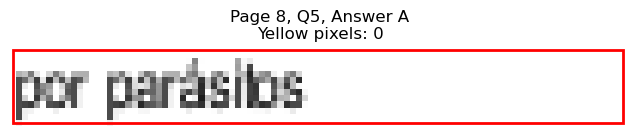

Page 8, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=161.6, y1=386.6
Page 8, Q5, B: Yellow pixels: 790
Page 8, Q5, B: Total non-white pixels: 1157
Page 8, Q5, B: Yellow percentage: 68.3%


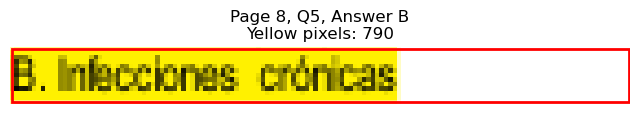

Page 8, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=163.8, y1=398.6
Page 8, Q5, C: Yellow pixels: 88
Page 8, Q5, C: Total non-white pixels: 542
Page 8, Q5, C: Yellow percentage: 16.2%


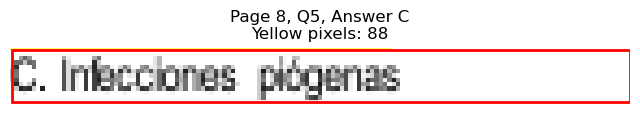

Page 8, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=392.8, y1=374.6
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 323
Page 8, Q5, D: Yellow percentage: 0.0%


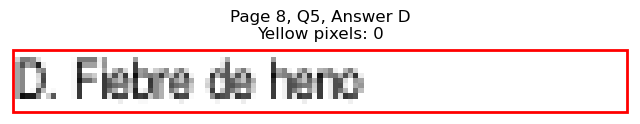

Page 8, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=437.0, y1=386.6
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 529
Page 8, Q5, E: Yellow percentage: 0.0%


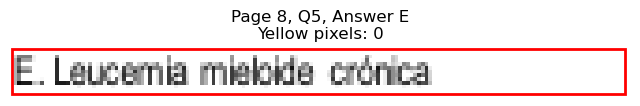


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=132.3, y1=458.6
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 272
Page 8, Q6, A: Yellow percentage: 0.0%


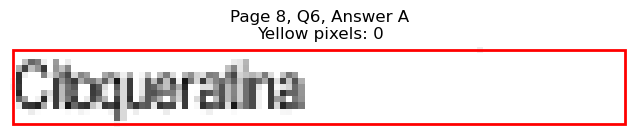

Page 8, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=117.2, y1=470.6
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 228
Page 8, Q6, B: Yellow percentage: 0.0%


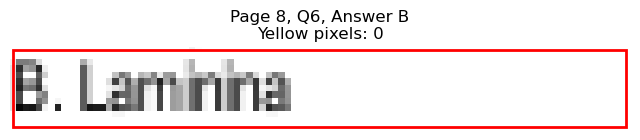

Page 8, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=114.2, y1=482.6
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 192
Page 8, Q6, C: Yellow percentage: 0.0%


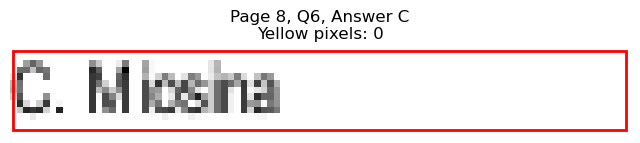

Page 8, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=369.5, y1=458.6
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 216
Page 8, Q6, D: Yellow percentage: 0.0%


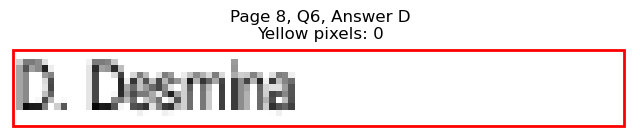

Page 8, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=358.3, y1=470.6
Page 8, Q6, E: Yellow pixels: 264
Page 8, Q6, E: Total non-white pixels: 442
Page 8, Q6, E: Yellow percentage: 59.7%


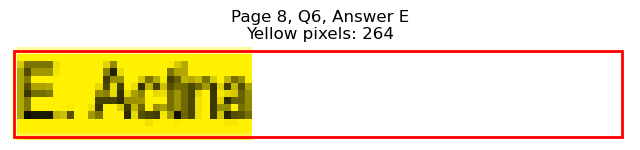


Page 8, Q6 - Selected Answer: E (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.6, y0=507.4, x1=224.7, y1=519.4
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 641
Page 8, Q7, A: Yellow percentage: 0.0%


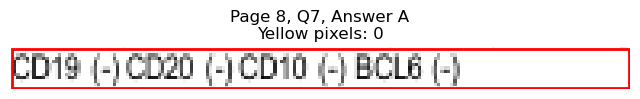

Page 8, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=226.1, y1=531.4
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 676
Page 8, Q7, B: Yellow percentage: 0.0%


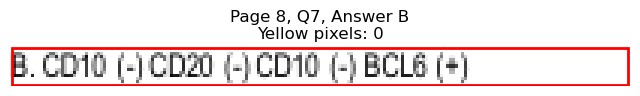

Page 8, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=228.4, y1=543.5
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 696
Page 8, Q7, C: Yellow percentage: 0.0%


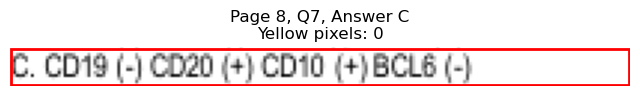

Page 8, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=484.5, y1=519.4
Page 8, Q7, D: Yellow pixels: 1519
Page 8, Q7, D: Total non-white pixels: 2093
Page 8, Q7, D: Yellow percentage: 72.6%


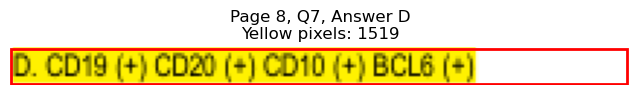

Page 8, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=481.5, y1=531.4
Page 8, Q7, E: Yellow pixels: 159
Page 8, Q7, E: Total non-white pixels: 869
Page 8, Q7, E: Yellow percentage: 18.3%


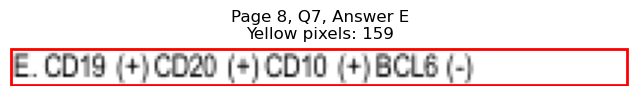


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.6, y0=567.5, x1=173.6, y1=579.5
Page 8, Q8, A: Yellow pixels: 773
Page 8, Q8, A: Total non-white pixels: 1173
Page 8, Q8, A: Yellow percentage: 65.9%


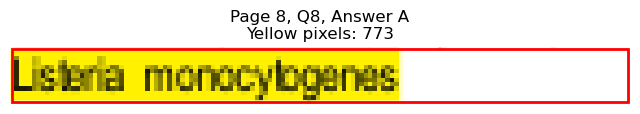

Page 8, Q8 - B: Detected box: x0=71.3, y0=579.4, x1=186.2, y1=591.5
Page 8, Q8, B: Yellow pixels: 88
Page 8, Q8, B: Total non-white pixels: 659
Page 8, Q8, B: Yellow percentage: 13.4%


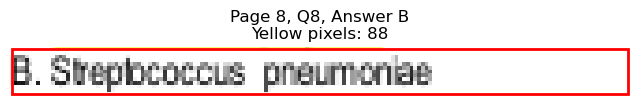

Page 8, Q8 - C: Detected box: x0=71.3, y0=591.5, x1=142.0, y1=603.5
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 326
Page 8, Q8, C: Yellow percentage: 0.0%


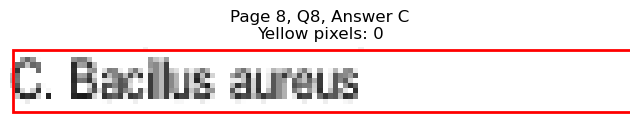

Page 8, Q8 - D: Detected box: x0=322.9, y0=567.5, x1=372.5, y1=579.5
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 512
Page 8, Q8, D: Yellow percentage: 0.0%


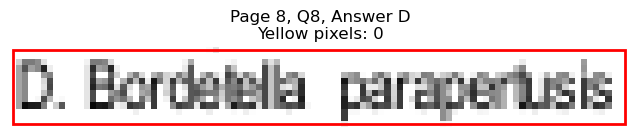

Page 8, Q8 - E: Detected box: x0=322.9, y0=579.4, x1=417.5, y1=591.5
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 460
Page 8, Q8, E: Yellow percentage: 0.0%


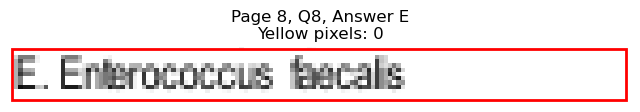


Page 8, Q8 - Selected Answer: A (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=82.6, y0=627.5, x1=109.7, y1=639.6
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 122
Page 8, Q9, A: Yellow percentage: 0.0%


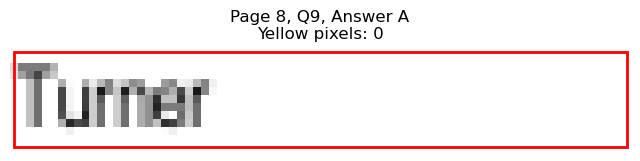

Page 8, Q9 - B: Detected box: x0=71.3, y0=639.5, x1=105.3, y1=651.6
Page 8, Q9, B: Yellow pixels: 285
Page 8, Q9, B: Total non-white pixels: 416
Page 8, Q9, B: Yellow percentage: 68.5%


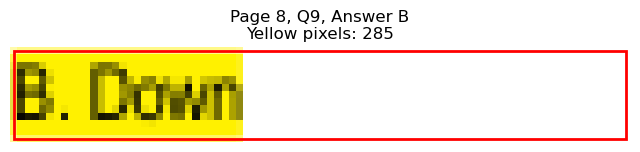

Page 8, Q9 - C: Detected box: x0=71.3, y0=651.5, x1=120.2, y1=663.6
Page 8, Q9, C: Yellow pixels: 32
Page 8, Q9, C: Total non-white pixels: 240
Page 8, Q9, C: Yellow percentage: 13.3%


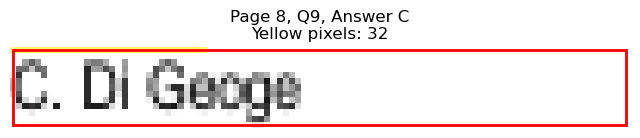

Page 8, Q9 - D: Detected box: x0=322.9, y0=627.5, x1=361.3, y1=639.6
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 185
Page 8, Q9, D: Yellow percentage: 0.0%


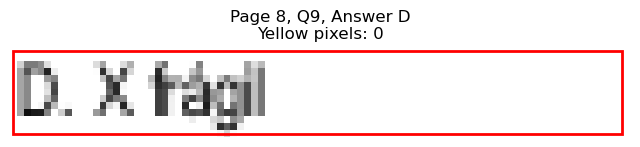

Page 8, Q9 - E: Detected box: x0=322.9, y0=639.5, x1=364.3, y1=651.6
Page 8, Q9, E: Yellow pixels: 0
Page 8, Q9, E: Total non-white pixels: 197
Page 8, Q9, E: Yellow percentage: 0.0%


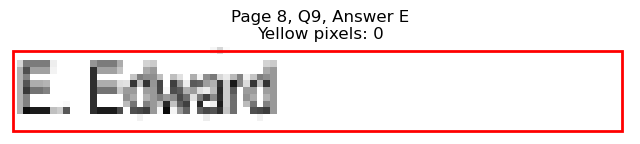


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=82.6, y0=688.3, x1=102.2, y1=700.3
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 98
Page 8, Q10, A: Yellow percentage: 0.0%


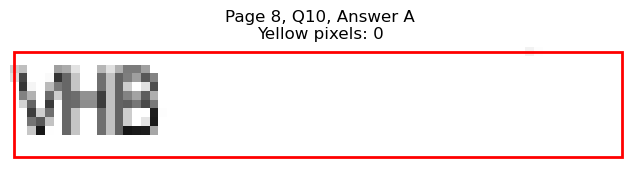

Page 8, Q10 - B: Detected box: x0=71.3, y0=700.3, x1=132.2, y1=712.3
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 287
Page 8, Q10, B: Yellow percentage: 0.0%


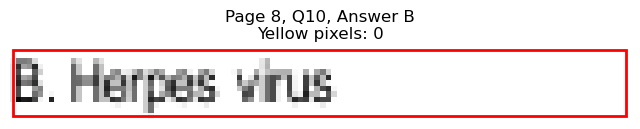

Page 8, Q10 - C: Detected box: x0=71.3, y0=712.3, x1=140.5, y1=724.4
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 320
Page 8, Q10, C: Yellow percentage: 0.0%


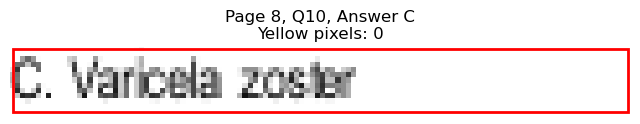

Page 8, Q10 - D: Detected box: x0=322.9, y0=688.3, x1=395.0, y1=700.3
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 374
Page 8, Q10, D: Yellow percentage: 0.0%


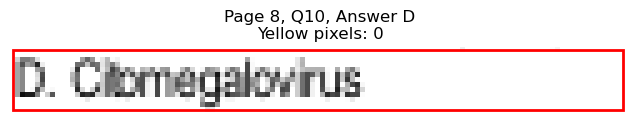

Page 8, Q10 - E: Detected box: x0=322.9, y0=700.3, x1=382.4, y1=712.3
Page 8, Q10, E: Yellow pixels: 440
Page 8, Q10, E: Total non-white pixels: 754
Page 8, Q10, E: Yellow percentage: 58.4%


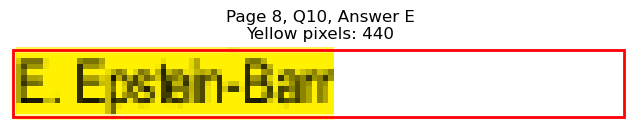


Page 8, Q10 - Selected Answer: E (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=82.6, y0=748.4, x1=102.3, y1=760.4
Page 8, Q11, A: Yellow pixels: 161
Page 8, Q11, A: Total non-white pixels: 234
Page 8, Q11, A: Yellow percentage: 68.8%


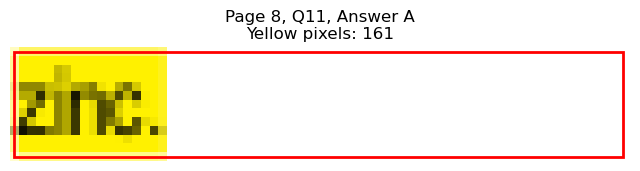

Page 8, Q11 - B: Detected box: x0=71.3, y0=760.4, x1=107.5, y1=772.4
Page 8, Q11, B: Yellow pixels: 16
Page 8, Q11, B: Total non-white pixels: 173
Page 8, Q11, B: Yellow percentage: 9.2%


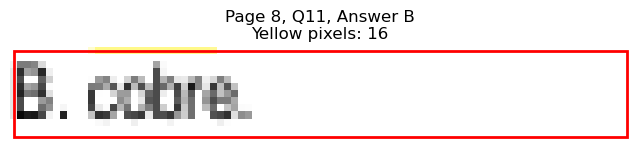

Page 8, Q11 - C: Detected box: x0=71.3, y0=772.4, x1=108.2, y1=784.4
Page 8, Q11, C: Yellow pixels: 0
Page 8, Q11, C: Total non-white pixels: 148
Page 8, Q11, C: Yellow percentage: 0.0%


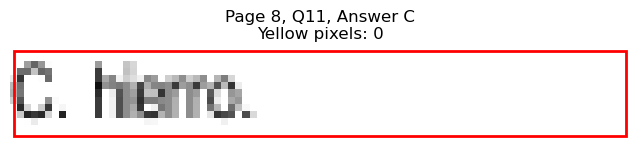

Page 8, Q11 - D: Detected box: x0=322.9, y0=748.4, x1=353.8, y1=760.4
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 126
Page 8, Q11, D: Yellow percentage: 0.0%


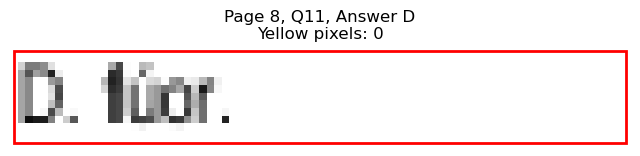

Page 8, Q11 - E: Detected box: x0=322.9, y0=760.4, x1=359.1, y1=772.4
Page 8, Q11, E: Yellow pixels: 0
Page 8, Q11, E: Total non-white pixels: 137
Page 8, Q11, E: Yellow percentage: 0.0%


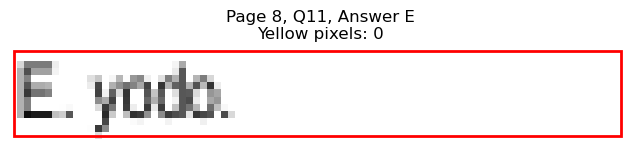


Page 8, Q11 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=114.3, y1=121.6
Page 9, Q1, A: Yellow pixels: 248
Page 9, Q1, A: Total non-white pixels: 390
Page 9, Q1, A: Yellow percentage: 63.6%


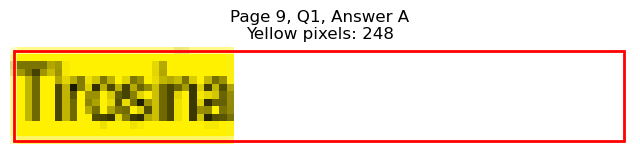

Page 9, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=135.2, y1=133.6
Page 9, Q1, B: Yellow pixels: 29
Page 9, Q1, B: Total non-white pixels: 361
Page 9, Q1, B: Yellow percentage: 8.0%


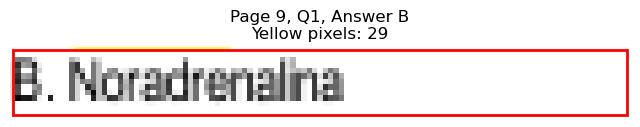

Page 9, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=136.0, y1=145.6
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 318
Page 9, Q1, C: Yellow percentage: 0.0%


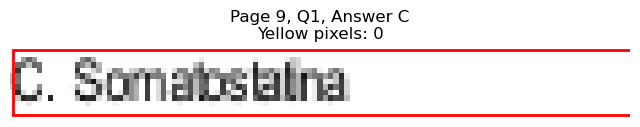

Page 9, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=364.3, y1=121.6
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 184
Page 9, Q1, D: Yellow percentage: 0.0%


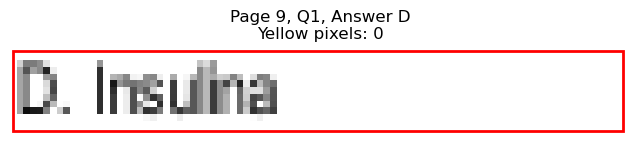

Page 9, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=362.8, y1=133.6
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 192
Page 9, Q1, E: Yellow percentage: 0.0%


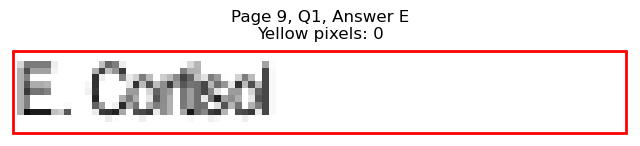


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=153.3, y1=181.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 402
Page 9, Q2, A: Yellow percentage: 0.0%


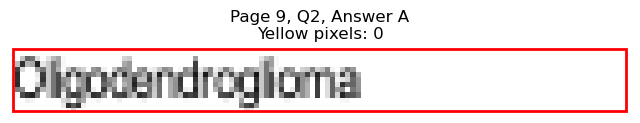

Page 9, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=136.0, y1=193.6
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 345
Page 9, Q2, B: Yellow percentage: 0.0%


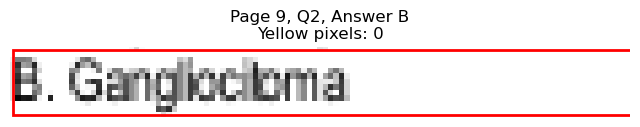

Page 9, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=134.5, y1=205.6
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 288
Page 9, Q2, C: Yellow percentage: 0.0%


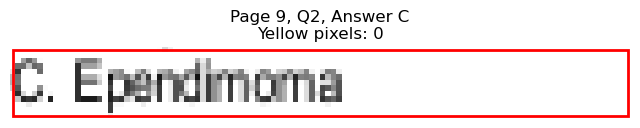

Page 9, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=383.9, y1=181.6
Page 9, Q2, D: Yellow pixels: 456
Page 9, Q2, D: Total non-white pixels: 780
Page 9, Q2, D: Yellow percentage: 58.5%


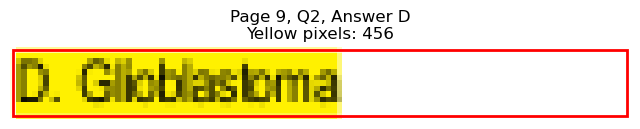

Page 9, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=431.9, y1=193.6
Page 9, Q2, E: Yellow pixels: 58
Page 9, Q2, E: Total non-white pixels: 623
Page 9, Q2, E: Yellow percentage: 9.3%


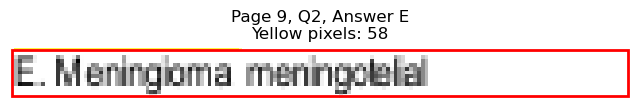


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=121.6, y0=253.6, x1=201.2, y1=265.7
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 389
Page 9, Q3, A: Yellow percentage: 0.0%


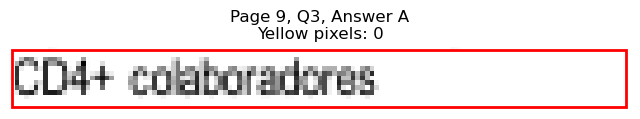

Page 9, Q3 - B: Detected box: x0=125.4, y0=265.7, x1=196.8, y1=277.7
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 373
Page 9, Q3, B: Yellow percentage: 0.0%


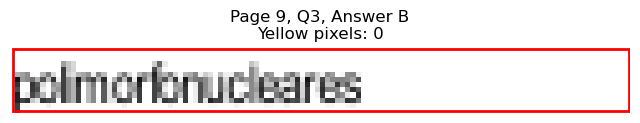

Page 9, Q3 - C: Detected box: x0=120.8, y0=277.7, x1=176.6, y1=289.7
Page 9, Q3, C: Yellow pixels: 425
Page 9, Q3, C: Total non-white pixels: 715
Page 9, Q3, C: Yellow percentage: 59.4%


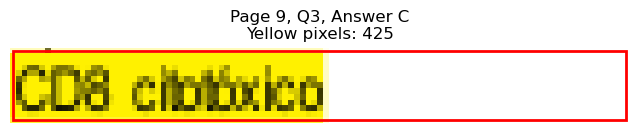

Page 9, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=423.5, y1=265.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 535
Page 9, Q3, D: Yellow percentage: 0.0%


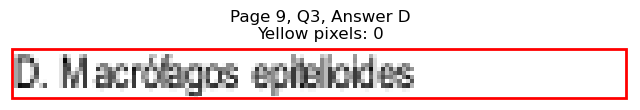

Page 9, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=482.7, y1=277.7
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 795
Page 9, Q3, E: Yellow percentage: 0.0%


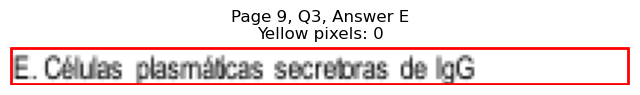


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=112.0, y1=326.5
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 141
Page 9, Q4, A: Yellow percentage: 0.0%


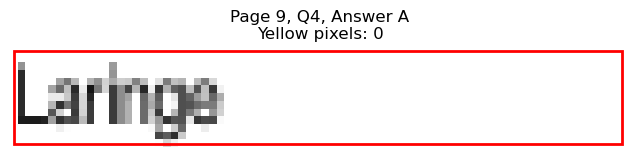

Page 9, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=127.7, y1=338.5
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 303
Page 9, Q4, B: Yellow percentage: 0.0%


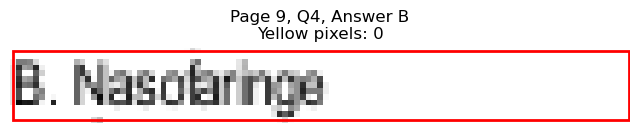

Page 9, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=106.7, y1=350.5
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 165
Page 9, Q4, C: Yellow percentage: 0.0%


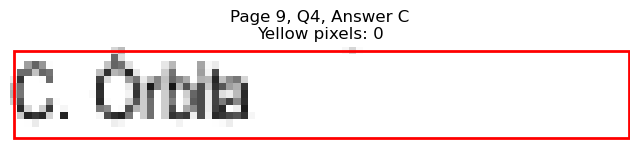

Page 9, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=401.1, y1=326.5
Page 9, Q4, D: Yellow pixels: 680
Page 9, Q4, D: Total non-white pixels: 1004
Page 9, Q4, D: Yellow percentage: 67.7%


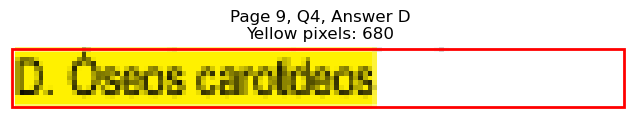

Page 9, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=389.1, y1=338.5
Page 9, Q4, E: Yellow pixels: 76
Page 9, Q4, E: Total non-white pixels: 399
Page 9, Q4, E: Yellow percentage: 19.0%


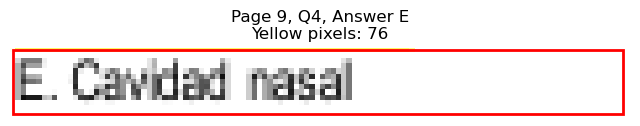


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.6, y0=398.5, x1=171.2, y1=410.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 605
Page 9, Q5, A: Yellow percentage: 0.0%


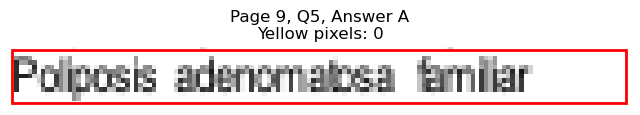

Page 9, Q5 - B: Detected box: x0=71.3, y0=410.5, x1=190.1, y1=422.6
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 577
Page 9, Q5, B: Yellow percentage: 0.0%


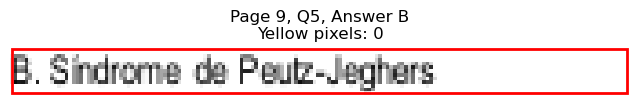

Page 9, Q5 - C: Detected box: x0=71.3, y0=422.5, x1=159.2, y1=434.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 399
Page 9, Q5, C: Yellow percentage: 0.0%


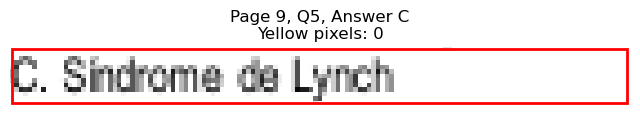

Page 9, Q5 - D: Detected box: x0=322.9, y0=398.5, x1=419.0, y1=410.6
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 457
Page 9, Q5, D: Yellow percentage: 0.0%


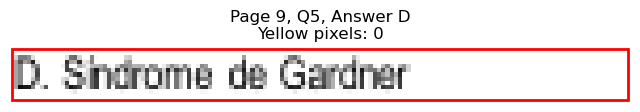

Page 9, Q5 - E: Detected box: x0=322.9, y0=410.5, x1=384.6, y1=422.6
Page 9, Q5, E: Yellow pixels: 470
Page 9, Q5, E: Total non-white pixels: 793
Page 9, Q5, E: Yellow percentage: 59.3%


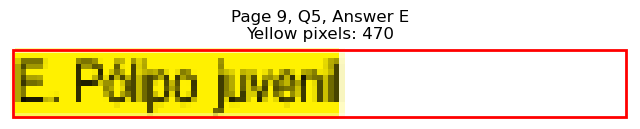


Page 9, Q5 - Selected Answer: E (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=129.1, y0=458.6, x1=204.4, y1=470.6
Page 9, Q6, A: Yellow pixels: 575
Page 9, Q6, A: Total non-white pixels: 949
Page 9, Q6, A: Yellow percentage: 60.6%


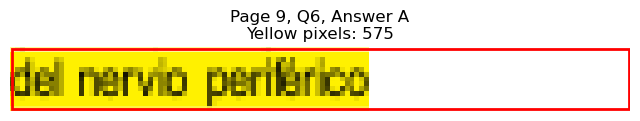

Page 9, Q6 - B: Detected box: x0=123.8, y0=470.6, x1=204.9, y1=482.6
Page 9, Q6, B: Yellow pixels: 79
Page 9, Q6, B: Total non-white pixels: 469
Page 9, Q6, B: Yellow percentage: 16.8%


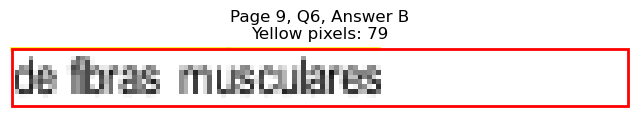

Page 9, Q6 - C: Detected box: x0=71.3, y0=483.4, x1=176.5, y1=495.4
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 529
Page 9, Q6, C: Yellow percentage: 0.0%


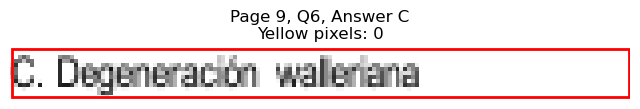

Page 9, Q6 - D: Detected box: x0=322.9, y0=458.6, x1=423.5, y1=470.6
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 476
Page 9, Q6, D: Yellow percentage: 0.0%


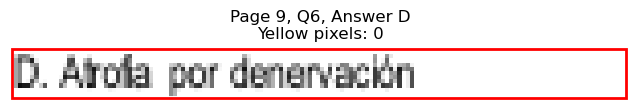

Page 9, Q6 - E: Detected box: x0=322.9, y0=470.6, x1=408.6, y1=482.6
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 427
Page 9, Q6, E: Yellow percentage: 0.0%


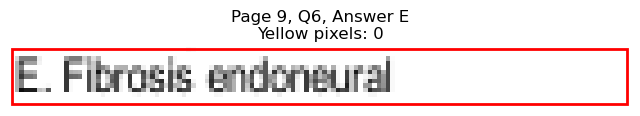


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=106.0, y1=531.4
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 104
Page 9, Q7, A: Yellow percentage: 0.0%


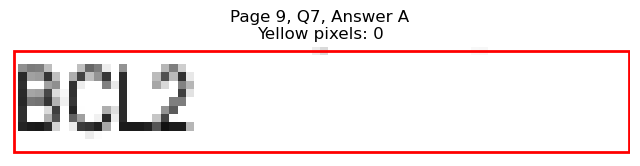

Page 9, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=123.9, y1=543.5
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 249
Page 9, Q7, B: Yellow percentage: 0.0%


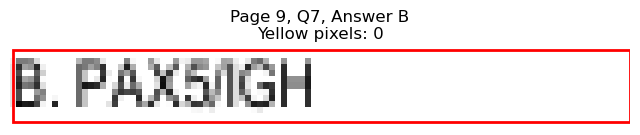

Page 9, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=105.2, y1=555.5
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 143
Page 9, Q7, C: Yellow percentage: 0.0%


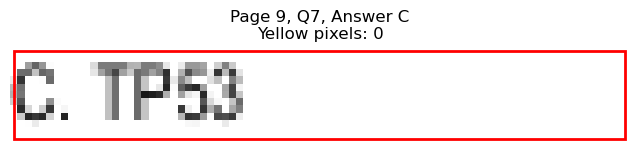

Page 9, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=369.6, y1=531.4
Page 9, Q7, D: Yellow pixels: 387
Page 9, Q7, D: Total non-white pixels: 598
Page 9, Q7, D: Yellow percentage: 64.7%


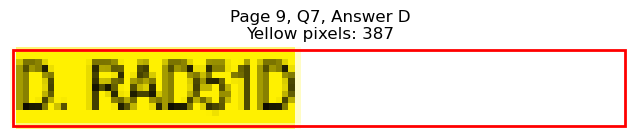

Page 9, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=358.3, y1=543.5
Page 9, Q7, E: Yellow pixels: 44
Page 9, Q7, E: Total non-white pixels: 216
Page 9, Q7, E: Yellow percentage: 20.4%


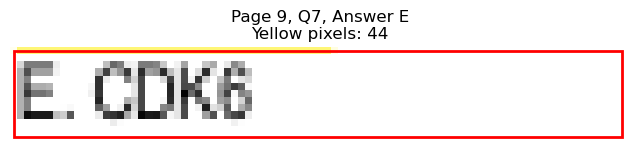


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=148.0, y1=591.5
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 335
Page 9, Q8, A: Yellow percentage: 0.0%


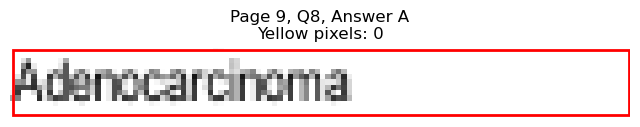

Page 9, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=124.8, y1=603.5
Page 9, Q8, B: Yellow pixels: 469
Page 9, Q8, B: Total non-white pixels: 676
Page 9, Q8, B: Yellow percentage: 69.4%


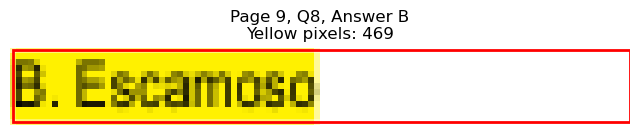

Page 9, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=169.7, y1=615.5
Page 9, Q8, C: Yellow pixels: 51
Page 9, Q8, C: Total non-white pixels: 509
Page 9, Q8, C: Yellow percentage: 10.0%


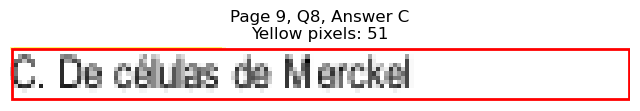

Page 9, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=365.0, y1=591.5
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 218
Page 9, Q8, D: Yellow percentage: 0.0%


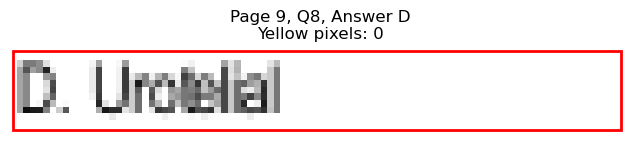

Page 9, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=386.0, y1=603.5
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 326
Page 9, Q8, E: Yellow percentage: 0.0%


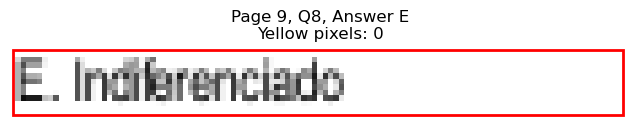


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=82.6, y0=663.5, x1=98.5, y1=675.6
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 81
Page 9, Q9, A: Yellow percentage: 0.0%


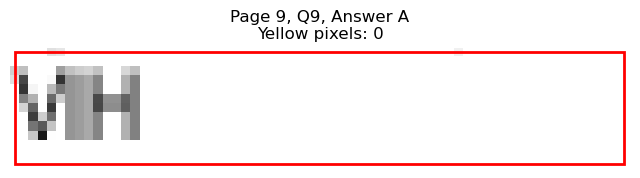

Page 9, Q9 - B: Detected box: x0=71.3, y0=676.3, x1=172.7, y1=688.3
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 479
Page 9, Q9, B: Yellow percentage: 0.0%


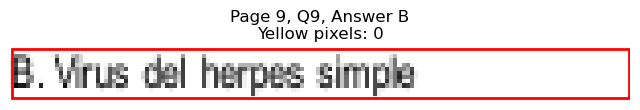

Page 9, Q9 - C: Detected box: x0=71.3, y0=688.3, x1=170.5, y1=700.3
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 477
Page 9, Q9, C: Yellow percentage: 0.0%


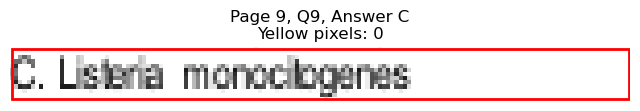

Page 9, Q9 - D: Detected box: x0=322.9, y0=663.5, x1=395.1, y1=675.6
Page 9, Q9, D: Yellow pixels: 541
Page 9, Q9, D: Total non-white pixels: 923
Page 9, Q9, D: Yellow percentage: 58.6%


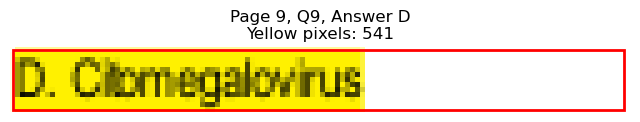

Page 9, Q9 - E: Detected box: x0=322.9, y0=676.3, x1=398.7, y1=688.3
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 433
Page 9, Q9, E: Yellow percentage: 0.0%


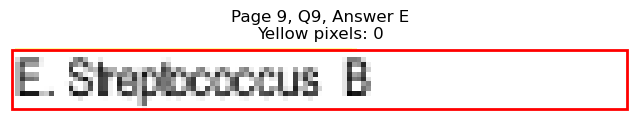


Page 9, Q9 - Selected Answer: D (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=82.6, y0=724.3, x1=124.0, y1=736.4
Page 9, Q10, A: Yellow pixels: 567
Page 9, Q10, A: Total non-white pixels: 951
Page 9, Q10, A: Yellow percentage: 59.6%


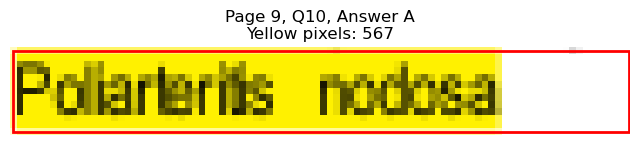

Page 9, Q10 - B: Detected box: x0=71.3, y0=736.4, x1=145.7, y1=748.4
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 580
Page 9, Q10, B: Yellow percentage: 0.0%


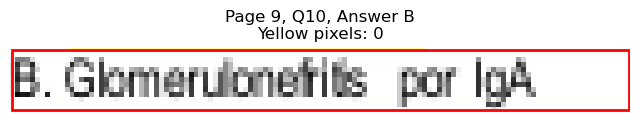

Page 9, Q10 - C: Detected box: x0=150.2, y0=748.4, x1=230.6, y1=760.4
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 444
Page 9, Q10, C: Yellow percentage: 0.0%


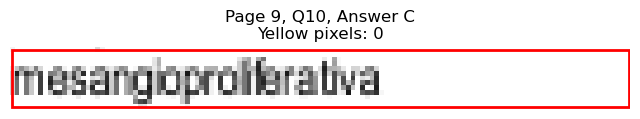

Page 9, Q10 - D: Detected box: x0=322.9, y0=724.3, x1=398.0, y1=736.4
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 624
Page 9, Q10, D: Yellow percentage: 0.0%


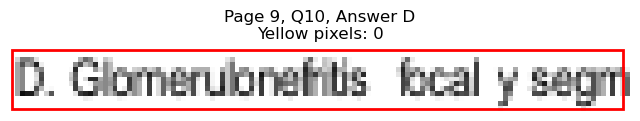

Page 9, Q10 - E: Detected box: x0=322.9, y0=736.4, x1=397.3, y1=748.4
Page 9, Q10, E: Yellow pixels: 0
Page 9, Q10, E: Total non-white pixels: 656
Page 9, Q10, E: Yellow percentage: 0.0%


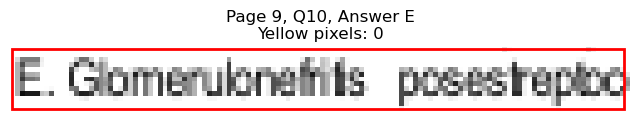


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 7 questions
Page 10, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=216.2, y1=108.8
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 646
Page 10, Q1, A: Yellow percentage: 0.0%


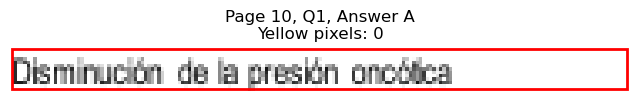

Page 10, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=152.5, y1=121.6
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 422
Page 10, Q1, B: Yellow percentage: 0.0%


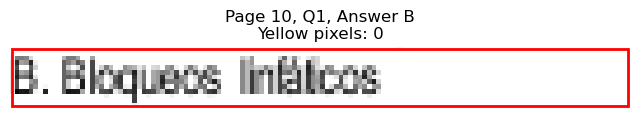

Page 10, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=214.2, y1=133.6
Page 10, Q1, C: Yellow pixels: 1274
Page 10, Q1, C: Total non-white pixels: 1833
Page 10, Q1, C: Yellow percentage: 69.5%


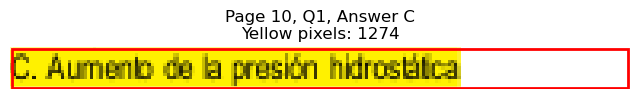

Page 10, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=468.5, y1=108.8
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 732
Page 10, Q1, D: Yellow percentage: 0.0%


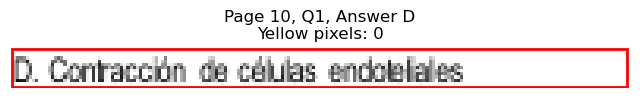

Page 10, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=386.8, y1=121.6
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 473
Page 10, Q1, E: Yellow percentage: 0.0%


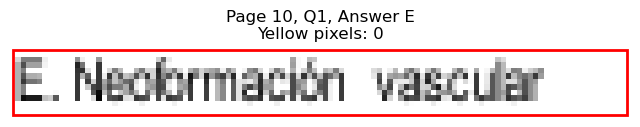


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=145.0, y1=181.6
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 329
Page 10, Q2, A: Yellow percentage: 0.0%


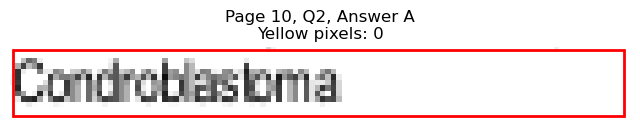

Page 10, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=139.1, y1=193.6
Page 10, Q2, B: Yellow pixels: 532
Page 10, Q2, B: Total non-white pixels: 858
Page 10, Q2, B: Yellow percentage: 62.0%


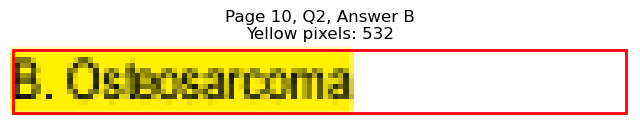

Page 10, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=156.2, y1=205.6
Page 10, Q2, C: Yellow pixels: 66
Page 10, Q2, C: Total non-white pixels: 467
Page 10, Q2, C: Yellow percentage: 14.1%


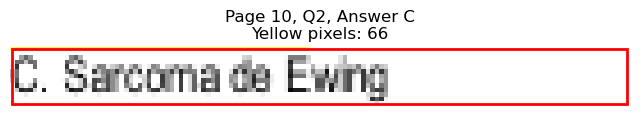

Page 10, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=398.0, y1=181.6
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 383
Page 10, Q2, D: Yellow percentage: 0.0%


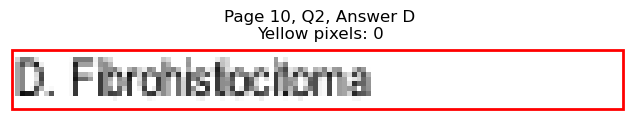

Page 10, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=406.3, y1=193.6
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 420
Page 10, Q2, E: Yellow percentage: 0.0%


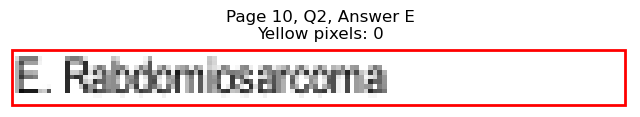


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=199.7, y1=241.7
Page 10, Q3, A: Yellow pixels: 1352
Page 10, Q3, A: Total non-white pixels: 2184
Page 10, Q3, A: Yellow percentage: 61.9%


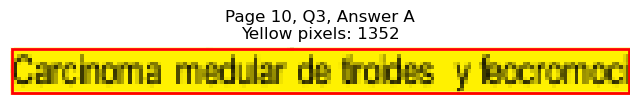

Page 10, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=198.9, y1=253.7
Page 10, Q3, B: Yellow pixels: 166
Page 10, Q3, B: Total non-white pixels: 812
Page 10, Q3, B: Yellow percentage: 20.4%


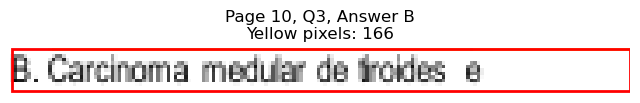

Page 10, Q3 - C: Detected box: x0=322.9, y0=229.6, x1=457.3, y1=241.7
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 666
Page 10, Q3, C: Yellow percentage: 0.0%


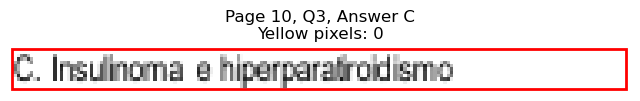

Page 10, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=502.3, y1=253.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 873
Page 10, Q3, D: Yellow percentage: 0.0%


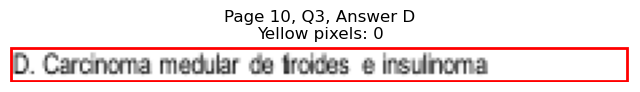

Page 10, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=375.6, y1=265.7
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 438
Page 10, Q3, E: Yellow percentage: 0.0%


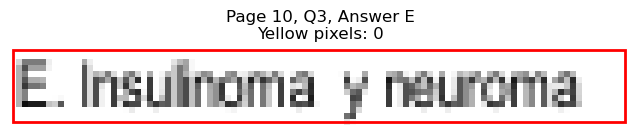


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=121.0, y1=301.8
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 178
Page 10, Q4, A: Yellow percentage: 0.0%


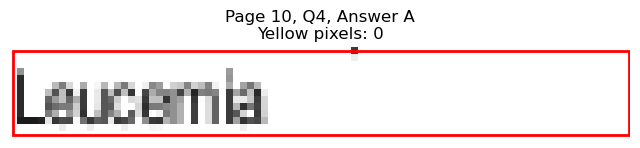

Page 10, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=146.4, y1=314.5
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 334
Page 10, Q4, B: Yellow percentage: 0.0%


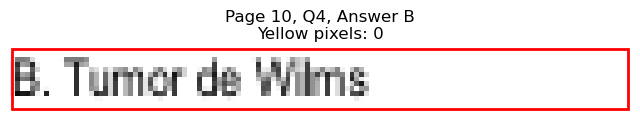

Page 10, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=145.7, y1=326.5
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 359
Page 10, Q4, C: Yellow percentage: 0.0%


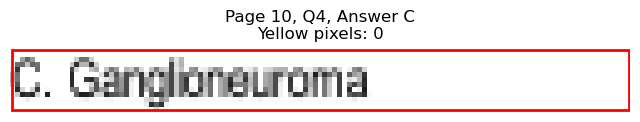

Page 10, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=392.1, y1=301.8
Page 10, Q4, D: Yellow pixels: 520
Page 10, Q4, D: Total non-white pixels: 884
Page 10, Q4, D: Yellow percentage: 58.8%


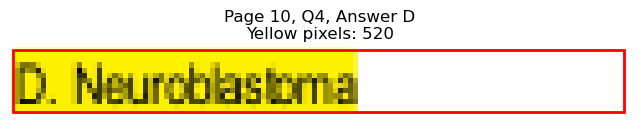

Page 10, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=419.0, y1=314.5
Page 10, Q4, E: Yellow pixels: 66
Page 10, Q4, E: Total non-white pixels: 576
Page 10, Q4, E: Yellow percentage: 11.5%


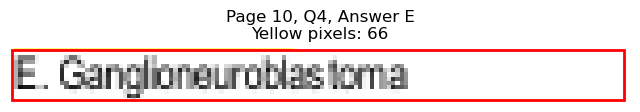


Page 10, Q4 - Selected Answer: D (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.6, y0=350.5, x1=137.5, y1=362.5
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 418
Page 10, Q5, A: Yellow percentage: 0.0%


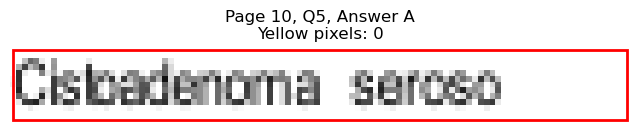

Page 10, Q5 - B: Detected box: x0=71.3, y0=362.5, x1=238.0, y1=374.6
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 801
Page 10, Q5, B: Yellow percentage: 0.0%


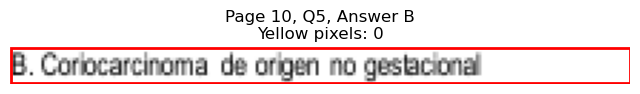

Page 10, Q5 - C: Detected box: x0=71.3, y0=374.5, x1=137.5, y1=386.6
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 493
Page 10, Q5, C: Yellow percentage: 0.0%


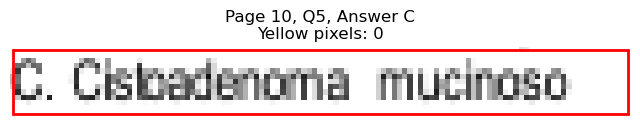

Page 10, Q5 - D: Detected box: x0=322.9, y0=350.5, x1=390.6, y1=362.5
Page 10, Q5, D: Yellow pixels: 567
Page 10, Q5, D: Total non-white pixels: 871
Page 10, Q5, D: Yellow percentage: 65.1%


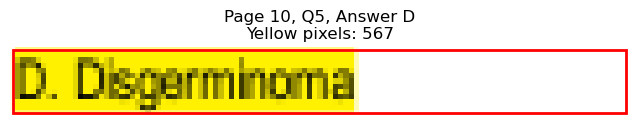

Page 10, Q5 - E: Detected box: x0=322.9, y0=181.6, x1=406.3, y1=193.6
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 420
Page 10, Q5, E: Yellow percentage: 0.0%


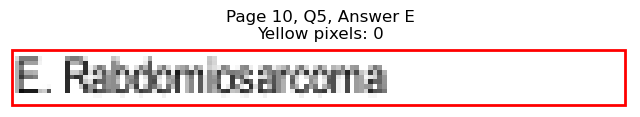


Page 10, Q5 - Selected Answer: D (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.6, y0=410.5, x1=137.6, y1=422.6
Page 10, Q6, A: Yellow pixels: 374
Page 10, Q6, A: Total non-white pixels: 703
Page 10, Q6, A: Yellow percentage: 53.2%


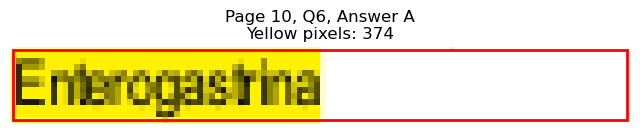

Page 10, Q6 - B: Detected box: x0=71.3, y0=422.5, x1=118.7, y1=434.6
Page 10, Q6, B: Yellow pixels: 52
Page 10, Q6, B: Total non-white pixels: 286
Page 10, Q6, B: Yellow percentage: 18.2%


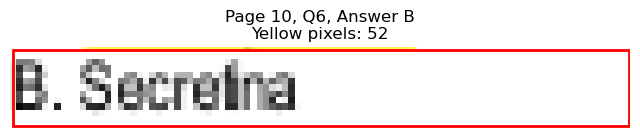

Page 10, Q6 - C: Detected box: x0=71.3, y0=434.6, x1=124.0, y1=446.6
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 248
Page 10, Q6, C: Yellow percentage: 0.0%


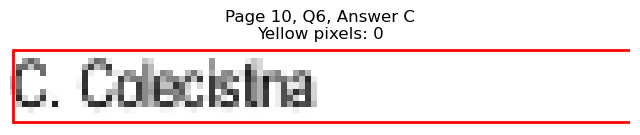

Page 10, Q6 - D: Detected box: x0=322.9, y0=410.5, x1=395.8, y1=422.6
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 378
Page 10, Q6, D: Yellow percentage: 0.0%


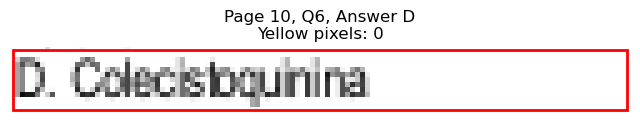

Page 10, Q6 - E: Detected box: x0=322.9, y0=422.5, x1=374.8, y1=434.6
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 256
Page 10, Q6, E: Yellow percentage: 0.0%


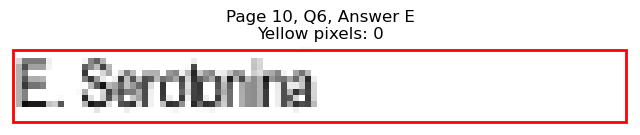


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.6, y0=470.6, x1=181.9, y1=482.6
Page 10, Q7, A: Yellow pixels: 775
Page 10, Q7, A: Total non-white pixels: 1274
Page 10, Q7, A: Yellow percentage: 60.8%


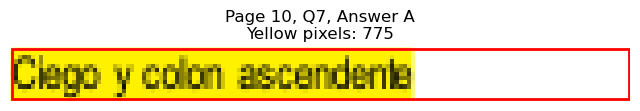

Page 10, Q7 - B: Detected box: x0=71.3, y0=483.4, x1=146.5, y1=495.4
Page 10, Q7, B: Yellow pixels: 96
Page 10, Q7, B: Total non-white pixels: 483
Page 10, Q7, B: Yellow percentage: 19.9%


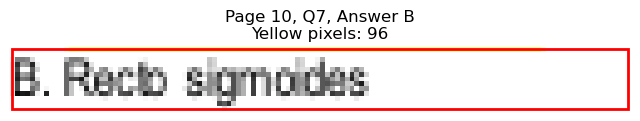

Page 10, Q7 - C: Detected box: x0=71.3, y0=495.4, x1=148.7, y1=507.4
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 346
Page 10, Q7, C: Yellow percentage: 0.0%


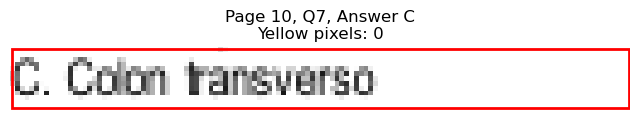

Page 10, Q7 - D: Detected box: x0=322.9, y0=470.6, x1=407.8, y1=482.6
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 418
Page 10, Q7, D: Yellow percentage: 0.0%


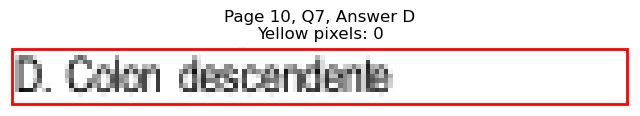

Page 10, Q7 - E: Detected box: x0=322.9, y0=483.4, x1=365.0, y1=495.4
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 380
Page 10, Q7, E: Yellow percentage: 0.0%


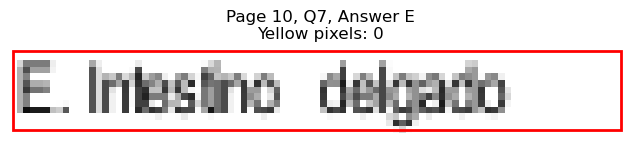


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es la estructura en que se basa el diagn...
1   ¿Cuál es el factor pronóstico más importante e...
2   ¿Cuál de los siguientes tumores se asocia a er...
3   Varón de 23 años y otros miembros de su club n...
4   ¿Cuál es la localización del melanoma intraocu...
..                                                ...
95  ¿Qué entidades patológicas están en relación c...
96  ¿Cuál es la neoplasia maligna más frecuente en...
97  ¿Cuál es el tumor ovárico más frecuente en niñ...
98  ¿Cuál es la hormona que actúa disminuyendo la ...
99  ¿Cuál es la localización más frecuente de la i...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0              Serosa en bronquios extrapulmonares   
1                                    Etapa clínica   
2                               Cáncer de próstata   
3                                              VPH   
4                                    Cuerpo ciliar   
..                                             ...   
95  Carcinoma medular de tiroides y feocromocitoma   
96                                        Leucemia   
97                             Cistoadenoma seroso   
98                                  Enterogastrina   
99                        Ciego y colon ascendente   

                                     option_B  \
0   Músculo liso en bronquios intrapulmonares   
1                            Tipo histológico   
2                              Cáncer de mama   
3             Streptococcus beta hemolítico A   
4                                     Corneal   
..                                        ...   
95            Carcinoma medular de tiroides e   
96                             Tumor de Wilms   
97    Coriocarcinoma de origen no gestacional   
98                                  Secretina   
99                            Recto sigmoides   

                                      option_C  \
0          Epitelio cúbico simple en bronquios   
1   Incapacidad para detectar en el tejido PVH   
2                             Cáncer de pulmón   
3                            Sarcoptes scabiei   
4                               Extra escleral   
..                                         ...   
95            Insulinoma e hiperparatiroidismo   
96                              Ganglioneuroma   
97                       Cistoadenoma mucinoso   
98                                 Colecistina   
99                            Colon transverso   

                                      option_D  \
0   Cartílago hialino discontinuo en bronquios   
1    Densidad de microvasculatura en el tejido   
2                              Hepatocarcinoma   
3                         Staphylococcus areus   
4                                         Iris   
..                                         ...   
95  Carcinoma medular de tiroides e insulinoma   
96                               Neuroblastoma   
97                                Disgerminoma   
98                            Colecistoquinina   
99                           Colon descendente   

                                      option_E  
0   Cartílago hialino discontinuo en bronquios  
1                            Grado histológico  
2                       Cáncer de paratiroides  
3                          Trichophyton rubrun  
4                                     Coroideo  
..                                         ...  
95                        Insulinoma y neuroma  
96                        Ganglioneuroblastoma  
97                             Rabdomiosarcoma  
98                                  Serotonina  
99                           Intestino delgado  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               A
2               D
3               E
4               D
..            ...
95              A
96              D
97              D
98              A
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   ¿Cuál es la estructura en que se basa el diagn...   
1   ¿Cuál es el factor pronóstico más importante e...   
2   ¿Cuál de los siguientes tumores se asocia a er...   
3   Varón de 23 años y otros miembros de su club n...   
4   ¿Cuál es la localización del melanoma intraocu...   
..                                                ...   
95  ¿Qué entidades patológicas están en relación c...   
96  ¿Cuál es la neoplasia maligna más frecuente en...   
97  ¿Cuál es el tumor ovárico más frecuente en niñ...   
98  ¿Cuál es la hormona que actúa disminuyendo la ...   
99  ¿Cuál es la localización más frecuente de la i...   

                                          option_A  \
0              Serosa en bronquios extrapulmonares   
1                                    Etapa clínica   
2                               Cáncer de próstata   
3                                              VPH   
4                                    Cuerpo ciliar   
..                                             ...   
95  Carcinoma medular de tiroides y feocromocitoma   
96                                        Leucemia   
97                             Cistoadenoma seroso   
98                                  Enterogastrina   
99                        Ciego y colon ascendente   

                                     option_B  \
0   Músculo liso en bronquios intrapulmonares   
1                            Tipo histológico   
2                              Cáncer de mama   
3             Streptococcus beta hemolítico A   
4                                     Corneal   
..                                        ...   
95            Carcinoma medular de tiroides e   
96                             Tumor de Wilms   
97    Coriocarcinoma de origen no gestacional   
98                                  Secretina   
99                            Recto sigmoides   

                                      option_C  \
0          Epitelio cúbico simple en bronquios   
1   Incapacidad para detectar en el tejido PVH   
2                             Cáncer de pulmón   
3                            Sarcoptes scabiei   
4                               Extra escleral   
..                                         ...   
95            Insulinoma e hiperparatiroidismo   
96                              Ganglioneuroma   
97                       Cistoadenoma mucinoso   
98                                 Colecistina   
99                            Colon transverso   

                                      option_D  \
0   Cartílago hialino discontinuo en bronquios   
1    Densidad de microvasculatura en el tejido   
2                              Hepatocarcinoma   
3                         Staphylococcus areus   
4                                         Iris   
..                                         ...   
95  Carcinoma medular de tiroides e insulinoma   
96                               Neuroblastoma   
97                                Disgerminoma   
98                            Colecistoquinina   
99                           Colon descendente   

                                      option_E correct_answer  
0   Cartílago hialino discontinuo en bronquios              C  
1                            Grado histológico              A  
2                       Cáncer de paratiroides              D  
3                          Trichophyton rubrun              E  
4                                     Coroideo              D  
..                                         ...            ...  
95                        Insulinoma y neuroma              A  
96                        Ganglioneuroblastoma              D  
97                             Rabdomiosarcoma              D  
98                                  Serotonina              A  
99                           Intestino delgado              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/PATOLOGIA.csv
